In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, BatchNormalization

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR') 

In [3]:
stock_data = yf.download('AAPL', start='1980-12-11', end='2023-12-02')
stock_data

[*********************100%%**********************]  1 of 1 completed


Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099319   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094137   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087228   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089387   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091978   
...                ...         ...         ...         ...         ...   
2023-11-27  189.919998  190.669998  188.899994  189.789993  189.789993   
2023-11-28  189.779999  191.080002  189.399994  190.399994  190.399994   
2023-11-29  190.899994  192.089996  188.970001  189.369995  189.369995   
2023-11-30  189.839996  190.320007  188.190002  189.949997  189.949997   
2023-12-01  190.330002  191.559998  189.229996  191.240005  191.240005   

               Volume  
Date                   
1980-12-12  469033600  
1980-12-15  175884800  
1980-12-16  105728000  
1980-12-17   86441600  
1980-12-18   73449600  
...               ...  
2023-11-27   40552600  
2023-11-28   38415400  
2023-11-29   43014200  
2023-11-30   48794400  
2023-12-01   45679300  

[10834 rows x 6 columns]

In [4]:
stock_data.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
#stock_data.reset_index(inplace=True)

In [6]:
#stock_data['Date'] = stock_data.index
#stock_data

In [7]:
stock_data.head()

Open      High       Low     Close  Adj Close     Volume
Date                                                                    
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099319  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094137  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087228  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089387   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091978   73449600

In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10834 entries, 1980-12-12 to 2023-12-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10834 non-null  float64
 1   High       10834 non-null  float64
 2   Low        10834 non-null  float64
 3   Close      10834 non-null  float64
 4   Adj Close  10834 non-null  float64
 5   Volume     10834 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 592.5 KB


In [9]:
stock_data.describe()

Open          High           Low         Close     Adj Close  \
count  10834.000000  10834.000000  10834.000000  10834.000000  10834.000000   
mean      19.752257     19.970329     19.543086     19.765683     19.013750   
std       41.335900     41.800261     40.905323     41.373839     40.966941   
min        0.049665      0.049665      0.049107      0.049107      0.038000   
25%        0.294643      0.301339      0.286998      0.294643      0.241206   
50%        0.508929      0.515625      0.500000      0.507813      0.417318   
75%       18.760892     18.960625     18.635625     18.791787     16.364078   
max      196.240005    198.229996    195.279999    196.449997    195.926956   

             Volume  
count  1.083400e+04  
mean   3.219534e+08  
std    3.364729e+08  
min    0.000000e+00  
25%    1.164632e+08  
50%    2.094400e+08  
75%    4.018196e+08  
max    7.421641e+09

In [10]:
stock_data.corr()

Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999946  0.999935  0.999865   0.999628 -0.239221
High       0.999946  1.000000  0.999921  0.999935   0.999705 -0.238805
Low        0.999935  0.999921  1.000000  0.999938   0.999704 -0.239898
Close      0.999865  0.999935  0.999938  1.000000   0.999769 -0.239366
Adj Close  0.999628  0.999705  0.999704  0.999769   1.000000 -0.241291
Volume    -0.239221 -0.238805 -0.239898 -0.239366  -0.241291  1.000000

## Model Function

In [229]:
def create_lstm_model(look_back, features):
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(look_back, len(features))))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    return lstm_model

def create_gru_model(look_back, features):
    gru_model = Sequential()
    gru_model.add(GRU(50, input_shape=(look_back, len(features))))
    gru_model.add(Dropout(0.2))
    gru_model.add(Dense(1))
    gru_model.compile(loss='mean_squared_error', optimizer='adam')
    return gru_model

def create_mlp_model(look_back, features):
    mlp_model = Sequential()
    mlp_model.add(Flatten(input_shape=(look_back, len(features))))
    mlp_model.add(Dense(50, activation='relu'))
    mlp_model.add(Dense(1))
    mlp_model.compile(loss='mean_squared_error', optimizer='adam')
    return mlp_model

def create_cnn_model(look_back, features):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, len(features))))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(LSTM(50, return_sequences=True))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(50, activation='relu'))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss='mean_squared_error', optimizer='adam')
    return cnn_model

## Plotting Function

In [12]:
def plot_model_results(model_history, actual_prices, predicted_prices, stock_data_dates):
    plt.figure(figsize=(10,6))
    plt.plot(model_history['loss'], label='Training Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(model_history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    # Plot actual vs predicted stock prices
    plt.figure(figsize=(10,6))
    plt.plot(stock_data_dates[-len(actual_prices):], actual_prices, label='Actual Prices')
    plt.plot(stock_data_dates[-len(predicted_prices):], predicted_prices, label='Predicted Prices')
    plt.title('Apple Stock Price Prediction - Actual vs. Predicted')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    errors = actual_prices - predicted_prices
    sns.histplot(errors, kde=True)
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.show()

In [13]:
# Select features and target variable
features = ["Open", "High", "Low", "Volume"]
target = "Close"

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_1 = scaler.fit_transform(stock_data[features])

## Sequence Function

In [14]:
look_back = 60

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(scaled_data_1, look_back)

In [15]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [16]:
actual_stock_prices = stock_data["Close"][-len(X_test):].values

## Basic Model LSTM

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture used in deep learning. Unlike standard feedforward neural networks, LSTMs have feedback connections, making them ideal for processing sequences of data. They are particularly effective in tasks that require learning from experience to classify, process, or predict time-series data. LSTMs are designed to overcome the vanishing gradient problem that can occur in traditional RNNs, allowing them to learn and remember over long sequences of data.

In [17]:
basic_lstm = create_lstm_model(look_back, features)
lstm_basic = basic_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

basic_lstm_predictions = basic_lstm.predict(X_test)

# Reshape predictions for inverse transform
basic_lstm_predictions_reshaped = basic_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((basic_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = basic_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
basic_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
basic_lstm_predictions_final = basic_lstm_predictions_inversed[:, 0]

Epoch 1/20
216/216 - 4s - loss: 8.0065e-04 - val_loss: 0.0011 - 4s/epoch - 17ms/step
Epoch 2/20
216/216 - 3s - loss: 7.8688e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 3/20
216/216 - 3s - loss: 7.8620e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 4/20
216/216 - 3s - loss: 7.8387e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 5/20
216/216 - 3s - loss: 7.8393e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 6/20
216/216 - 3s - loss: 7.8358e-04 - val_loss: 0.0012 - 3s/epoch - 12ms/step
Epoch 7/20
216/216 - 3s - loss: 7.8405e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 8/20
216/216 - 3s - loss: 7.8305e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 9/20
216/216 - 3s - loss: 7.8399e-04 - val_loss: 0.0018 - 3s/epoch - 12ms/step
Epoch 10/20
216/216 - 3s - loss: 7.8255e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 11/20
216/216 - 3s - loss: 7.8160e-04 - val_loss: 0.0012 - 3s/epoch - 12ms/step
Epoch 12/20
216/216 - 3s - loss: 7.8224e-04 - val_loss: 0.0011 

In [18]:
mae = mean_absolute_error(actual_stock_prices, basic_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, basic_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, basic_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 11.142424777422539, MSE: 312.47745056121903, RMSE: 17.677031723714787, R2 Score: 0.8981898397959548


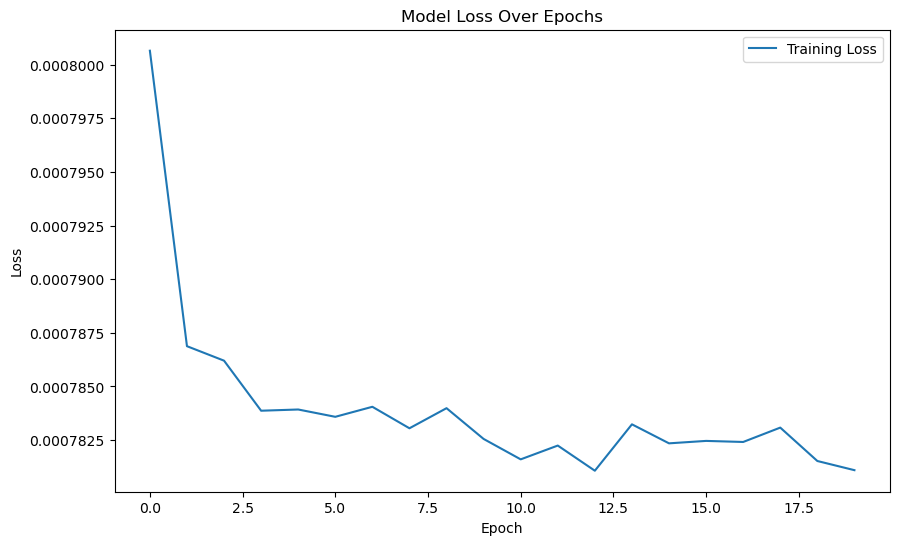

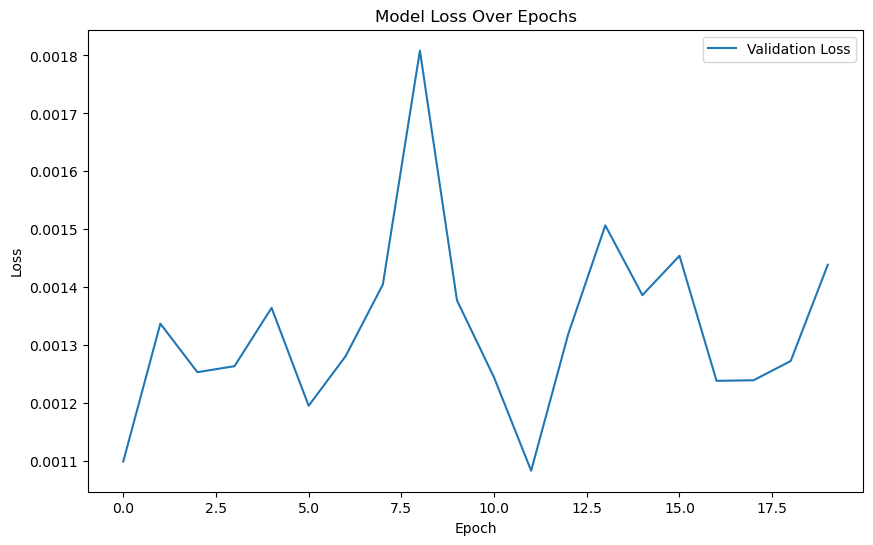

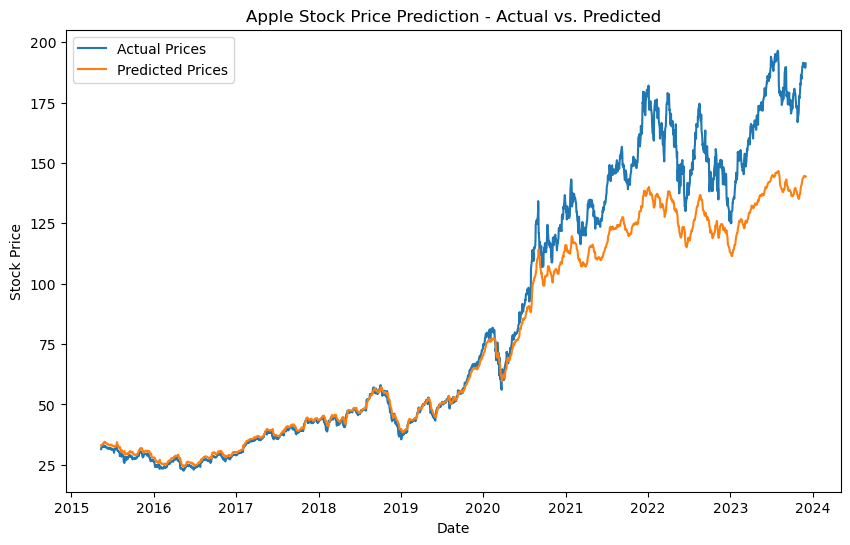

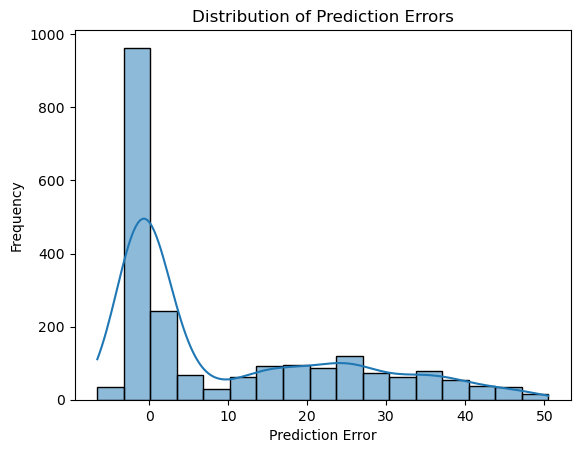

In [19]:
plot_model_results(lstm_basic.history, actual_stock_prices, basic_lstm_predictions_final, stock_data.index)

## Basic Model GRU

The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) architecture used in deep learning. Introduced in 2014, GRUs are designed to solve the vanishing gradient problem that can occur in traditional RNNs. This makes them more effective for processing sequences of data for tasks like language modeling and speech recognition. GRUs achieve this efficiency through two gates: an update gate and a reset gate. These gates help the model to capture dependencies in the input data over various time steps, allowing it to maintain relevant information and discard irrelevant data throughout the process.

In [20]:
basic_gru = create_gru_model(look_back, features)
gru_basic = basic_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))
gru_predictions = basic_gru.predict(X_test)

# Reshape predictions for inverse transform
gru_predictions_reshaped = gru_predictions.reshape(-1, 1)
# Create a dummy array to match the scaler's expected input shape
dummy_array = np.zeros((gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = gru_predictions_reshaped.ravel()
# Apply inverse transformation
gru_predictions_inversed = scaler.inverse_transform(dummy_array)
gru_predictions_final = gru_predictions_inversed[:, 0]

Epoch 1/20
216/216 - 3s - loss: 8.0288e-04 - val_loss: 0.0016 - 3s/epoch - 16ms/step
Epoch 2/20
216/216 - 3s - loss: 7.8827e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 3/20
216/216 - 3s - loss: 7.8705e-04 - val_loss: 0.0015 - 3s/epoch - 12ms/step
Epoch 4/20
216/216 - 3s - loss: 7.8453e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 5/20
216/216 - 3s - loss: 7.8465e-04 - val_loss: 0.0016 - 3s/epoch - 12ms/step
Epoch 6/20
216/216 - 3s - loss: 7.8368e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 7/20
216/216 - 3s - loss: 7.8318e-04 - val_loss: 0.0016 - 3s/epoch - 12ms/step
Epoch 8/20
216/216 - 3s - loss: 7.8275e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 9/20
216/216 - 3s - loss: 7.8337e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 10/20
216/216 - 3s - loss: 7.8331e-04 - val_loss: 0.0013 - 3s/epoch - 12ms/step
Epoch 11/20
216/216 - 3s - loss: 7.8295e-04 - val_loss: 0.0014 - 3s/epoch - 12ms/step
Epoch 12/20
216/216 - 3s - loss: 7.8361e-04 - val_loss: 0.0014 

In [21]:
mae = mean_absolute_error(actual_stock_prices, gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 2.790812435352455, MSE: 10.370069711871539, RMSE: 3.220259261592386, R2 Score: 0.9966212651287427


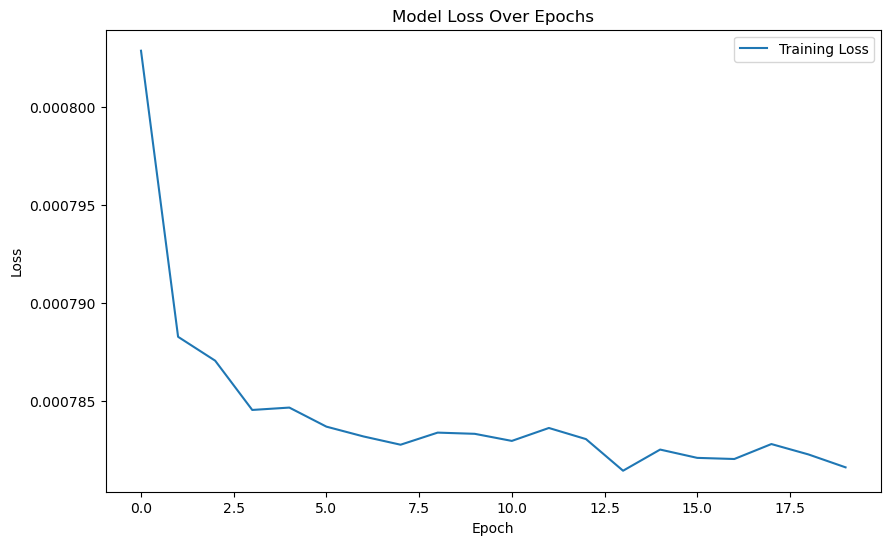

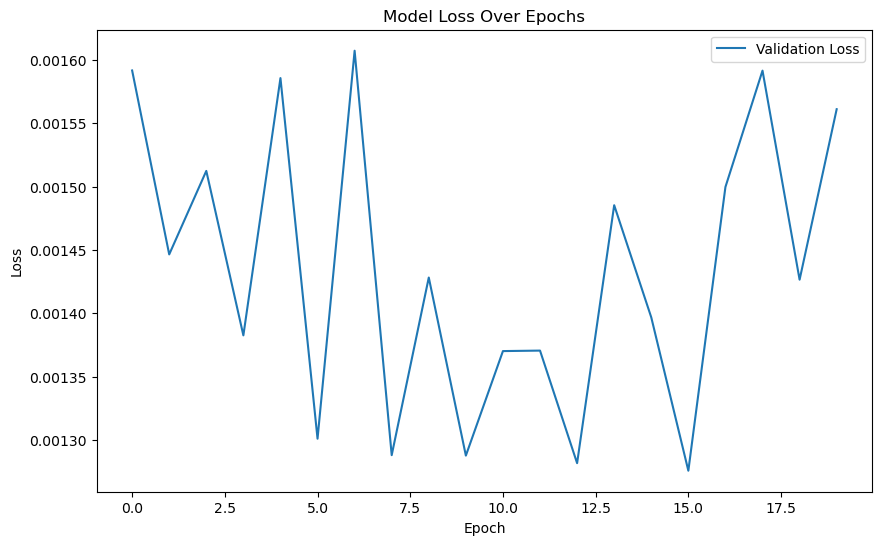

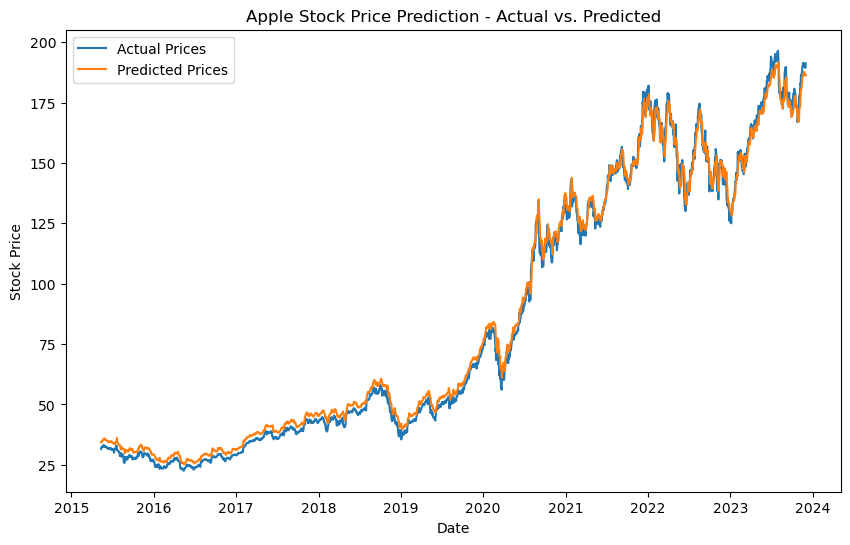

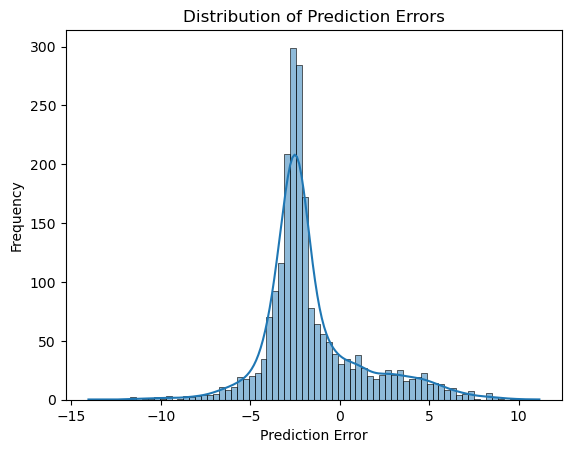

In [22]:
plot_model_results(gru_basic.history, actual_stock_prices, gru_predictions_final, stock_data.index)

## Basic Model MLP

The Multilayer Perceptron (MLP) is a foundational type of artificial neural network used in machine learning. Comprising one or more layers of nodes, MLPs are characterized by their fully connected structure, where each node in one layer is connected to every node in the subsequent layer. These nodes, or neurons, apply nonlinear activation functions, enabling the network to learn complex patterns in data. MLPs are used for tasks like classification and regression, and they excel in pattern recognition and predictive modeling. Training an MLP involves optimizing weights through backpropagation and gradient descent to minimize prediction errors

In [23]:
basic_mlp = create_mlp_model(look_back, features)
mlp_basic = basic_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))
mlp_predictions = basic_mlp.predict(X_test)

# Reshape predictions for inverse transform
mlp_predictions_reshaped = mlp_predictions.reshape(-1, 1)
# Create a dummy array to match the scaler's expected input shape
dummy_array = np.zeros((mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = mlp_predictions_reshaped.ravel()
# Apply inverse transformation
mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
mlp_predictions_final = mlp_predictions_inversed[:, 0]

Epoch 1/20
216/216 - 1s - loss: 0.0012 - val_loss: 0.0023 - 1s/epoch - 5ms/step
Epoch 2/20
216/216 - 1s - loss: 8.1716e-04 - val_loss: 0.0013 - 769ms/epoch - 4ms/step
Epoch 3/20
216/216 - 1s - loss: 7.9535e-04 - val_loss: 0.0013 - 774ms/epoch - 4ms/step
Epoch 4/20
216/216 - 1s - loss: 7.9172e-04 - val_loss: 0.0011 - 766ms/epoch - 4ms/step
Epoch 5/20
216/216 - 1s - loss: 7.9186e-04 - val_loss: 0.0026 - 766ms/epoch - 4ms/step
Epoch 6/20
216/216 - 1s - loss: 8.0908e-04 - val_loss: 0.0012 - 765ms/epoch - 4ms/step
Epoch 7/20
216/216 - 1s - loss: 7.9037e-04 - val_loss: 0.0014 - 783ms/epoch - 4ms/step
Epoch 8/20
216/216 - 1s - loss: 7.9420e-04 - val_loss: 0.0010 - 781ms/epoch - 4ms/step
Epoch 9/20
216/216 - 1s - loss: 8.0172e-04 - val_loss: 0.0018 - 770ms/epoch - 4ms/step
Epoch 10/20
216/216 - 1s - loss: 7.8733e-04 - val_loss: 0.0010 - 784ms/epoch - 4ms/step
Epoch 11/20
216/216 - 1s - loss: 7.9343e-04 - val_loss: 0.0017 - 763ms/epoch - 4ms/step
Epoch 12/20
216/216 - 1s - loss: 7.9030e-04 - va

In [24]:
mae = mean_absolute_error(actual_stock_prices, mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 12.168399290640458, MSE: 225.43106059688557, RMSE: 15.014361811175512, R2 Score: 0.9265509483864652


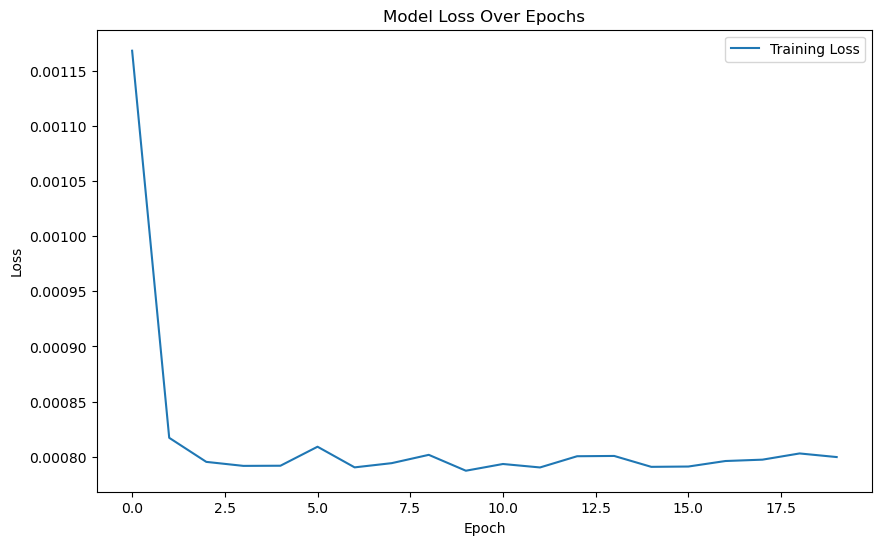

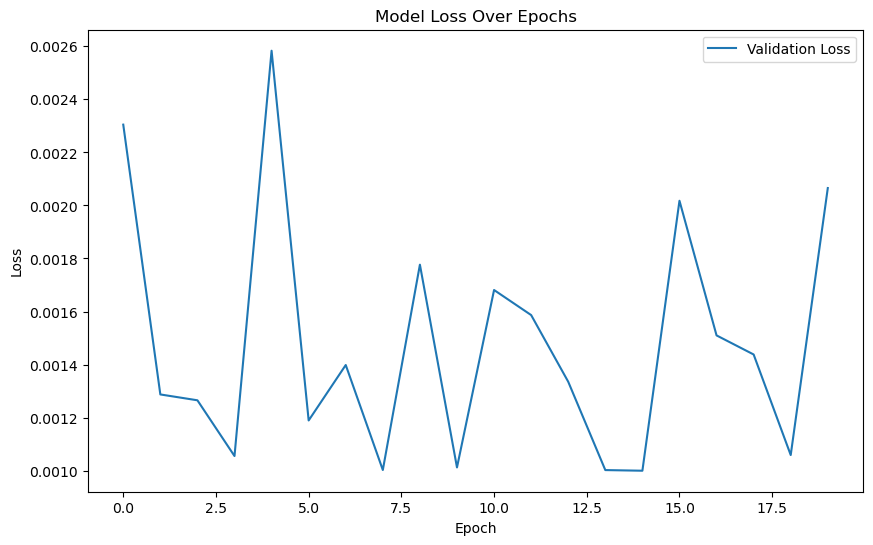

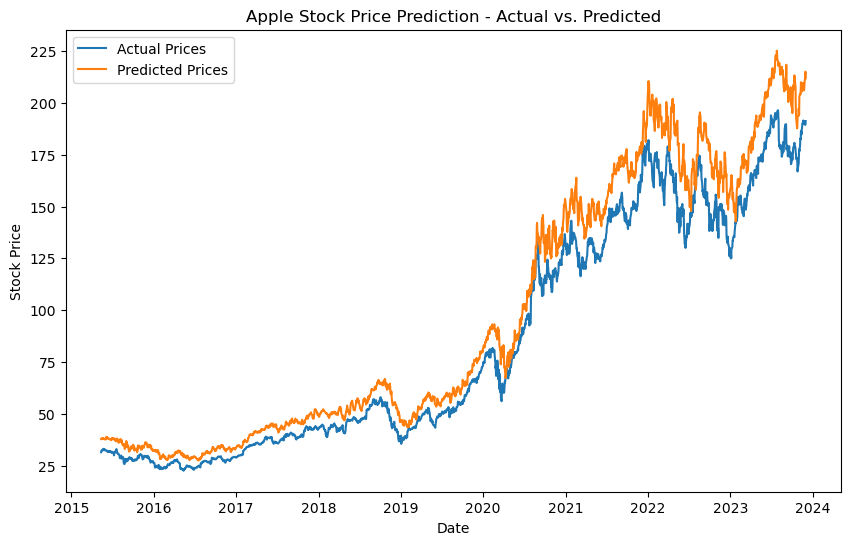

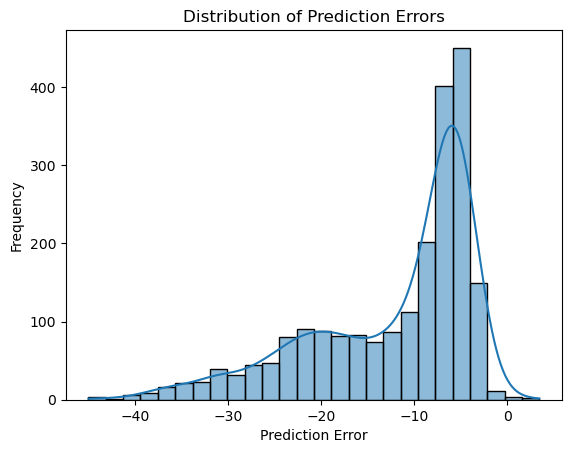

In [25]:
plot_model_results(mlp_basic.history, actual_stock_prices, mlp_predictions_final, stock_data.index)

## Basic Model CNN

 Convolutional Neural Network (CNN) is a deep learning algorithm predominantly used in image recognition and processing. It automatically and adaptively learns spatial hierarchies of features from input images. A typical CNN architecture comprises various layers, including convolutional layers that apply filters to detect patterns, pooling layers that reduce dimensionality, and fully connected layers for classification. CNNs are especially effective in tasks like object detection, facial recognition, and image classification, due to their ability to capture spatial and temporal dependencies in an image through the application of relevant filters.

In [26]:
basic_cnn = create_cnn_model(look_back, features)
cnn_basic = basic_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))
cnn_predictions = basic_cnn.predict(X_test)

# Reshape predictions for inverse transform
cnn_predictions_reshaped = cnn_predictions.reshape(-1, 1)
# Create a dummy array to match the scaler's expected input shape
dummy_array = np.zeros((cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = cnn_predictions_reshaped.ravel()
# Apply inverse transformation
cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
cnn_predictions_final = cnn_predictions_inversed[:, 0]

Epoch 1/20
216/216 - 3s - loss: 9.4273e-04 - val_loss: 0.0013 - 3s/epoch - 15ms/step
Epoch 2/20
216/216 - 2s - loss: 8.3987e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 3/20
216/216 - 2s - loss: 8.2284e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 4/20
216/216 - 2s - loss: 8.1353e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 5/20
216/216 - 2s - loss: 8.0883e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 6/20
216/216 - 2s - loss: 8.1067e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 7/20
216/216 - 2s - loss: 8.0180e-04 - val_loss: 0.0010 - 2s/epoch - 10ms/step
Epoch 8/20
216/216 - 2s - loss: 8.0605e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 9/20
216/216 - 2s - loss: 8.0080e-04 - val_loss: 0.0010 - 2s/epoch - 10ms/step
Epoch 10/20
216/216 - 2s - loss: 7.9931e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 11/20
216/216 - 2s - loss: 8.0010e-04 - val_loss: 0.0010 - 2s/epoch - 10ms/step
Epoch 12/20
216/216 - 2s - loss: 8.0014e-04 - val_loss: 0.0011 

In [27]:
mae = mean_absolute_error(actual_stock_prices, cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 19.62017673910642, MSE: 743.4102836035112, RMSE: 27.26555122500756, R2 Score: 0.757785017974665


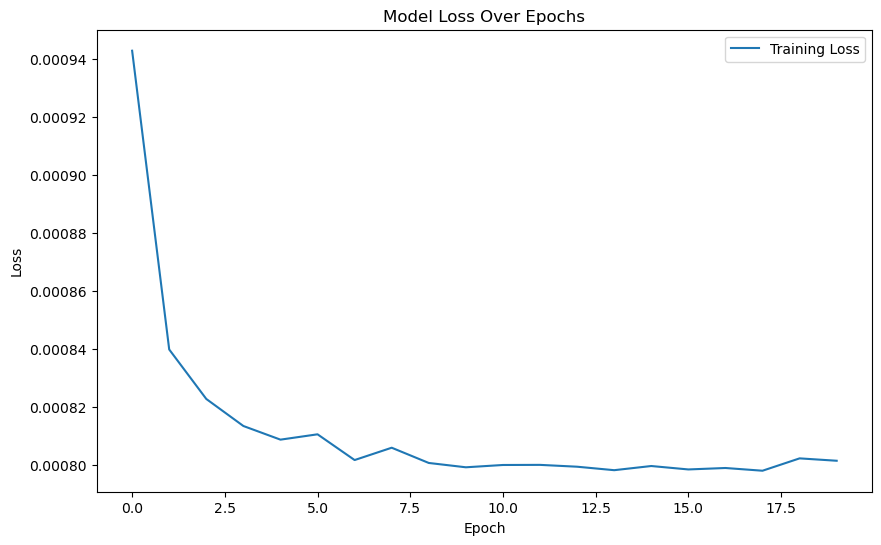

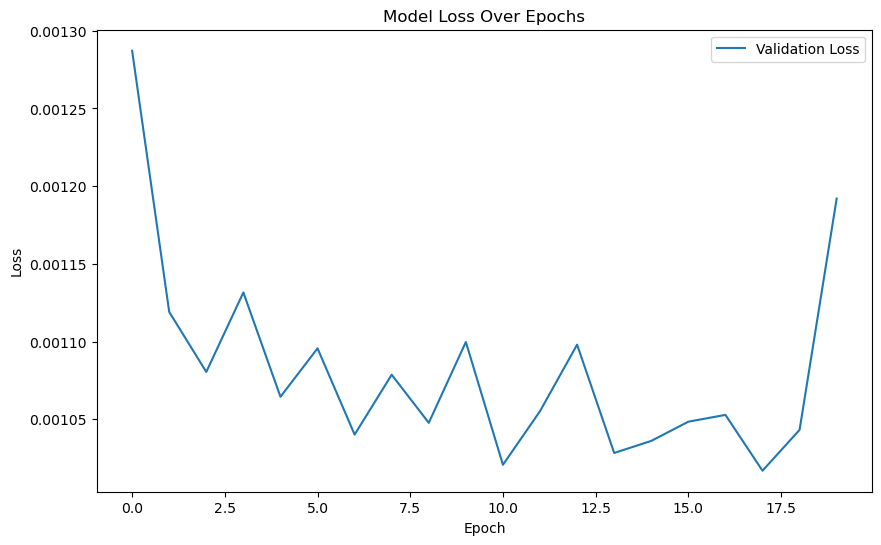

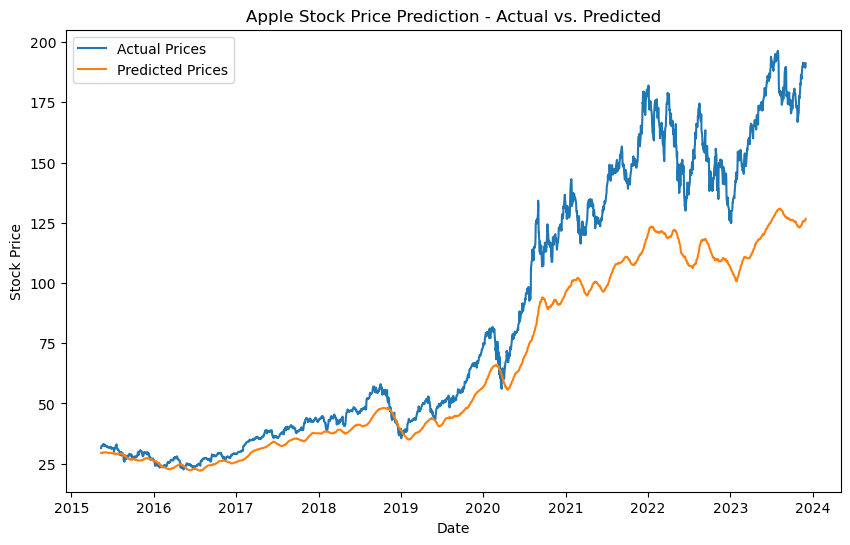

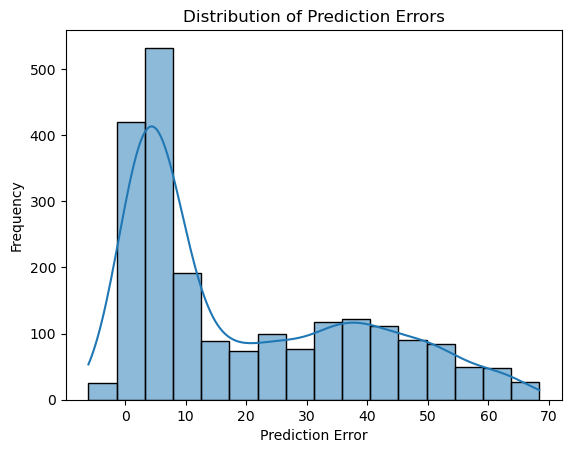

In [28]:
plot_model_results(cnn_basic.history, actual_stock_prices, cnn_predictions_final, stock_data.index)

## Creating Features

### Moving Averages:
Simple Moving Average (SMA): An average of a stock's closing price over a specific number of days. <br>
Exponential Moving Average (EMA): Similar to SMA, but gives more weight to recent prices.
### Price Change and Returns:
Daily Price Change: The difference in closing price from one day to the next.<br>
Percentage Change: The percentage difference in closing price from one day to the next.<br>
Cumulative Returns: The aggregate return of the stock over a period of time.
### Volatility Measures:
Historical Volatility: Standard deviation of the daily price changes over a certain period.
### Momentum Indicators:
Relative Strength Index (RSI): Measures the speed and change of price movements.<br>
Moving Average Convergence Divergence (MACD): Shows the relationship between two moving averages of a stock’s price.
### Volume Indicators:
On-Balance Volume (OBV): Uses volume flow to predict changes in stock price.<br>
Volume-Weighted Average Price (VWAP): Gives the average price a stock has traded at throughout the day, based on both volume and price.
### Bollinger Bands:
A set of lines plotted two standard deviations (positively and negatively) away from a simple moving average of the stock's price.
### Support and Resistance Levels:
These are not direct calculations but can be estimated from the historical highs and lows in the stock's price.
### Candlestick Patterns:
Though not a direct calculation, patterns in the candlestick chart (formed by Open, High, Low, Close) can indicate potential market trends or reversals.
### Oscillators:
Various oscillators like the Stochastic Oscillator can be used to predict the momentum of the stock prices.
### Price Averages:
Typical Price: Average of high, low, and closing price.<br>
Weighted Close: Average of high, low, and twice the closing price.
### Pivot Points:
Used to determine overall trends and reversal points. They are calculated using the high, low, and close of the previous trading day.

In [29]:
df = stock_data.copy()

In [30]:
# Simple Moving Average (SMA)
df['SMA_10'] = df['Close'].rolling(window=10).mean()  # 10-day SMA
df['SMA_30'] = df['Close'].rolling(window=30).mean()  # 30-day SMA

# Exponential Moving Average (EMA)
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # 10-day EMA
df['EMA_30'] = df['Close'].ewm(span=30, adjust=False).mean()  # 30-day EMA

# Daily Price Change
df['Price_Change'] = df['Close'].diff()

# Price Range
df['Price_Range'] = df['High'] - df['Low']

# Log Returns
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Percentage Change
df['Pct_Change'] = df['Close'].pct_change()

# Historical Volatility (using 30-day window)
df['Volatility'] = df['Pct_Change'].rolling(window=30).std() * (252 ** 0.5)  # Annualized Volatility

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# Bollinger Bands
df['Middle_Band'] = df['Close'].rolling(window=20).mean()
df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(window=20).std() * 2)
df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(window=20).std() * 2)

# Typical Price
df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3

# Weighted Close
df['Weighted_Close'] = (df['High'] + df['Low'] + df['Close'] * 2) / 4

In [31]:
df.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099319  469033600   
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094137  175884800   
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087228  105728000   
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089387   86441600   
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091978   73449600   

            SMA_10  SMA_30    EMA_10    EMA_30  ...  Log_Returns  Pct_Change  \
Date                                            ...                            
1980-12-12     NaN     NaN  0.128348  0.128348  ...          NaN         NaN   
1980-12-15     NaN     NaN  0.127131  0.127916  ...    -0.053581   -0.052171   
1980-12-16     NaN     NaN  0.124511  0.126936  ...    -0.076231   -0.073398   
1980-12-17     NaN     NaN  0.122875  0.126199  ...     0.024450    0.024751   
1980-12-18     NaN     NaN  0.122145  0.125726  ...     0.028580    0.028992   

            Volatility  RSI          OBV  Middle_Band  Upper_Band  Lower_Band  \
Date                                                                            
1980-12-12         NaN  NaN          0.0          NaN         NaN         NaN   
1980-12-15         NaN  NaN -175884800.0          NaN         NaN         NaN   
1980-12-16         NaN  NaN -281612800.0          NaN         NaN         NaN   
1980-12-17         NaN  NaN -195171200.0          NaN         NaN         NaN   
1980-12-18         NaN  NaN -121721600.0          NaN         NaN         NaN   

            Typical_Price  Weighted_Close  
Date                                       
1980-12-12       0.128534        0.128487  
1980-12-15       0.121838        0.121792  
1980-12-16       0.112909        0.112862  
1980-12-17       0.115699        0.115652  
1980-12-18       0.119048        0.119002  

[5 rows x 22 columns]

In [32]:
df.reset_index(inplace=True)

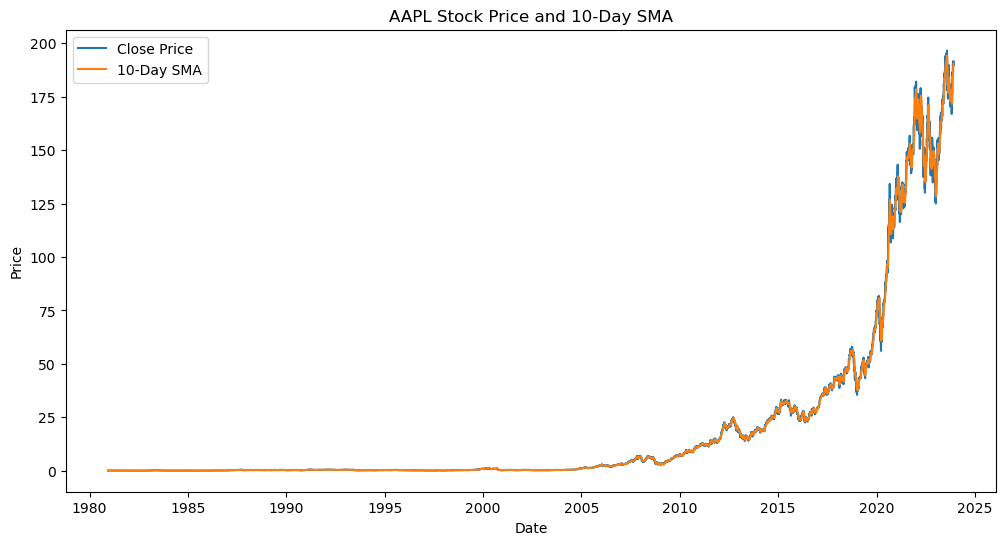

In [33]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['SMA_10'], label='10-Day SMA')
plt.title('AAPL Stock Price and 10-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

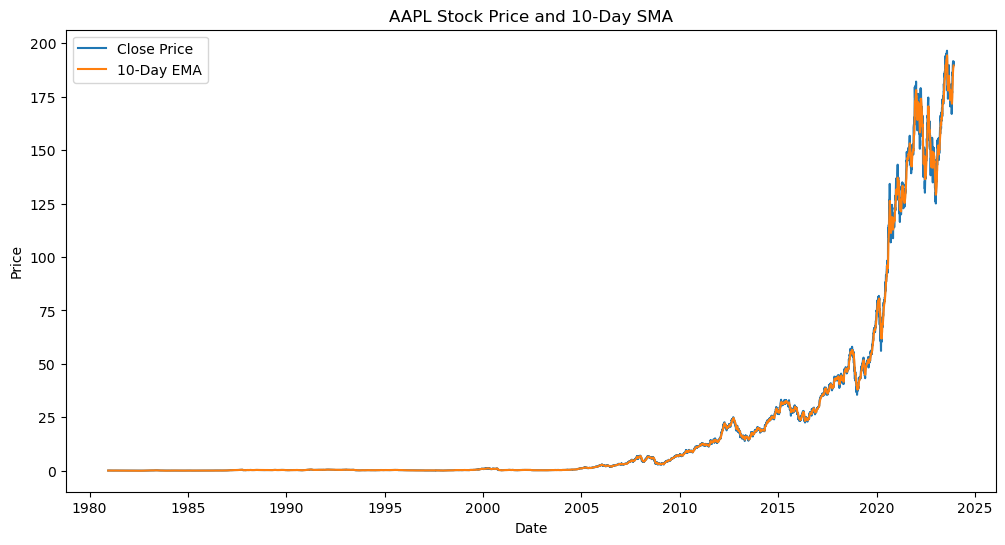

In [34]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['EMA_10'], label='10-Day EMA')
plt.title('AAPL Stock Price and 10-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [35]:
df.corr()

Date      Open      High       Low     Close  Adj Close  \
Date            1.000000  0.667223  0.667089  0.667241  0.667148   0.655709   
Open            0.667223  1.000000  0.999946  0.999935  0.999865   0.999628   
High            0.667089  0.999946  1.000000  0.999921  0.999935   0.999705   
Low             0.667241  0.999935  0.999921  1.000000  0.999938   0.999704   
Close           0.667148  0.999865  0.999935  0.999938  1.000000   0.999769   
Adj Close       0.655709  0.999628  0.999705  0.999704  0.999769   1.000000   
Volume          0.112003 -0.239221 -0.238805 -0.239898 -0.239366  -0.241291   
SMA_10          0.667267  0.999572  0.999579  0.999486  0.999474   0.999256   
SMA_30          0.667395  0.998359  0.998428  0.998214  0.998264   0.998078   
EMA_10          0.667153  0.999700  0.999716  0.999630  0.999625   0.999407   
EMA_30          0.666958  0.998854  0.998912  0.998732  0.998770   0.998586   
Price_Change    0.029024  0.035522  0.040948  0.042103  0.048789   0.048630   
Price_Range     0.570544  0.864735  0.867451  0.861117  0.864143   0.864098   
Log_Returns     0.011347  0.002912  0.004411  0.004785  0.006657   0.006451   
Pct_Change      0.006641 -0.000824  0.000726  0.001054  0.002980   0.002871   
Volatility     -0.430133 -0.316311 -0.315440 -0.317251 -0.316335  -0.307555   
RSI             0.129597  0.071018  0.070903  0.072539  0.072455   0.070151   
OBV             0.956692  0.575095  0.574905  0.575098  0.574979   0.560819   
Middle_Band     0.667366  0.998975  0.999015  0.998847  0.998867   0.998663   
Upper_Band      0.667271  0.998631  0.998724  0.998432  0.998522   0.998324   
Lower_Band      0.666914  0.998526  0.998506  0.998478  0.998420   0.998209   
Typical_Price   0.667174  0.999938  0.999975  0.999976  0.999981   0.999749   
Weighted_Close  0.667170  0.999923  0.999969  0.999970  0.999989   0.999758   

                  Volume    SMA_10    SMA_30    EMA_10  ...  Log_Returns  \
Date            0.112003  0.667267  0.667395  0.667153  ...     0.011347   
Open           -0.239221  0.999572  0.998359  0.999700  ...     0.002912   
High           -0.238805  0.999579  0.998428  0.999716  ...     0.004411   
Low            -0.239898  0.999486  0.998214  0.999630  ...     0.004785   
Close          -0.239366  0.999474  0.998264  0.999625  ...     0.006657   
Adj Close      -0.241291  0.999256  0.998078  0.999407  ...     0.006451   
Volume          1.000000 -0.239100 -0.239360 -0.238874  ...    -0.026885   
SMA_10         -0.239100  1.000000  0.999189  0.999971  ...     0.001739   
SMA_30         -0.239360  0.999189  1.000000  0.999239  ...     0.001216   
EMA_10         -0.238874  0.999971  0.999239  1.000000  ...     0.001976   
EMA_30         -0.238398  0.999531  0.999907  0.999573  ...     0.001311   
Price_Change   -0.017915  0.031562  0.030308  0.033023  ...     0.296109   
Price_Range    -0.163248  0.867573  0.871323  0.867458  ...    -0.010993   
Log_Returns    -0.026885  0.001739  0.001216  0.001976  ...     1.000000   
Pct_Change      0.000738 -0.001964 -0.002438 -0.001735  ...     0.996598   
Volatility      0.197178 -0.315446 -0.311784 -0.315358  ...    -0.027844   
RSI             0.023995  0.062849  0.049962  0.063463  ...     0.244355   
OBV             0.193600  0.574753  0.574097  0.574899  ...     0.014987   
Middle_Band    -0.239145  0.999694  0.999799  0.999701  ...     0.001345   
Upper_Band     -0.237475  0.999338  0.999491  0.999351  ...     0.001284   
Lower_Band     -0.240831  0.999258  0.999308  0.999259  ...     0.001412   
Typical_Price  -0.239358  0.999536  0.998325  0.999680  ...     0.005284   
Weighted_Close -0.239361  0.999524  0.998314  0.999670  ...     0.005627   

                Pct_Change  Volatility       RSI       OBV  Middle_Band  \
Date              0.006641   -0.430133  0.129597  0.956692     0.667366   
Open             -0.000824   -0.316311  0.071018  0.575095     0.998975   
High              0.000726   -0.315440  0.070903  0.574905     0.999015  

In [36]:
df.head()

Date      Open      High       Low     Close  Adj Close     Volume  \
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099319  469033600   
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094137  175884800   
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087228  105728000   
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089387   86441600   
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091978   73449600   

   SMA_10  SMA_30    EMA_10  ...  Log_Returns  Pct_Change  Volatility  RSI  \
0     NaN     NaN  0.128348  ...          NaN         NaN         NaN  NaN   
1     NaN     NaN  0.127131  ...    -0.053581   -0.052171         NaN  NaN   
2     NaN     NaN  0.124511  ...    -0.076231   -0.073398         NaN  NaN   
3     NaN     NaN  0.122875  ...     0.024450    0.024751         NaN  NaN   
4     NaN     NaN  0.122145  ...     0.028580    0.028992         NaN  NaN   

           OBV  Middle_Band  Upper_Band  Lower_Band  Typical_Price  \
0          0.0          NaN         NaN         NaN       0.128534   
1 -175884800.0          NaN         NaN         NaN       0.121838   
2 -281612800.0          NaN         NaN         NaN       0.112909   
3 -195171200.0          NaN         NaN         NaN       0.115699   
4 -121721600.0          NaN         NaN         NaN       0.119048   

   Weighted_Close  
0        0.128487  
1        0.121792  
2        0.112862  
3        0.115652  
4        0.119002  

[5 rows x 23 columns]

In [37]:
df.shape

(10834, 23)

In [38]:
df.isna().sum()

Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
SMA_10             9
SMA_30            29
EMA_10             0
EMA_30             0
Price_Change       1
Price_Range        0
Log_Returns        1
Pct_Change         1
Volatility        30
RSI               13
OBV                0
Middle_Band       19
Upper_Band        19
Lower_Band        19
Typical_Price      0
Weighted_Close     0
dtype: int64

In [39]:
df = df.dropna()

## Correlation Analysis

Correlation analysis in feature reduction is a statistical method used in data processing to identify and remove redundant or irrelevant features. This technique examines the correlation coefficients between pairs of features. High correlation indicates redundancy; such features may not provide additional information and can be eliminated to simplify the model. Lowering feature count reduces complexity and improves model efficiency. 

In [40]:
correlation_matrix = df.corr()
print(correlation_matrix['Close'].sort_values(ascending=False))

Close             1.000000
Weighted_Close    0.999989
Typical_Price     0.999981
Low               0.999938
High              0.999935
Open              0.999865
Adj Close         0.999769
EMA_10            0.999625
SMA_10            0.999474
Middle_Band       0.998867
EMA_30            0.998770
Upper_Band        0.998522
Lower_Band        0.998419
SMA_30            0.998264
Price_Range       0.864074
Date              0.667848
OBV               0.574759
RSI               0.072443
Price_Change      0.048778
Log_Returns       0.006823
Pct_Change        0.003155
Volume           -0.240687
Volatility       -0.316335
Name: Close, dtype: float64


In [41]:
features = ["Open", "High", "Low", "Volume","SMA_10","EMA_10","OBV","RSI","Weighted_Close","Typical_Price"]
X = df[features]
#X = X.dropna()
y = df['Close']

In [42]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[4.80696411e-04, 4.75869589e-04, 4.80200644e-04, ...,
        5.59163327e-01, 4.78751421e-04, 4.79222817e-04],
       [4.55098875e-04, 4.50529086e-04, 4.57335408e-04, ...,
        5.36483054e-01, 4.55277752e-04, 4.55500447e-04],
       [4.29501263e-04, 4.25188507e-04, 4.31611998e-04, ...,
        3.82144544e-01, 4.29670078e-04, 4.29880247e-04],
       ...,
       [9.72781475e-01, 9.69018119e-01, 9.67679308e-01, ...,
        6.92059893e-01, 9.68321868e-01, 9.69781583e-01],
       [9.67378572e-01, 9.60086915e-01, 9.63684045e-01, ...,
        7.22830356e-01, 9.66549953e-01, 9.66431563e-01],
       [9.69876174e-01, 9.66343793e-01, 9.69011036e-01, ...,
        6.68163906e-01, 9.72745353e-01, 9.72502440e-01]])

In [43]:
X.shape

(10804, 10)

In [44]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [45]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [46]:
corr_lstm = create_lstm_model(look_back, features)
lstm_corr = corr_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

corr_lstm_predictions = corr_lstm.predict(X_test)

# Reshape predictions for inverse transform
corr_lstm_predictions_reshaped = corr_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((corr_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = corr_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
corr_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
corr_lstm_predictions_final = corr_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0346 - val_loss: 0.0775 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0334 - val_loss: 0.0774 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0775 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0775 - 3s/epoch - 12ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0775 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0774 - 3s/epoch - 12ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0775 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0774 - 3s/epoch - 12ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0776 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0774 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0776 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0774 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [47]:
actual_stock_prices = df["Close"][-len(X_test):].values

In [48]:
mae = mean_absolute_error(actual_stock_prices, corr_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, corr_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, corr_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 23.036502041740828, MSE: 637.5908644370194, RMSE: 25.250561665773287, R2 Score: 0.7923097849978599


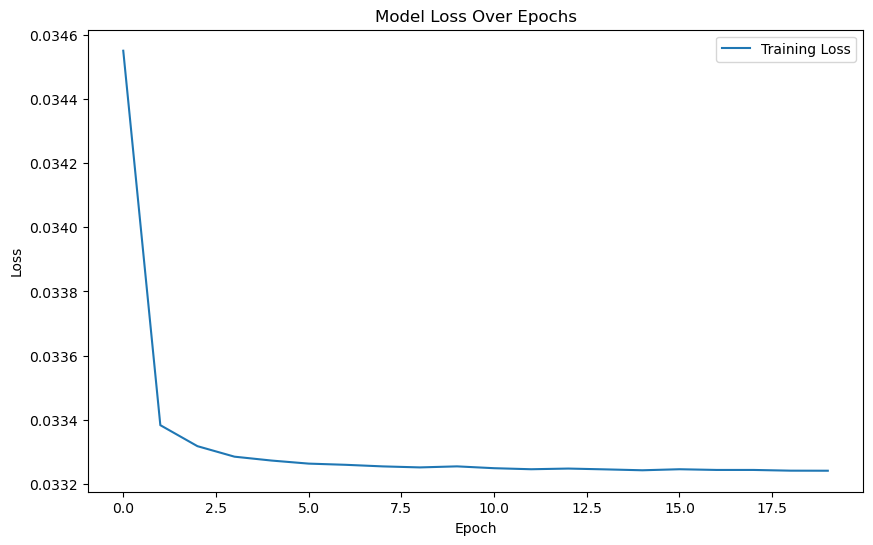

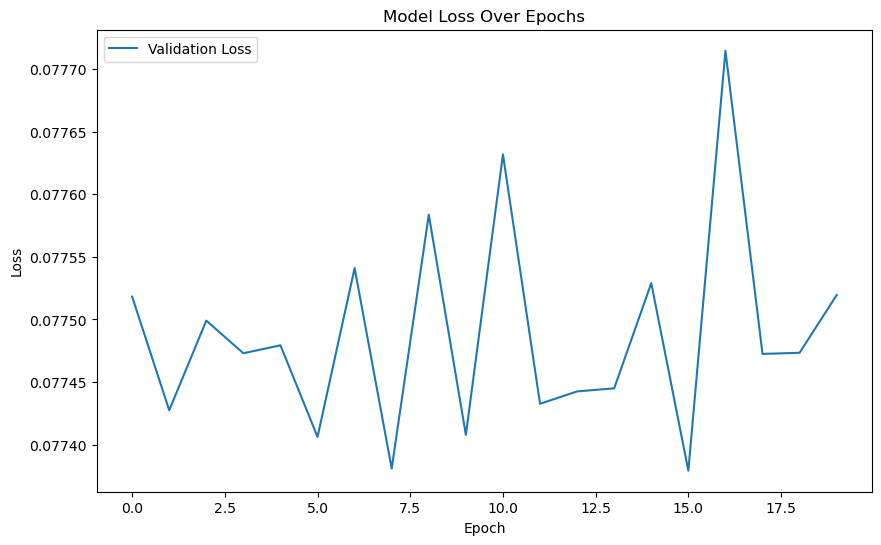

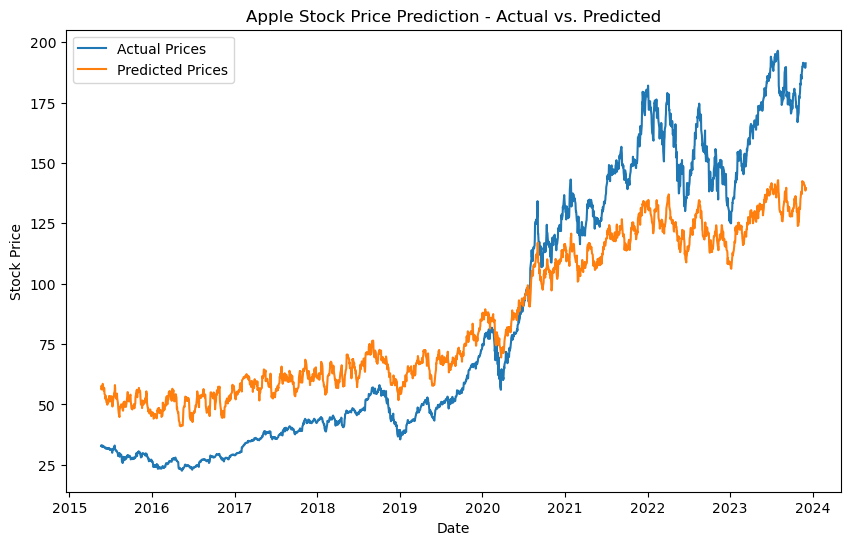

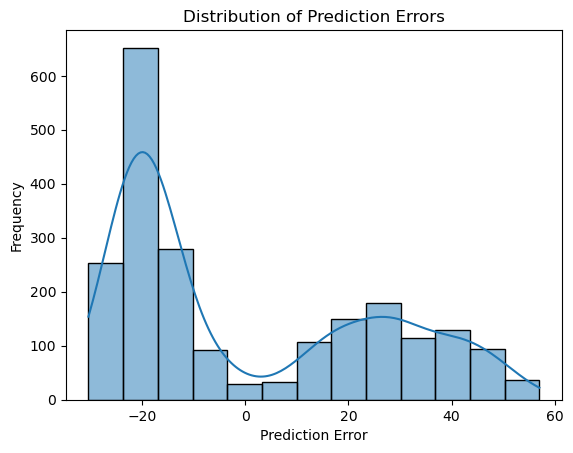

In [49]:
plot_model_results(lstm_corr.history, actual_stock_prices, corr_lstm_predictions_final, stock_data.index)

In [50]:
corr_gru = create_gru_model(look_back, features)
gru_corr = corr_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

corr_gru_predictions = corr_gru.predict(X_test)

corr_gru_predictions_reshaped = corr_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((corr_gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = corr_gru_predictions_reshaped.ravel()

corr_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
corr_gru_predictions_final = corr_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0341 - val_loss: 0.0775 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0776 - 3s/epoch - 12ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0776 - 3s/epoch - 12ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0774 - 3s/epoch - 12ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0776 - 3s/epoch - 12ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0777 - 3s/epoch - 12ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0333 - val_loss: 0.0776 - 3s/epoch - 12ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0776 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0777 - 3s/epoch - 12ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0775 - 3s/epoch - 12ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0774 - 3s/epoch - 12ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0332 - val_loss: 0.0777 - 3s/epoch - 12ms/step
Epoch 13/20
215/215 - 3s 

In [51]:
mae = mean_absolute_error(actual_stock_prices, corr_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, corr_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, corr_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 20.6930512532987, MSE: 525.0660333828968, RMSE: 22.91431939602171, R2 Score: 0.8289638646878907


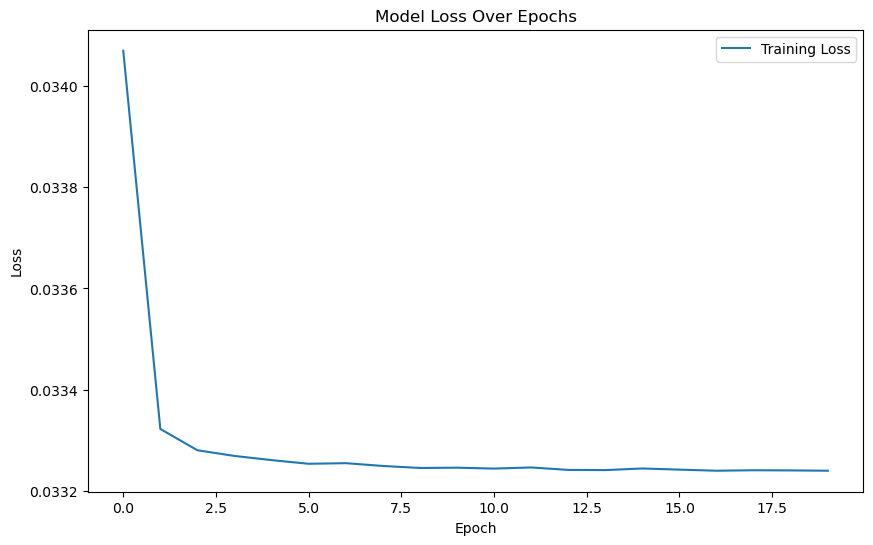

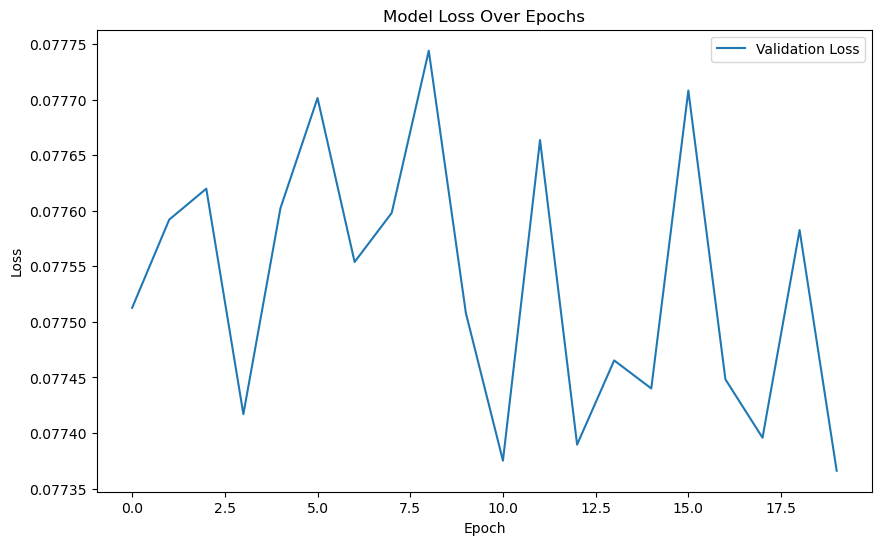

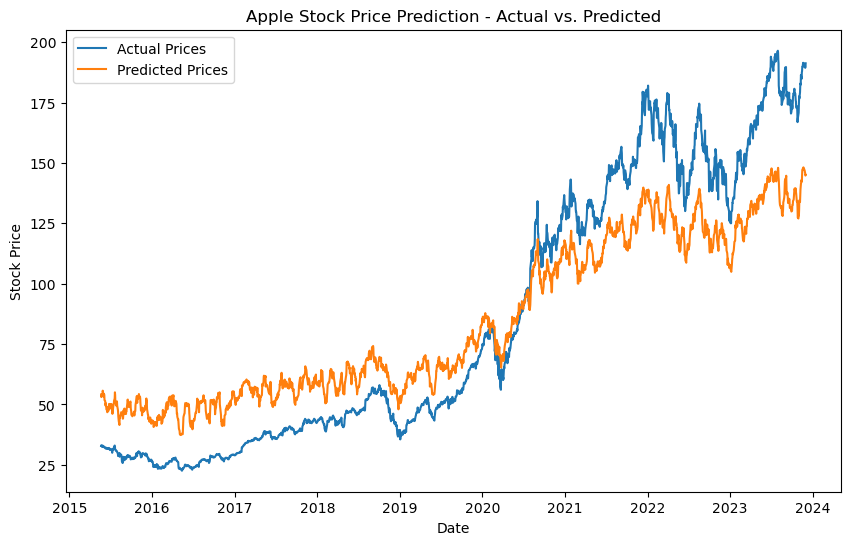

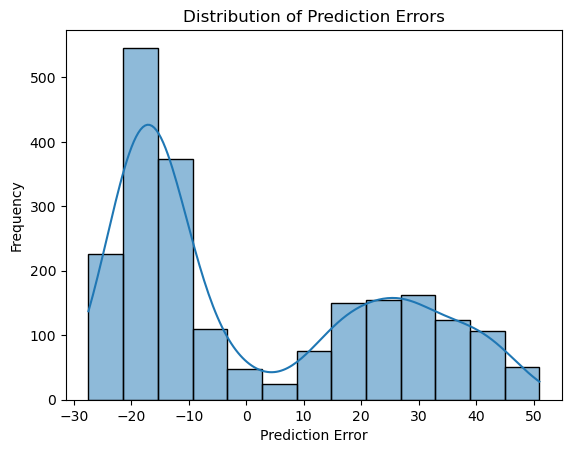

In [52]:
plot_model_results(gru_corr.history, actual_stock_prices, corr_gru_predictions_final, stock_data.index)

In [53]:
corr_mlp = create_mlp_model(look_back, features)
mlp_corr = corr_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

corr_mlp_predictions = corr_mlp.predict(X_test)

corr_mlp_predictions_reshaped = corr_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((corr_mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = corr_mlp_predictions_reshaped.ravel()

corr_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
corr_mlp_predictions_final = corr_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 0.0373 - val_loss: 0.0801 - 1s/epoch - 5ms/step
Epoch 2/20
215/215 - 1s - loss: 0.0340 - val_loss: 0.0795 - 809ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 0.0336 - val_loss: 0.0824 - 794ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 0.0334 - val_loss: 0.0777 - 806ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 0.0334 - val_loss: 0.0786 - 797ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 0.0334 - val_loss: 0.0856 - 824ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 0.0333 - val_loss: 0.0803 - 813ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 0.0333 - val_loss: 0.0778 - 816ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 0.0333 - val_loss: 0.0776 - 804ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 0.0334 - val_loss: 0.0775 - 811ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 0.0333 - val_loss: 0.0774 - 841ms/epoch - 4ms/step
Epoch 12/20
215/215 - 1s - loss: 0.0333 - val_loss: 0.0774 - 806ms/epoch - 4ms/step
Epoc

In [54]:
mae = mean_absolute_error(actual_stock_prices, corr_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, corr_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, corr_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 17.520363998541683, MSE: 381.6012006118937, RMSE: 19.534615445713122, R2 Score: 0.8756964068640796


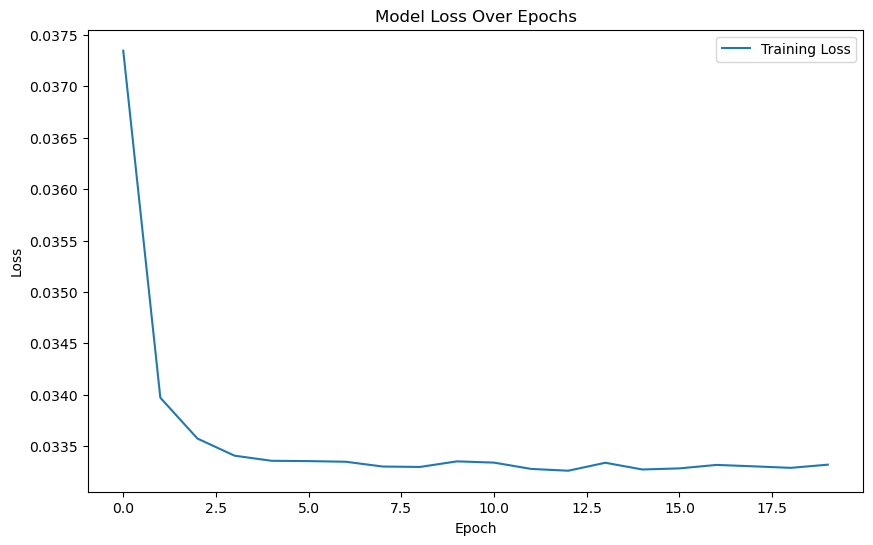

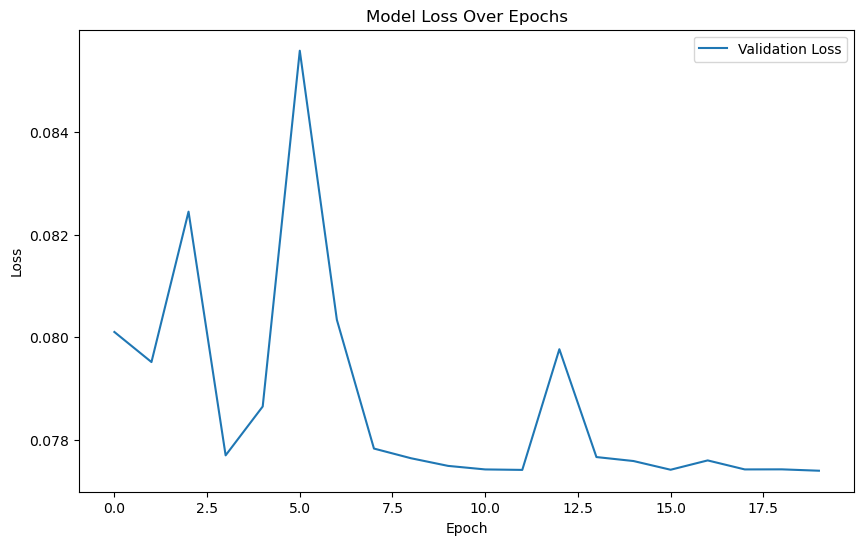

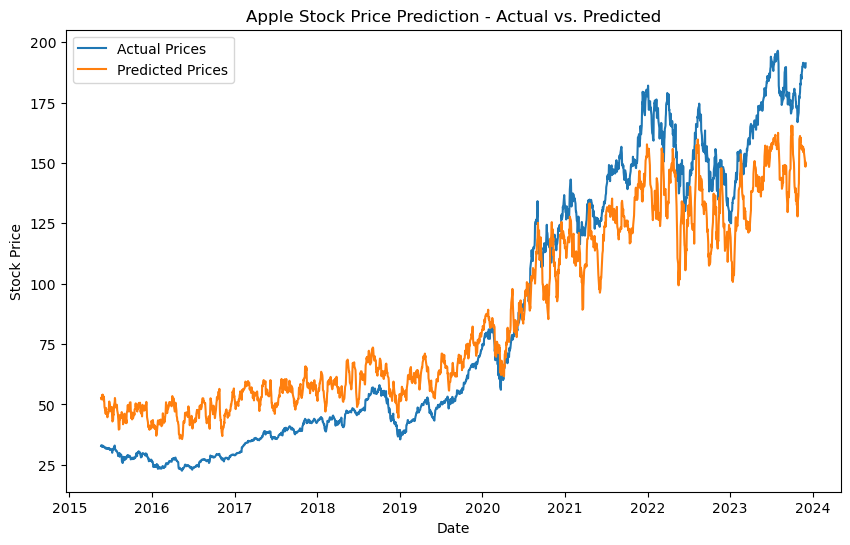

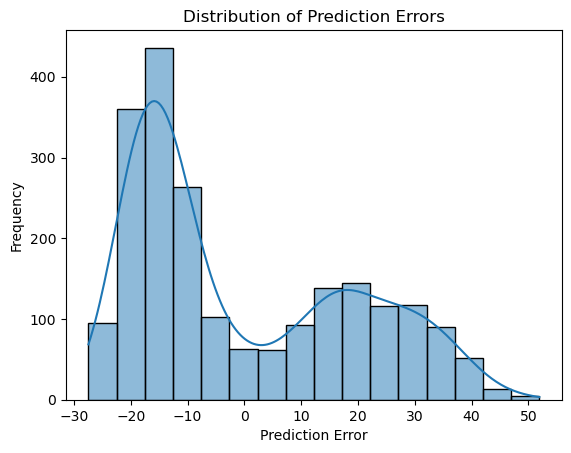

In [55]:
plot_model_results(mlp_corr.history, actual_stock_prices, corr_mlp_predictions_final, stock_data.index)

In [56]:
corr_cnn = create_cnn_model(look_back, features)
cnn_corr = corr_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

corr_cnn_predictions = corr_cnn.predict(X_test)

# Reshape predictions for inverse transform
corr_cnn_predictions_reshaped = corr_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((corr_cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = corr_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
corr_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
corr_cnn_predictions_final = corr_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 3s - loss: 0.0380 - val_loss: 0.0808 - 3s/epoch - 16ms/step
Epoch 2/20
215/215 - 2s - loss: 0.0348 - val_loss: 0.0802 - 2s/epoch - 10ms/step
Epoch 3/20
215/215 - 2s - loss: 0.0342 - val_loss: 0.0820 - 2s/epoch - 10ms/step
Epoch 4/20
215/215 - 2s - loss: 0.0339 - val_loss: 0.0829 - 2s/epoch - 10ms/step
Epoch 5/20
215/215 - 2s - loss: 0.0338 - val_loss: 0.0877 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 0.0337 - val_loss: 0.0814 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 0.0336 - val_loss: 0.0839 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 0.0335 - val_loss: 0.0847 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 0.0335 - val_loss: 0.0845 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 0.0335 - val_loss: 0.0811 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 0.0334 - val_loss: 0.0785 - 2s/epoch - 10ms/step
Epoch 12/20
215/215 - 2s - loss: 0.0334 - val_loss: 0.0777 - 2s/epoch - 10ms/step
Epoch 13/20
215/215 - 2s 

In [57]:
mae = mean_absolute_error(actual_stock_prices, corr_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, corr_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, corr_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 36.45305789074892, MSE: 1911.1881956440968, RMSE: 43.71713846587053, R2 Score: 0.3774454600861308


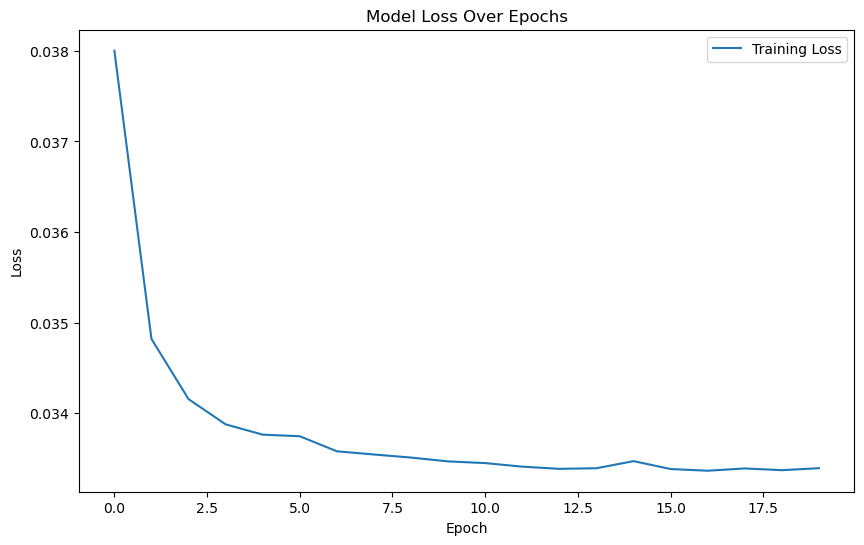

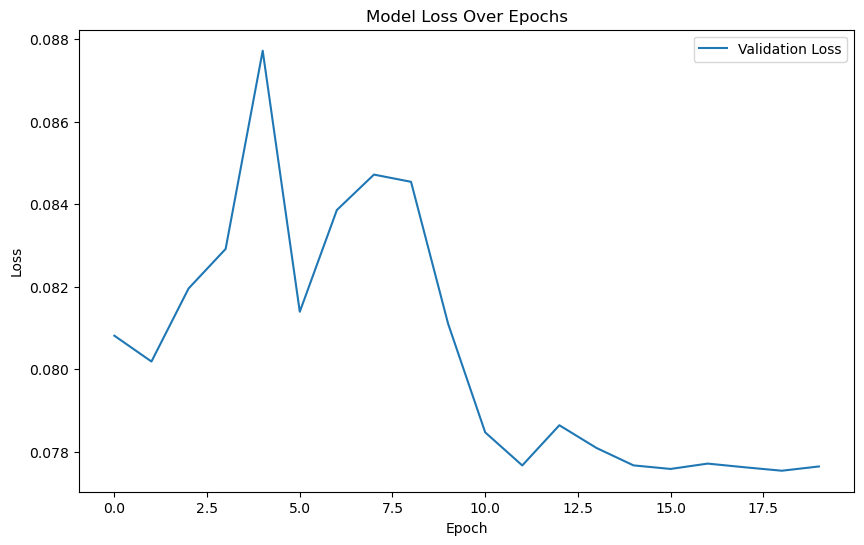

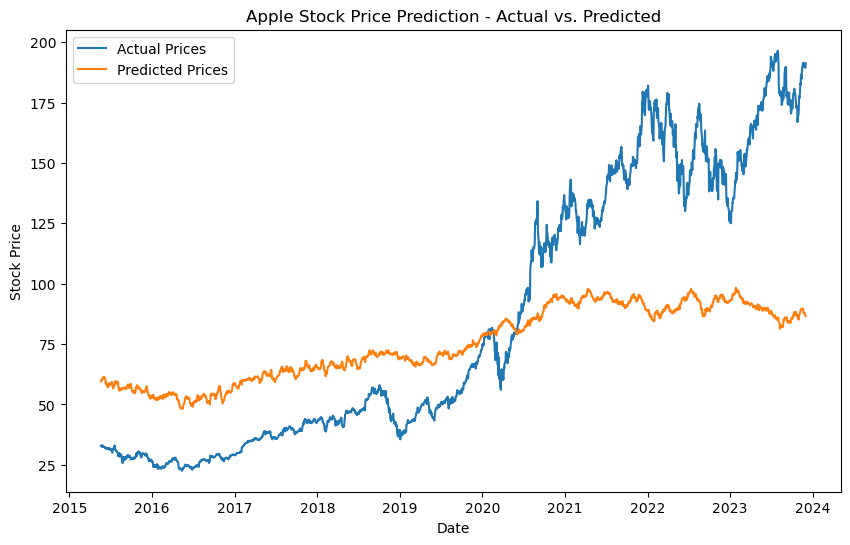

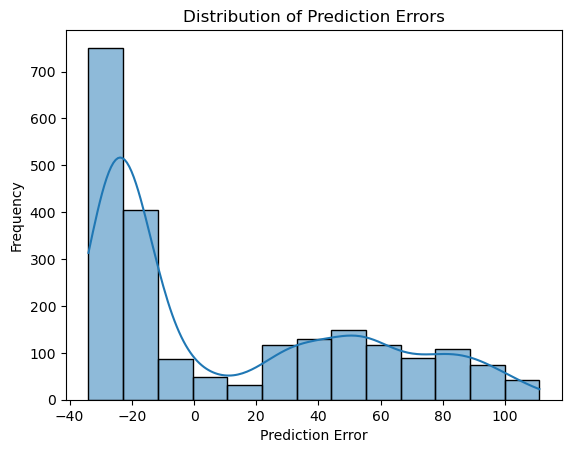

In [58]:
plot_model_results(cnn_corr.history, actual_stock_prices, corr_cnn_predictions_final, stock_data.index)

## PCA 

Principal Component Analysis (PCA) is a statistical technique used for dimensionality reduction. It transforms a set of possibly correlated variables into a set of linearly uncorrelated variables called principal components. This is achieved by orthogonal transformation. The first principal component has the highest possible variance, and each succeeding component, in turn, has the highest variance possible under the constraint that it is orthogonal to the preceding components. 

In [59]:
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import pandas as pd

# Assuming df is your original DataFrame and 'Target' is the target variable
# Dropping the 'Date' column and any rows with missing values
df_pca = df.copy()
df_pca = df.drop('Date', axis=1)

# Separating features and target variable
X = df_pca.drop('Close', axis =1)
y = df_pca['Close']

n_components = 8
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

components = pd.DataFrame(pca.components_, columns=X.columns, index=[f'PC{i+1}' for i in range(n_components)])
print(components)

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Including the explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

#pca_df = pd.concat([pca_df,y], axis=1)

             Open          High           Low     Adj Close        Volume  \
PC1  3.737022e-10  3.777753e-10  3.698118e-10  3.611753e-10  1.012705e-03   
PC2 -4.474247e-08 -4.518667e-08 -4.436202e-08 -4.425618e-08  9.999995e-01   
PC3  2.779735e-01  2.812549e-01  2.749249e-01  2.796694e-01  1.604490e-07   
PC4 -2.069987e-02 -2.075430e-02 -2.418153e-02 -2.487349e-02 -1.308402e-09   
PC5 -2.563841e-01 -2.519901e-01 -2.950529e-01 -2.846311e-01 -2.234415e-11   
PC6  1.448517e-02  7.343450e-02 -5.342932e-02  1.730255e-02 -4.055993e-10   
PC7  2.234397e-01  1.571563e-02 -9.391779e-03 -3.326798e-01  2.144471e-10   
PC8  3.099763e-01  1.293923e-01  1.225985e-01 -1.454803e-01  1.292377e-10   

           SMA_10        SMA_30        EMA_10        EMA_30  Price_Change  \
PC1  3.724436e-10  3.691401e-10  3.724492e-10  3.691866e-10  3.407226e-13   
PC2 -4.455172e-08 -4.409483e-08 -4.455867e-08 -4.412874e-08 -5.927805e-11   
PC3  2.774184e-01  2.752162e-01  2.773802e-01  2.751857e-01  1.376095e-04  

In [60]:
pca_df

PC1           PC2         PC3        PC4       PC5       PC6  \
0     -7.981452e+10 -2.181520e+08    1.378789  -6.044761  0.555448  0.034839   
1     -7.984268e+10 -2.136659e+08    2.141108  -3.904116  0.395789  0.035163   
2     -7.988656e+10 -1.978742e+08    4.814865  10.686191 -0.731220  0.060148   
3     -7.993275e+10 -1.955427e+08    5.268550  15.738607 -1.113501  0.071591   
4     -7.995654e+10 -2.179410e+08    1.700665  17.296263 -1.221364  0.087860   
...             ...           ...         ...        ...       ...       ...   
10799  8.014941e+10 -3.632950e+08  437.955394 -23.749718 -7.194036  3.304620   
10800  8.018782e+10 -3.654711e+08  439.520160 -21.140566 -7.014319  1.455032   
10801  8.014481e+10 -3.608287e+08  441.418212 -15.094167 -6.302766 -0.796584   
10802  8.019361e+10 -3.550979e+08  442.079220 -17.866761 -4.243848 -3.008744   
10803  8.023929e+10 -3.582593e+08  444.300596 -12.768771 -5.561351 -4.011407   

            PC7       PC8  
0      0.068039  0.028932  
1      0.072253  0.028177  
2      0.078175  0.017476  
3      0.081261  0.013715  
4      0.076185  0.008158  
...         ...       ...  
10799  2.341017 -1.716057  
10800  1.693762 -2.615095  
10801  3.410971 -1.408926  
10802  1.950902 -3.207252  
10803  0.919896 -3.403320  

[10804 rows x 8 columns]

In [61]:
##LSTM Model with PCA
#X = pca_df
#y = pca_df['Close']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_pca = scaler.fit_transform(X)

look_back = 60

X_seq, y_seq = create_sequences(scaled_data_pca, look_back)

# Splitting into training and testing sets
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(X.columns)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(X.columns)))

In [62]:
actual_stock_prices = y[-len(X_test):].values

In [63]:
len(actual_stock_prices)

2149

In [64]:
pca_lstm = create_lstm_model(look_back, X.columns)
lstm_pca = pca_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

pca_lstm_predictions = pca_lstm.predict(X_test)

# Reshape predictions for inverse transform
pca_lstm_predictions_reshaped = pca_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((pca_lstm_predictions_reshaped.shape[0], len(X.columns)))
dummy_array[:, 0] = pca_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
pca_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
pca_lstm_predictions_final = pca_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0575 - val_loss: 0.0686 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0568 - val_loss: 0.0683 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0682 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0682 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0681 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0683 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0682 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0685 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0684 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0681 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0682 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0681 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [65]:
mae = mean_absolute_error(actual_stock_prices, pca_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, pca_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, pca_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 27.9362068467558, MSE: 1093.9038642723779, RMSE: 33.07421751564771, R2 Score: 0.643669410221225


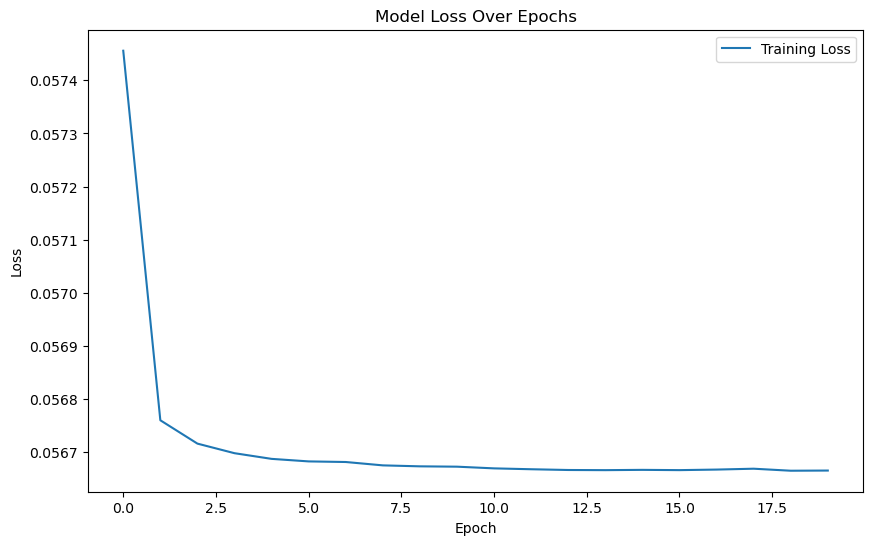

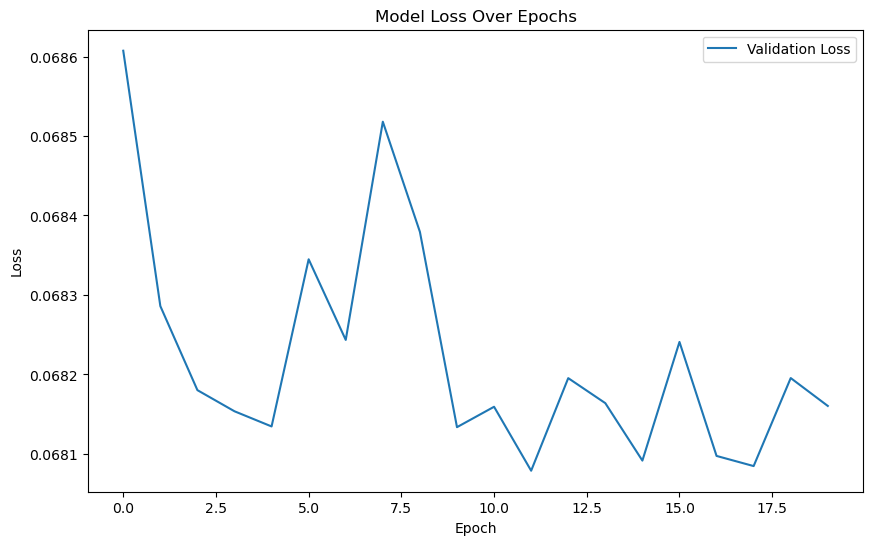

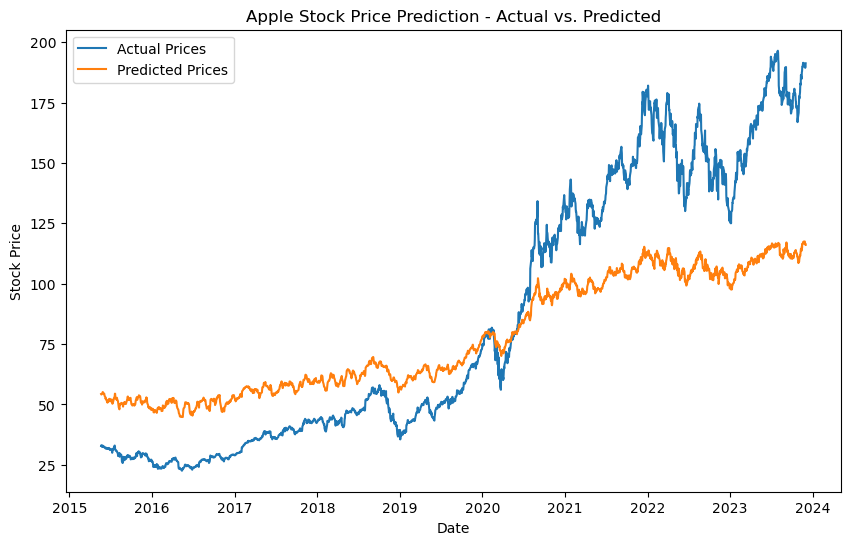

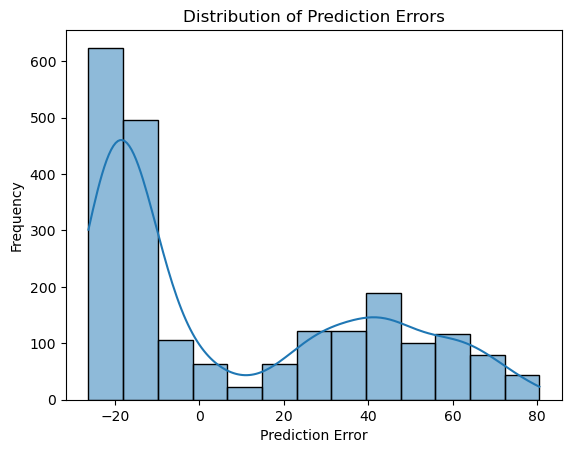

In [66]:
plot_model_results(lstm_pca.history, actual_stock_prices, pca_lstm_predictions_final, stock_data.index)

In [67]:
pca_gru = create_gru_model(look_back, X.columns)
gru_pca = pca_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

pca_gru_predictions = pca_gru.predict(X_test)

# Reshape predictions for inverse transform
pca_gru_predictions_reshaped = pca_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((pca_gru_predictions_reshaped.shape[0], len(X.columns)))
dummy_array[:, 0] = pca_gru_predictions_reshaped.ravel()
# Apply inverse transformation
pca_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
pca_gru_predictions_final = pca_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0588 - val_loss: 0.0689 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0569 - val_loss: 0.0686 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0568 - val_loss: 0.0685 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0688 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0692 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0702 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0682 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0688 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0681 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0683 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0681 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0567 - val_loss: 0.0683 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [68]:
mae = mean_absolute_error(actual_stock_prices, pca_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, pca_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, pca_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 21.537754197365114, MSE: 546.9715906952471, RMSE: 23.387423772088432, R2 Score: 0.8218283014894423


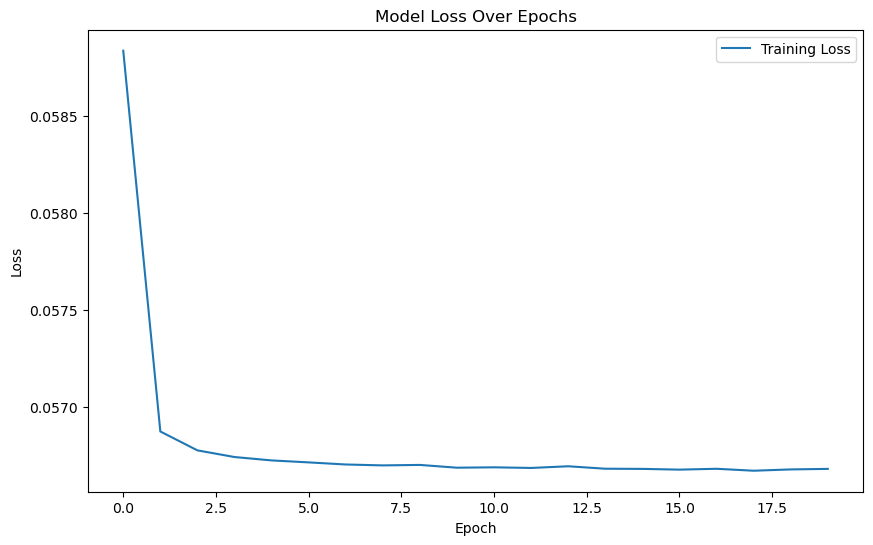

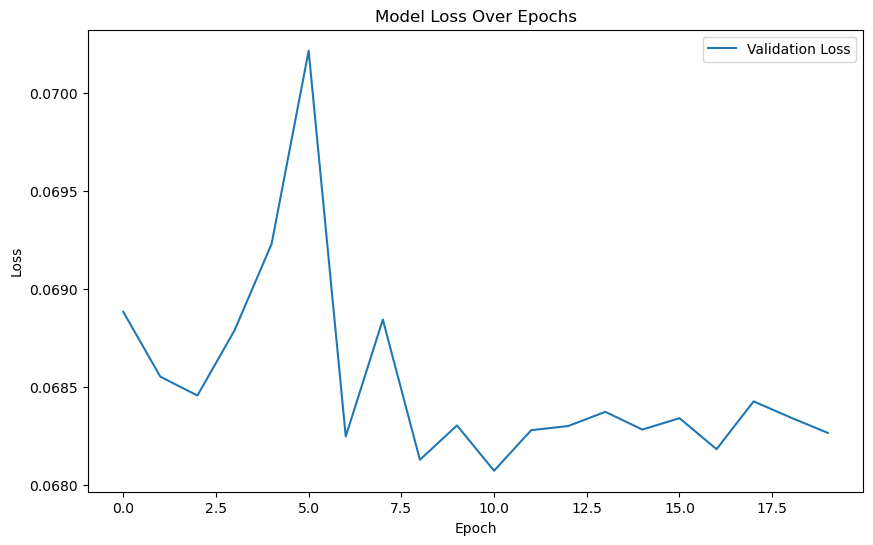

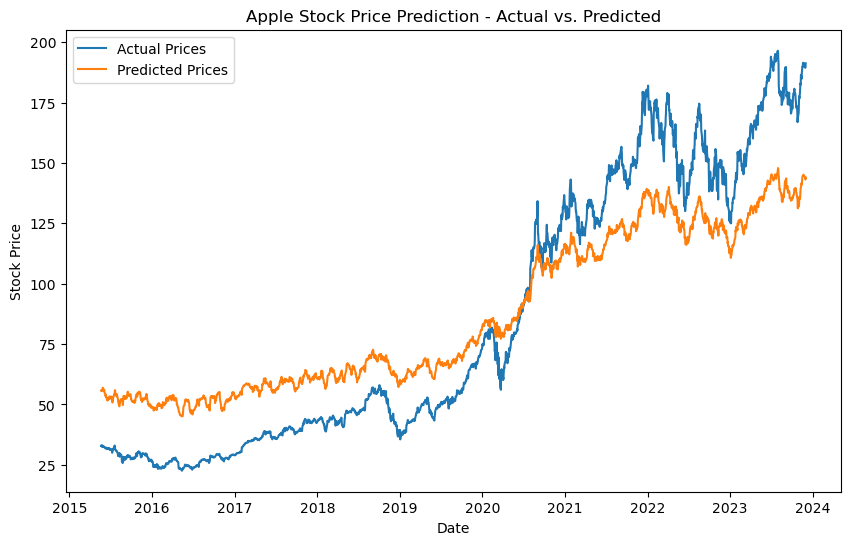

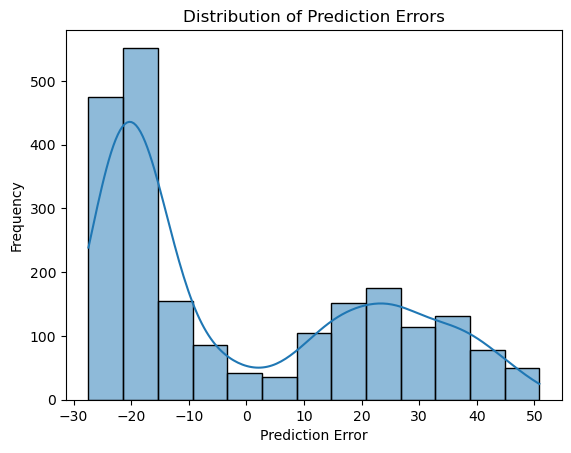

In [69]:
plot_model_results(gru_pca.history, actual_stock_prices, pca_gru_predictions_final, stock_data.index)

In [70]:
pca_mlp = create_mlp_model(look_back, X.columns)
mlp_pca = pca_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

pca_mlp_predictions = pca_mlp.predict(X_test)

# Reshape predictions for inverse transform
pca_mlp_predictions_reshaped = pca_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((pca_mlp_predictions_reshaped.shape[0], len(X.columns)))
dummy_array[:, 0] = pca_mlp_predictions_reshaped.ravel()
# Apply inverse transformation
pca_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
pca_mlp_predictions_final = pca_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 0.0725 - val_loss: 0.0698 - 1s/epoch - 6ms/step
Epoch 2/20
215/215 - 1s - loss: 0.0580 - val_loss: 0.0689 - 815ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 0.0576 - val_loss: 0.0689 - 822ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 0.0574 - val_loss: 0.0693 - 827ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 0.0573 - val_loss: 0.0693 - 819ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 0.0573 - val_loss: 0.0684 - 820ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 0.0572 - val_loss: 0.0690 - 819ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 0.0571 - val_loss: 0.0686 - 814ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 0.0571 - val_loss: 0.0684 - 812ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 0.0571 - val_loss: 0.0687 - 830ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 0.0570 - val_loss: 0.0684 - 828ms/epoch - 4ms/step
Epoch 12/20
215/215 - 1s - loss: 0.0570 - val_loss: 0.0683 - 827ms/epoch - 4ms/step
Epoc

In [71]:
mae = mean_absolute_error(actual_stock_prices, pca_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, pca_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, pca_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 27.956974643269422, MSE: 876.9996107394427, RMSE: 29.614179217723436, R2 Score: 0.7143242667504373


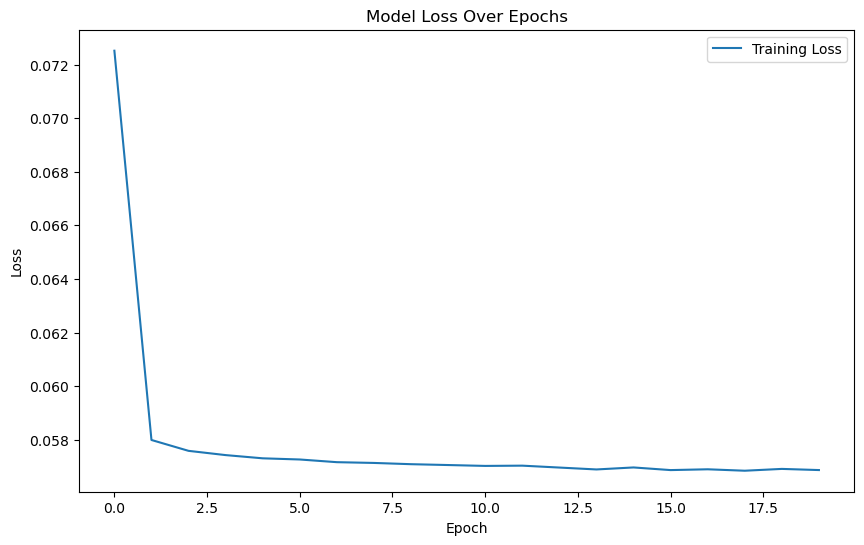

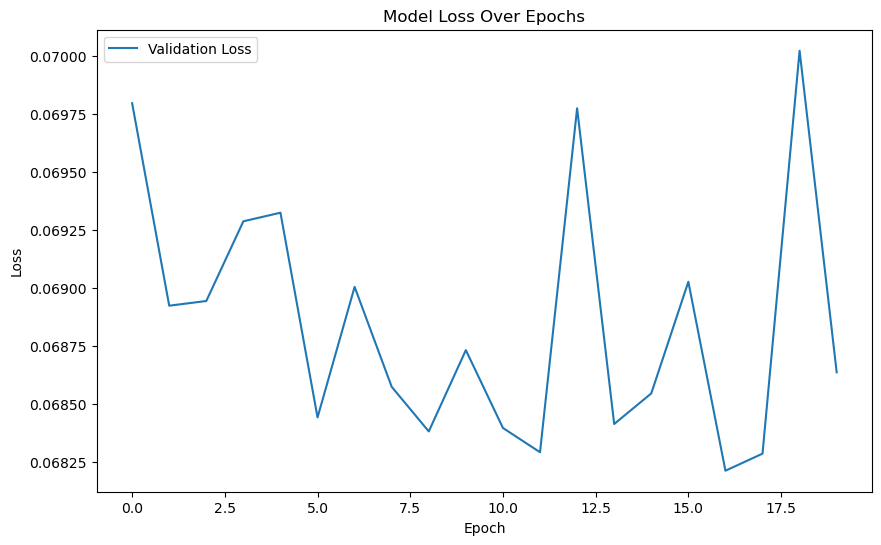

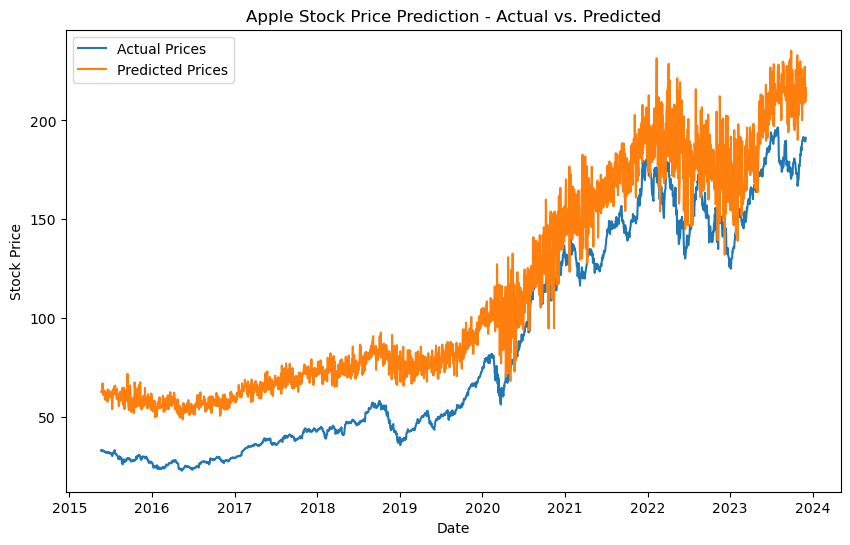

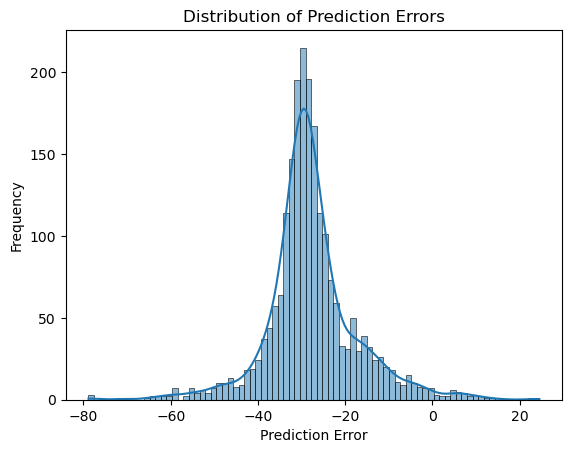

In [72]:
plot_model_results(mlp_pca.history, actual_stock_prices, pca_mlp_predictions_final, stock_data.index)

In [73]:
pca_cnn = create_cnn_model(look_back, X.columns)
cnn_pca = pca_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

pca_cnn_predictions = pca_cnn.predict(X_test)

# Reshape predictions for inverse transform
pca_cnn_predictions_reshaped = pca_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((pca_cnn_predictions_reshaped.shape[0], len(X.columns)))
dummy_array[:, 0] = pca_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
pca_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
pca_cnn_predictions_final = pca_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0663 - val_loss: 0.0689 - 4s/epoch - 16ms/step
Epoch 2/20
215/215 - 2s - loss: 0.0578 - val_loss: 0.0700 - 2s/epoch - 10ms/step
Epoch 3/20
215/215 - 2s - loss: 0.0571 - val_loss: 0.0695 - 2s/epoch - 10ms/step
Epoch 4/20
215/215 - 2s - loss: 0.0569 - val_loss: 0.0702 - 2s/epoch - 10ms/step
Epoch 5/20
215/215 - 2s - loss: 0.0579 - val_loss: 0.0716 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 0.0570 - val_loss: 0.0717 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 0.0569 - val_loss: 0.0690 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 0.0568 - val_loss: 0.0691 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 0.0568 - val_loss: 0.0688 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 0.0568 - val_loss: 0.0686 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 0.0568 - val_loss: 0.0684 - 2s/epoch - 10ms/step
Epoch 12/20
215/215 - 2s - loss: 0.0568 - val_loss: 0.0692 - 2s/epoch - 10ms/step
Epoch 13/20
215/215 - 2s 

In [74]:
mae = mean_absolute_error(actual_stock_prices, pca_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, pca_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, pca_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 65.46170213415367, MSE: 8352.603654726936, RMSE: 91.39257986689584, R2 Score: -1.7207950201884619


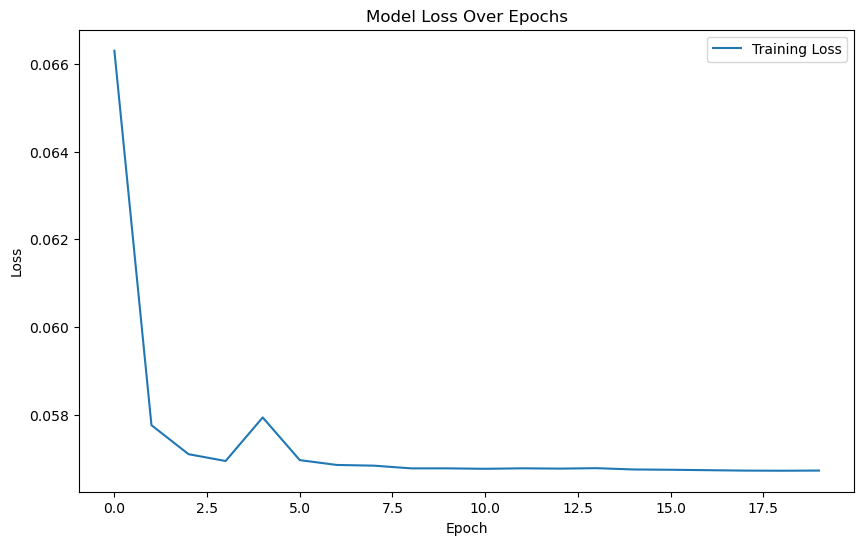

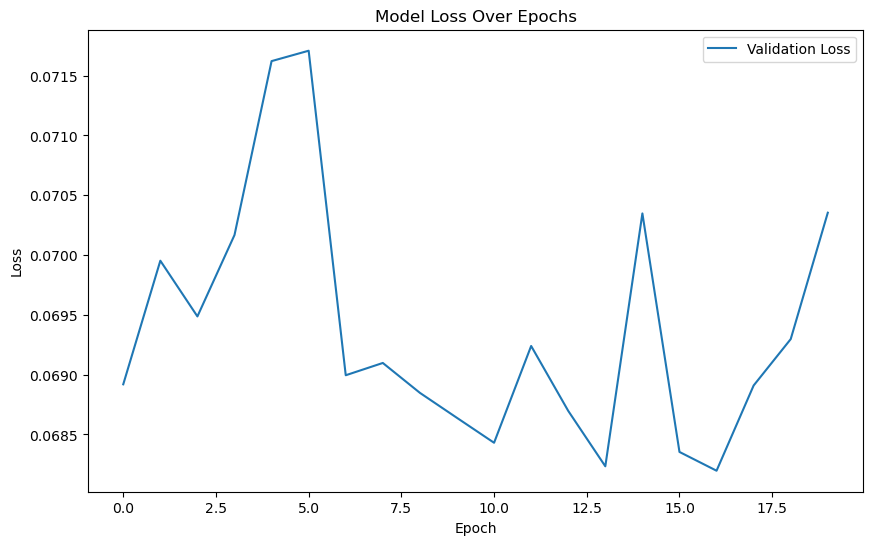

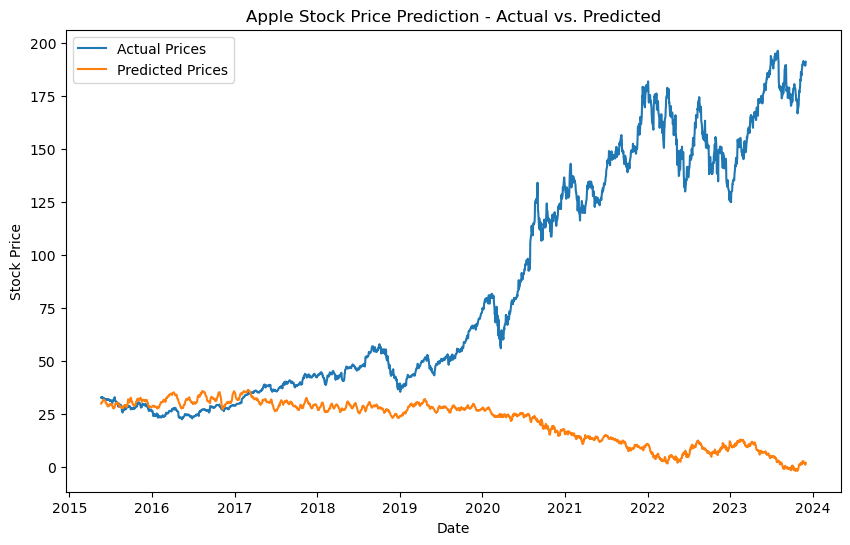

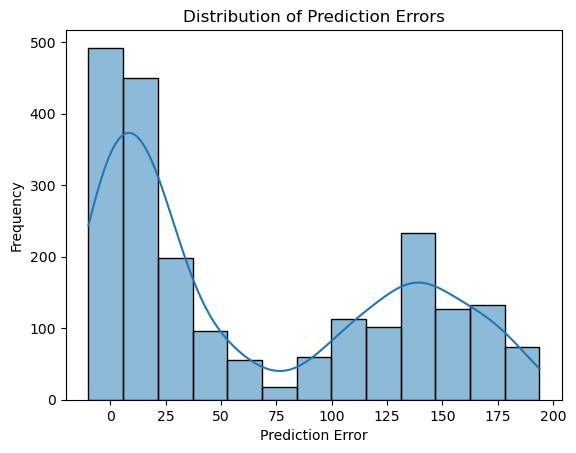

In [75]:
plot_model_results(cnn_pca.history, actual_stock_prices, pca_cnn_predictions_final, stock_data.index)

## Random Forest Regressor

Random Forest Regressor, an ensemble learning method, is highly effective in feature reduction for regression tasks. It operates by constructing multiple decision trees during training and outputting the mean prediction of the individual trees. Feature reduction is achieved through its ability to identify and rank the most important features in a dataset. This ranking is based on how much each feature decreases the impurity of the split, measured by a metric like the Gini impurity or mean squared error. By focusing on the most influential features, Random Forest helps in simplifying models, reducing overfitting, and improving generalization.

In [76]:
from sklearn.ensemble import RandomForestRegressor

# Assuming 'Close' is the target variable
df_rfe = df_pca.copy()
y = df_rfe['Close']
X = df_rfe.drop(['Close'], axis=1)

# Initialize the RandomForestRegressor
rf = RandomForestRegressor()

# Fit the model to the entire dataset
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Print or visualize feature importances
print(feature_importances)

                  importance
Adj Close       2.361811e-01
Weighted_Close  2.285156e-01
High            2.144103e-01
Typical_Price   2.106083e-01
Low             5.568757e-02
Open            5.192814e-02
Upper_Band      6.529446e-04
EMA_30          6.122261e-04
SMA_30          4.402552e-04
Middle_Band     3.848046e-04
EMA_10          3.633281e-04
SMA_10          2.065940e-04
Lower_Band      3.536211e-06
OBV             1.343521e-06
Volatility      7.940945e-07
Pct_Change      6.834370e-07
Price_Range     6.609850e-07
RSI             4.879533e-07
Price_Change    4.878810e-07
Volume          4.591436e-07
Log_Returns     4.336221e-07


In [77]:
features = ["Open", "High", "Low","Adj Close","Weighted_Close","Typical_Price"]
X = df_rfe[features]
y = df_rfe['Close']

In [78]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[4.80696411e-04, 4.75869589e-04, 4.80200644e-04, 3.70341984e-04,
        4.78751421e-04, 4.79222817e-04],
       [4.55098875e-04, 4.50529086e-04, 4.57335408e-04, 3.52707873e-04,
        4.55277752e-04, 4.55500447e-04],
       [4.29501263e-04, 4.25188507e-04, 4.31611998e-04, 3.32869232e-04,
        4.29670078e-04, 4.29880247e-04],
       ...,
       [9.72781475e-01, 9.69018119e-01, 9.67679308e-01, 9.66527153e-01,
        9.68321868e-01, 9.69781583e-01],
       [9.67378572e-01, 9.60086915e-01, 9.63684045e-01, 9.69488023e-01,
        9.66549953e-01, 9.66431563e-01],
       [9.69876174e-01, 9.66343793e-01, 9.69011036e-01, 9.76073431e-01,
        9.72745353e-01, 9.72502440e-01]])

In [79]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [80]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [81]:
rfr_lstm = create_lstm_model(look_back, features)
lstm_rfr = rfr_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfr_lstm_predictions = rfr_lstm.predict(X_test)

# Reshape predictions for inverse transform
rfr_lstm_predictions_reshaped = rfr_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfr_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfr_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
rfr_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
rfr_lstm_predictions_final = rfr_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 2.4773e-06 - val_loss: 2.2277e-05 - 4s/epoch - 18ms/step
Epoch 2/20
215/215 - 3s - loss: 4.4059e-07 - val_loss: 2.0742e-05 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 3.4868e-07 - val_loss: 2.6642e-05 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 3.7656e-07 - val_loss: 2.0031e-05 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 3.3983e-07 - val_loss: 2.0988e-05 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 3.3058e-07 - val_loss: 2.1558e-05 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 3.3626e-07 - val_loss: 2.2815e-05 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 2.9061e-07 - val_loss: 1.9351e-05 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 2.8288e-07 - val_loss: 1.9264e-05 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 2.9754e-07 - val_loss: 1.9254e-05 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 2.6987e-07 - val_loss: 2.0732e-05 - 3s/epoch - 13ms/step
Epoch 12/20
215/215

In [82]:
actual_stock_prices = df_rfe["Close"][-len(X_test):].values

In [83]:
mae = mean_absolute_error(actual_stock_prices, rfr_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfr_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfr_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 2.8343411288032025, MSE: 20.9543088066144, RMSE: 4.577587662362611, R2 Score: 0.9931742985290266


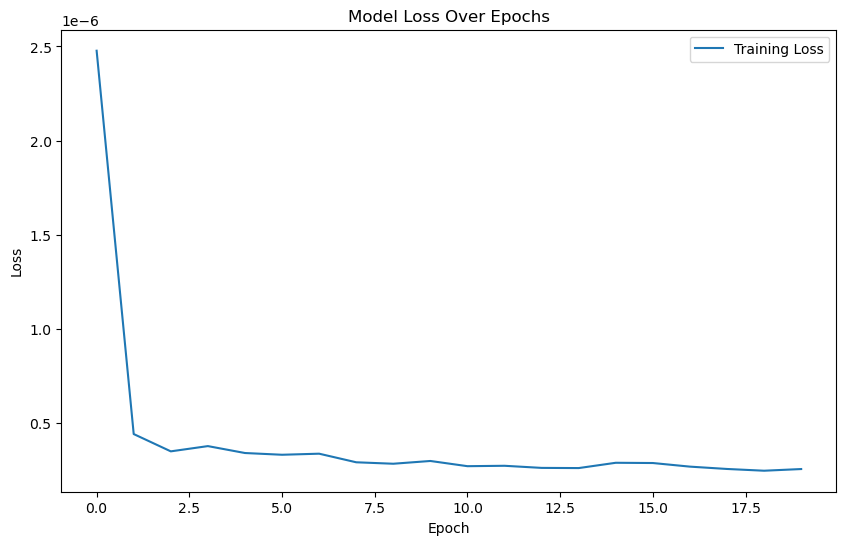

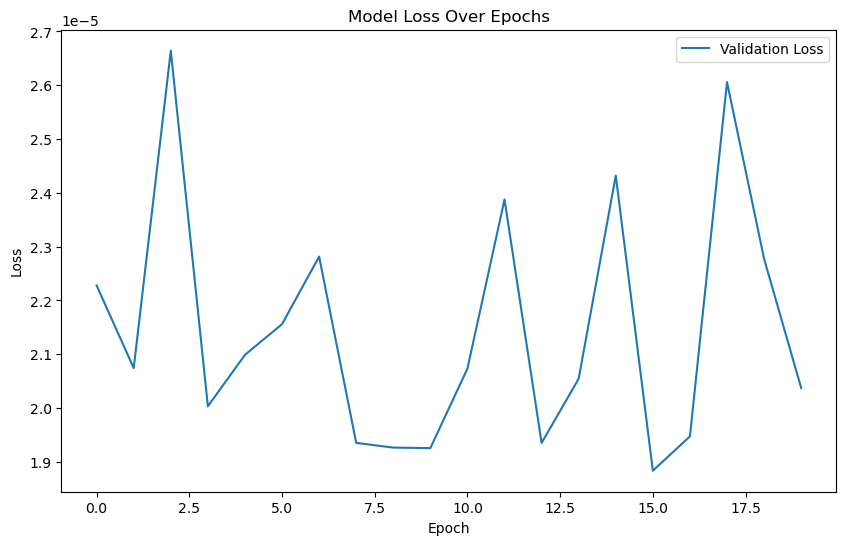

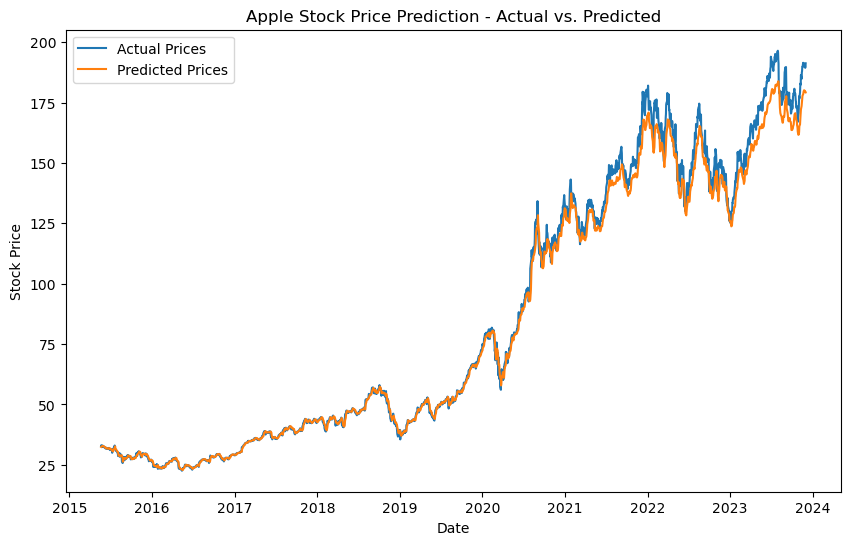

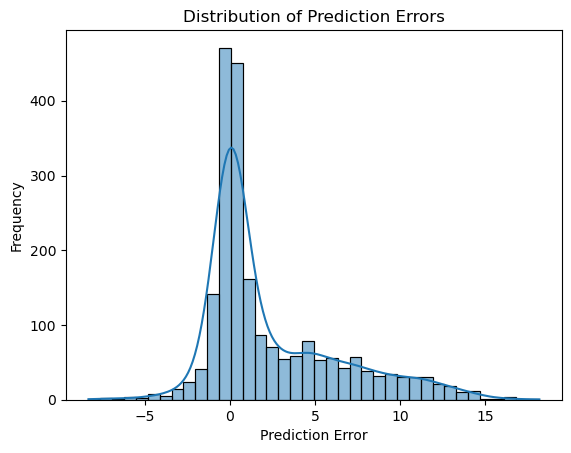

In [84]:
plot_model_results(lstm_rfr.history, actual_stock_prices, rfr_lstm_predictions_final, stock_data.index)

In [85]:
rfr_gru = create_gru_model(look_back, features)
gru_rfr = rfr_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfr_gru_predictions = rfr_gru.predict(X_test)

# Reshape predictions for inverse transform
rfr_gru_predictions_reshaped = rfr_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfr_gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfr_gru_predictions_reshaped.ravel()
# Apply inverse transformation
rfr_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
rfr_gru_predictions_final = rfr_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 2.4411e-06 - val_loss: 4.6687e-05 - 4s/epoch - 18ms/step
Epoch 2/20
215/215 - 3s - loss: 4.9274e-07 - val_loss: 4.4588e-05 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 3.5974e-07 - val_loss: 2.9824e-05 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 2.8568e-07 - val_loss: 6.7441e-05 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 3.0793e-07 - val_loss: 2.1703e-05 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 2.6803e-07 - val_loss: 2.6861e-05 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 2.8243e-07 - val_loss: 2.6838e-05 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 2.5700e-07 - val_loss: 5.2864e-05 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 2.5801e-07 - val_loss: 3.4367e-05 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 2.6777e-07 - val_loss: 3.8740e-05 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 2.4337e-07 - val_loss: 3.4474e-05 - 3s/epoch - 13ms/step
Epoch 12/20
215/215

In [86]:
mae = mean_absolute_error(actual_stock_prices, rfr_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfr_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfr_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 3.9915732229918883, MSE: 24.95364903953775, RMSE: 4.99536275354831, R2 Score: 0.9918715448680625


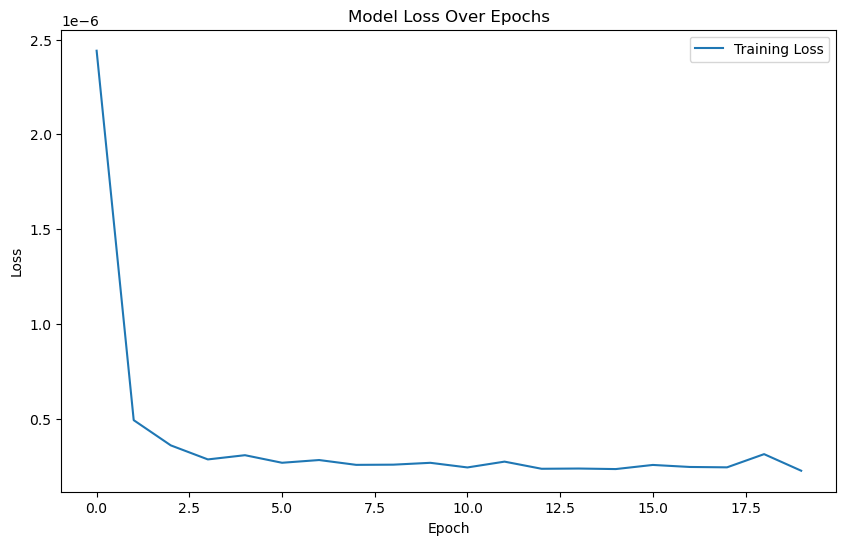

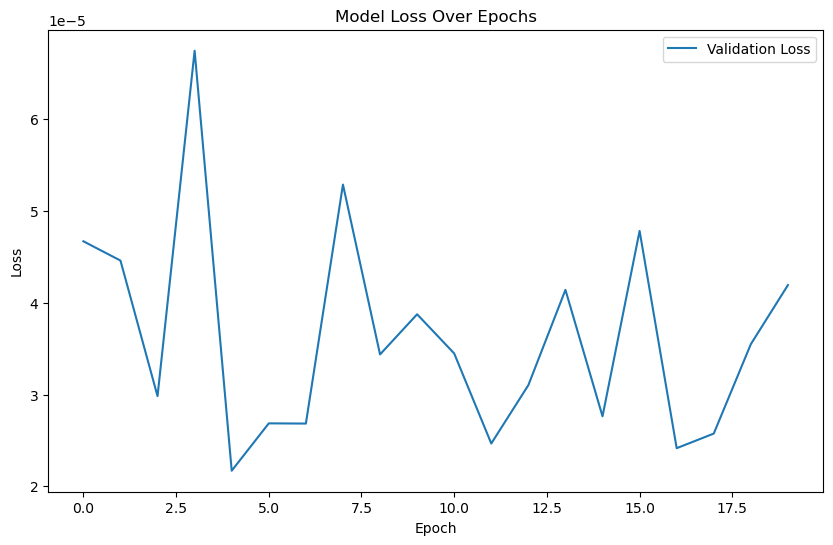

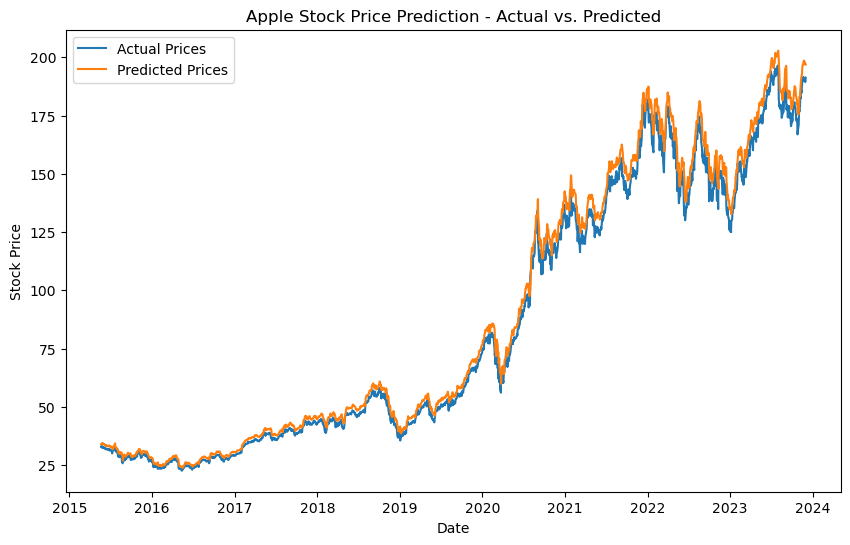

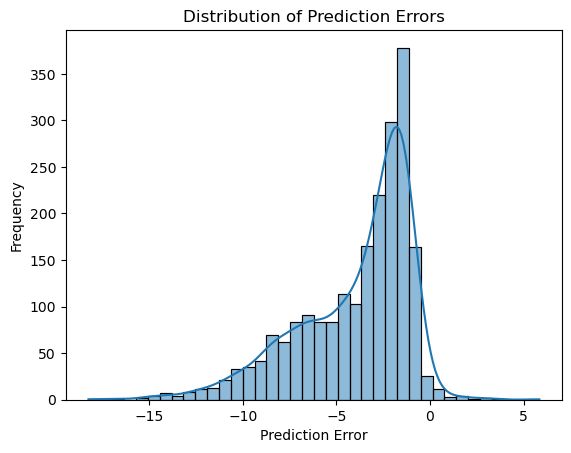

In [87]:
plot_model_results(gru_rfr.history, actual_stock_prices, rfr_gru_predictions_final, stock_data.index)

In [88]:
rfr_mlp = create_mlp_model(look_back, features)
mlp_rfr = rfr_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfr_mlp_predictions = rfr_mlp.predict(X_test)

# Reshape predictions for inverse transform
rfr_mlp_predictions_reshaped = rfr_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfr_mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfr_mlp_predictions_reshaped.ravel()
# Apply inverse transformation
rfr_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
rfr_mlp_predictions_final = rfr_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 3.3765e-06 - val_loss: 3.7666e-05 - 1s/epoch - 6ms/step
Epoch 2/20
215/215 - 1s - loss: 7.9011e-07 - val_loss: 5.9823e-05 - 812ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 1.1027e-06 - val_loss: 3.3319e-05 - 794ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 6.3717e-07 - val_loss: 3.2197e-05 - 825ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 6.2542e-07 - val_loss: 3.0478e-05 - 829ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 5.0591e-07 - val_loss: 3.1938e-05 - 807ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 7.3662e-07 - val_loss: 4.4062e-05 - 829ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 6.5089e-07 - val_loss: 2.8844e-05 - 796ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 4.4454e-07 - val_loss: 2.9540e-05 - 814ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 5.0689e-07 - val_loss: 5.6611e-05 - 804ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 6.7608e-07 - val_loss: 3.8061e-05 - 836ms/epoch - 4ms/step


In [89]:
mae = mean_absolute_error(actual_stock_prices, rfr_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfr_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfr_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 9.437378007968224, MSE: 152.32747911222563, RMSE: 12.34210189198848, R2 Score: 0.9503805204055316


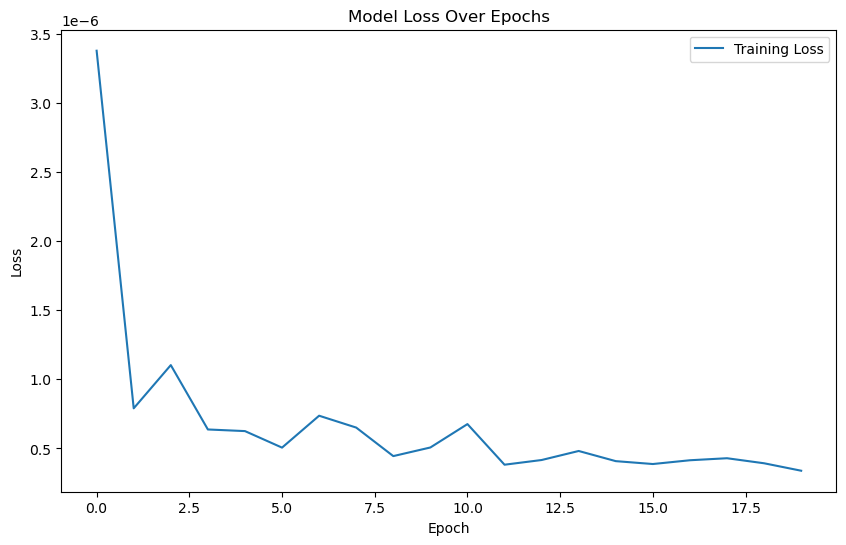

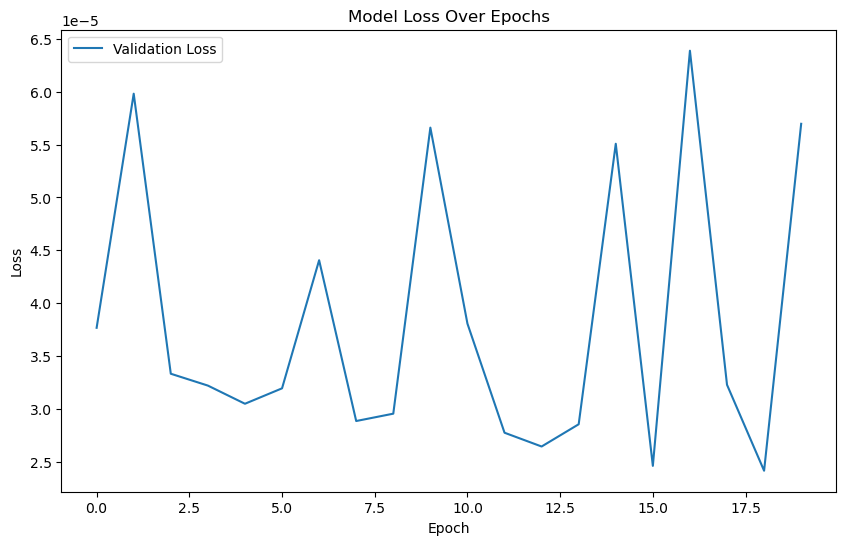

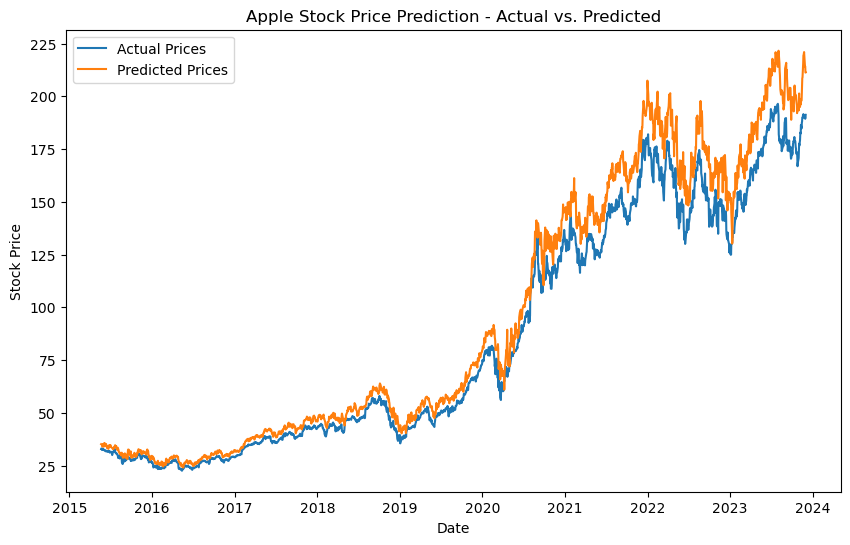

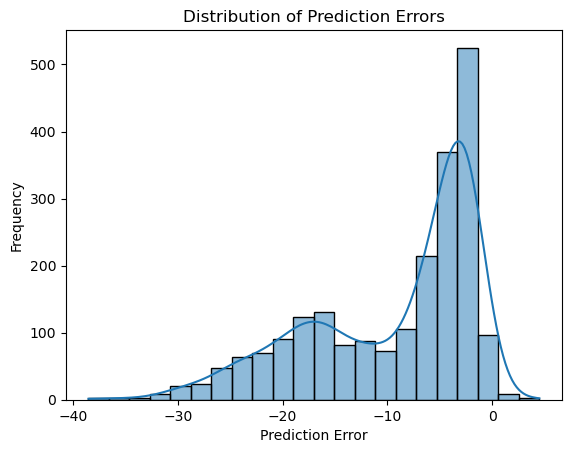

In [90]:
plot_model_results(mlp_rfr.history, actual_stock_prices, rfr_mlp_predictions_final, stock_data.index)

In [91]:
rfr_cnn = create_cnn_model(look_back, features)
cnn_rfr = rfr_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfr_cnn_predictions = rfr_cnn.predict(X_test)

# Reshape predictions for inverse transform
rfr_cnn_predictions_reshaped = rfr_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfr_cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfr_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
rfr_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
rfr_cnn_predictions_final = rfr_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 6.3205e-05 - val_loss: 1.0842e-04 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 2s - loss: 1.1480e-05 - val_loss: 4.6800e-04 - 2s/epoch - 10ms/step
Epoch 3/20
215/215 - 2s - loss: 5.8926e-06 - val_loss: 8.4909e-05 - 2s/epoch - 10ms/step
Epoch 4/20
215/215 - 2s - loss: 3.2302e-06 - val_loss: 2.9464e-04 - 2s/epoch - 11ms/step
Epoch 5/20
215/215 - 2s - loss: 2.0996e-06 - val_loss: 5.2385e-04 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 2.4718e-06 - val_loss: 2.8311e-04 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 3.9979e-06 - val_loss: 4.2972e-04 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 2.2785e-06 - val_loss: 8.7053e-04 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 3.0366e-06 - val_loss: 7.5208e-04 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 1.4391e-06 - val_loss: 6.0434e-04 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 1.3106e-06 - val_loss: 7.1261e-04 - 2s/epoch - 11ms/step
Epoch 12/20
215/215

In [92]:
mae = mean_absolute_error(actual_stock_prices, rfr_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfr_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfr_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 38.99056344650143, MSE: 2283.244354803142, RMSE: 47.7833062355792, R2 Score: 0.2562510892150195


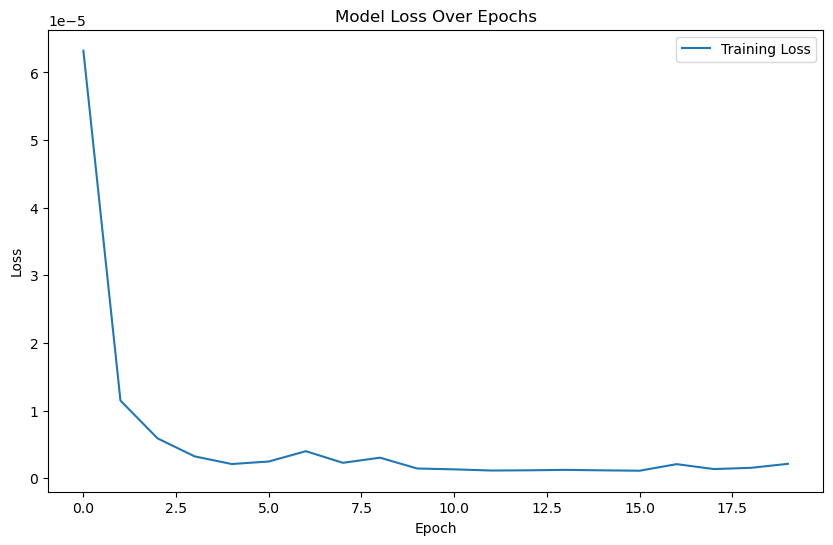

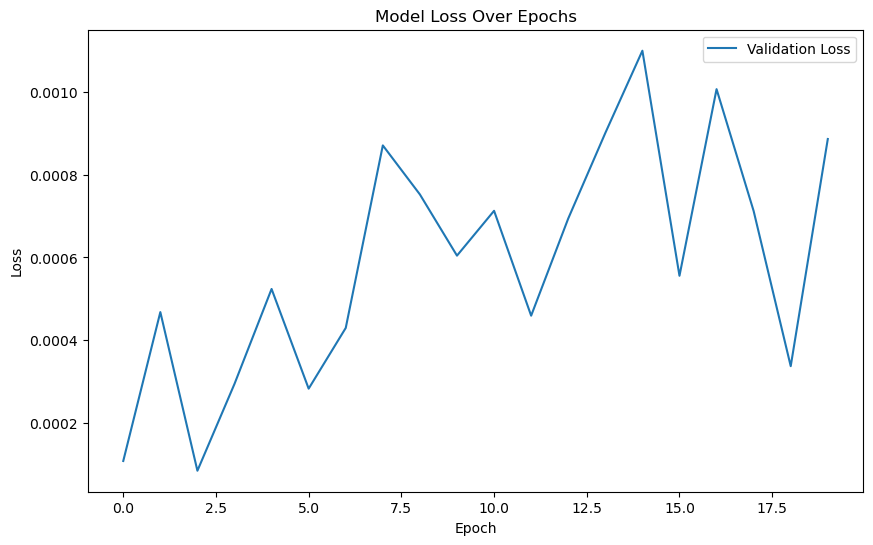

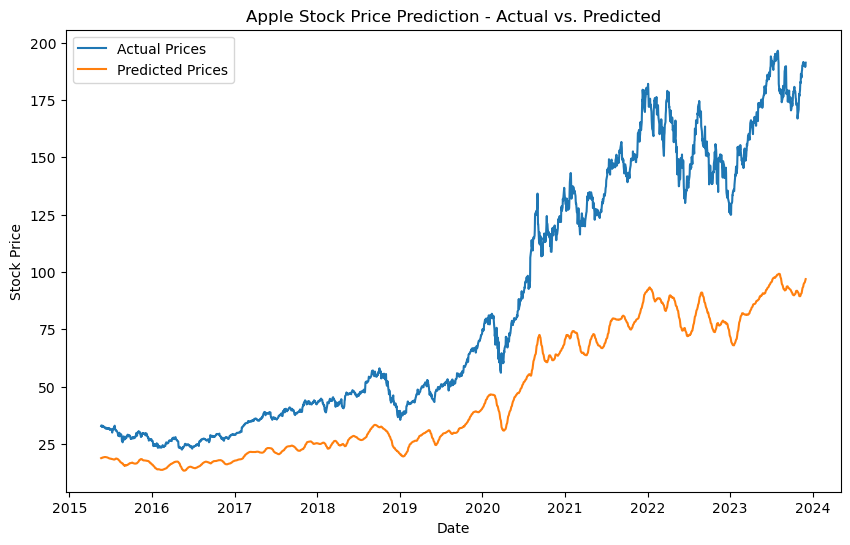

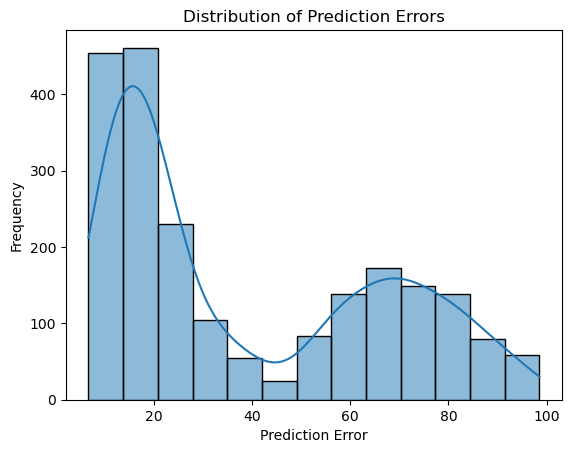

In [93]:
plot_model_results(cnn_rfr.history, actual_stock_prices, rfr_cnn_predictions_final, stock_data.index)

## Lasso CV

LassoCV, short for Lasso Cross-Validation, is a method used in machine learning for feature selection and regularization. It applies Lasso (Least Absolute Shrinkage and Selection Operator) regression, which adds a penalty equal to the absolute value of the magnitude of coefficients to the loss function. This results in some coefficients being exactly zeroed out, effectively reducing the number of features. LassoCV automates the process of finding the optimal penalty parameter (alpha) by using cross-validation, ensuring the model is neither overfitting nor underfitting. This technique is particularly useful in scenarios with high-dimensionality datasets, as it helps in enhancing model interpretability and performance by keeping only the most significant features.

In [94]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Store feature names before scaling
feature_names = X.columns

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit LassoCV model
lasso = LassoCV(cv=5, max_iter=100000).fit(X_scaled, y)  # Increased max_iter

# Create DataFrame for coefficients using the stored feature names
lasso_coef = pd.DataFrame(lasso.coef_, index=feature_names, columns=['Coefficient'])

# Filter to show only non-zero coefficients
print(lasso_coef[lasso_coef['Coefficient'] != 0])


                Coefficient
High              20.378838
Low                7.986748
Adj Close          5.769761
Weighted_Close     7.241446


In [95]:
features = ["Open", "High", "Low", "Adj Close","EMA_30","Price_Change"]
X = df[features]
y = df['Close']

In [96]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.47519339, -0.4751405 , -0.47510009, -0.46222419, -0.47487397,
        -0.02243108],
       [-0.47531476, -0.47526052, -0.47520911, -0.46230842, -0.4748772 ,
        -0.02642498],
       [-0.47543613, -0.47538054, -0.47533176, -0.46240318, -0.47488813,
        -0.02709063],
       ...,
       [ 4.13484523,  4.1121241 ,  4.13635773,  4.15276212,  4.017543  ,
        -1.24980501],
       [ 4.10922806,  4.06982362,  4.11730892,  4.16690514,  4.02697005,
         0.67079548],
       [ 4.12107012,  4.0994578 ,  4.14270721,  4.19836129,  4.03782277,
         1.51777606]])

In [97]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [98]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [99]:
lasso_lstm = create_lstm_model(look_back, features)
lstm_lasso = lasso_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

lasso_lstm_predictions = lasso_lstm.predict(X_test)

# Reshape predictions for inverse transform
lasso_lstm_predictions_reshaped = lasso_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((lasso_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = lasso_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
lasso_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
lasso_lstm_predictions_final = lasso_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0302 - val_loss: 0.0218 - 4s/epoch - 19ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [100]:
actual_stock_prices = df["Close"][-len(X_test):].values

In [101]:
mae = mean_absolute_error(actual_stock_prices, lasso_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, lasso_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, lasso_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 13.210503694870082, MSE: 245.77421090270758, RMSE: 15.677187595442863, R2 Score: 0.9199409816678658


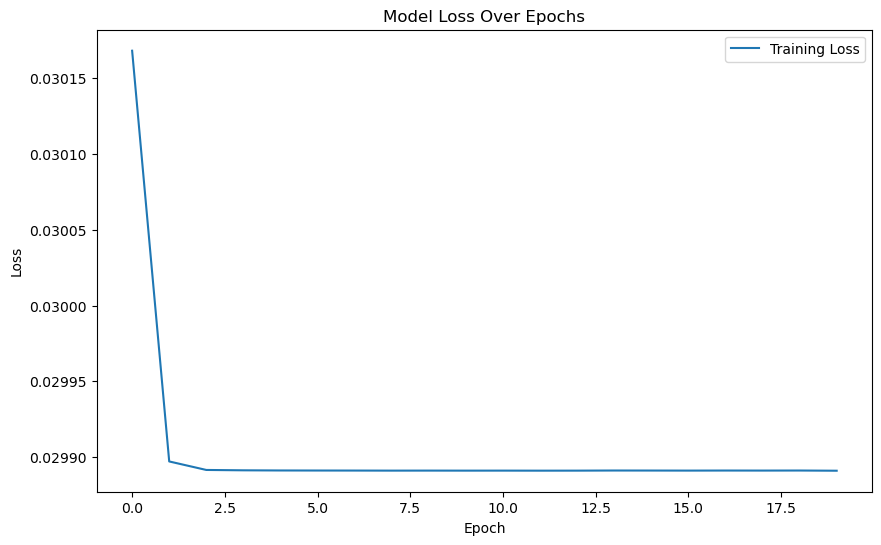

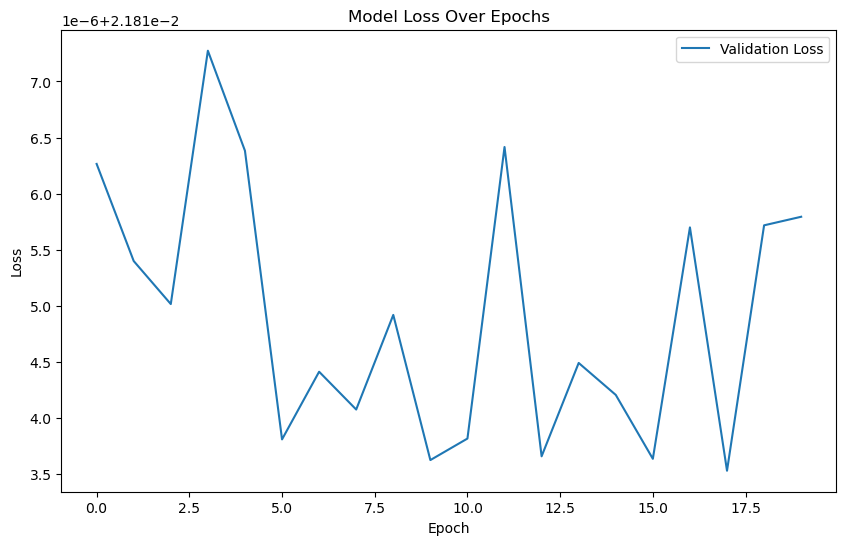

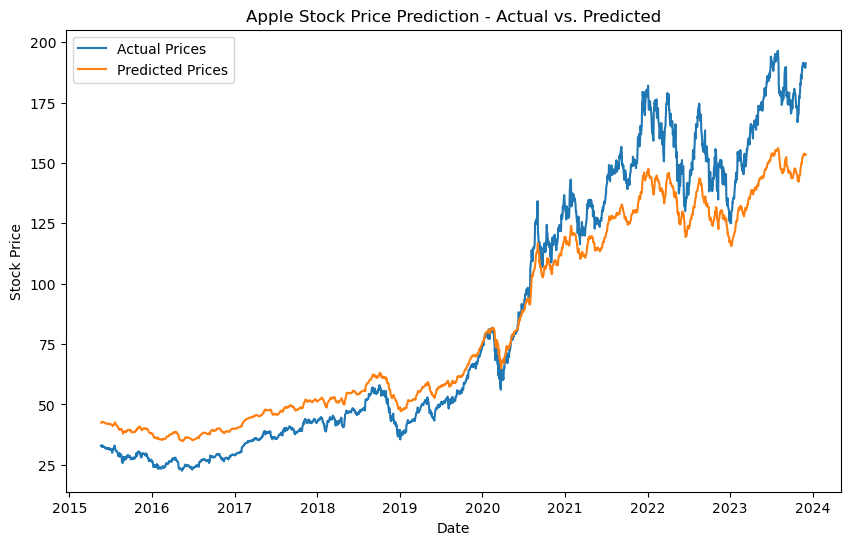

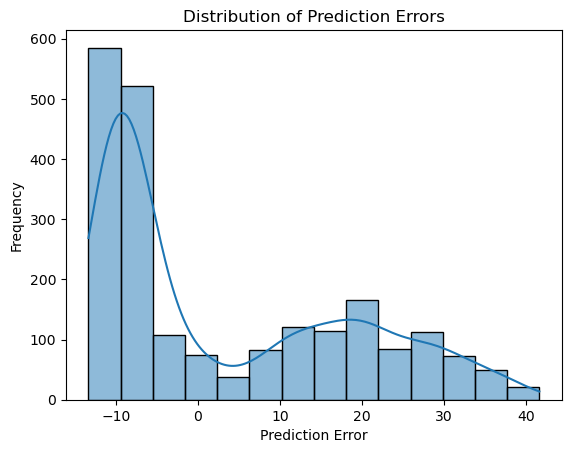

In [102]:
plot_model_results(lstm_lasso.history, actual_stock_prices, lasso_lstm_predictions_final, stock_data.index)

In [103]:
lasso_gru = create_gru_model(look_back, features)
gru_lasso = lasso_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

lasso_gru_predictions = lasso_gru.predict(X_test)

# Reshape predictions for inverse transform
lasso_gru_predictions_reshaped = lasso_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((lasso_gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = lasso_gru_predictions_reshaped.ravel()
# Apply inverse transformation
lasso_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
lasso_gru_predictions_final = lasso_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0304 - val_loss: 0.0218 - 4s/epoch - 18ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 12ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 12ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0299 - val_loss: 0.0218 - 3s/epoch - 12ms/step
Epoch 13/20
215/215 - 3s 

In [104]:
mae = mean_absolute_error(actual_stock_prices, lasso_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, lasso_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, lasso_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 11.397797638012062, MSE: 170.39889765332512, RMSE: 13.053692874176454, R2 Score: 0.9444938977897752


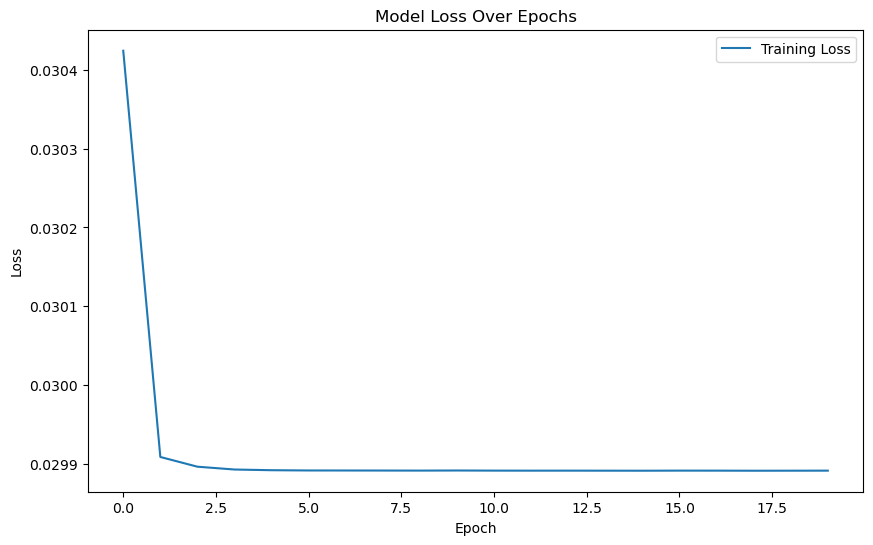

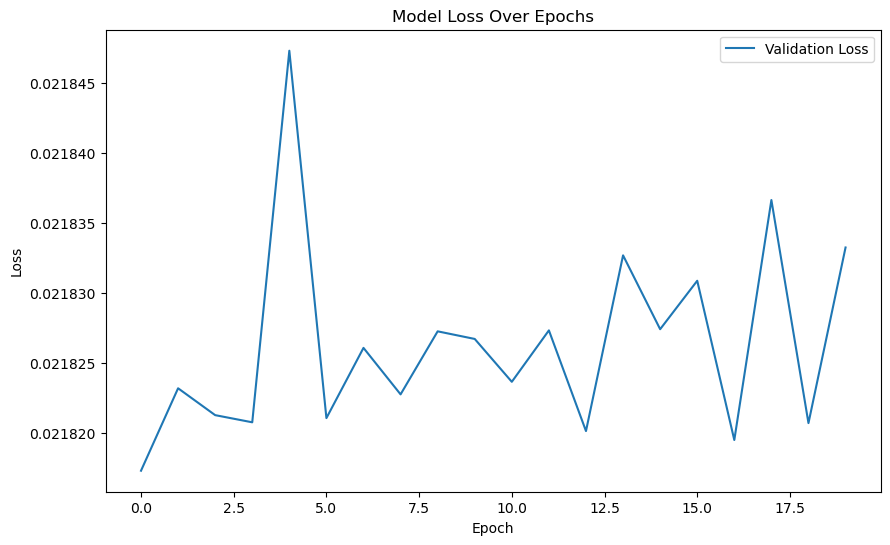

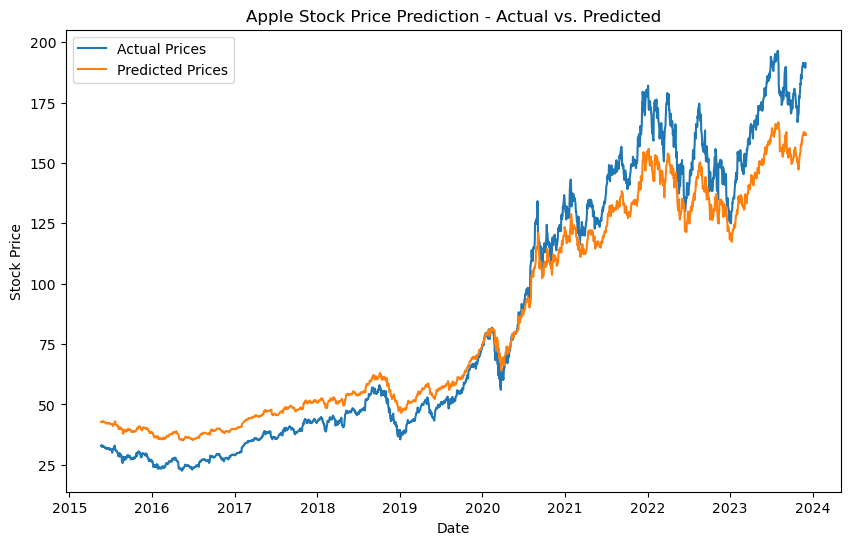

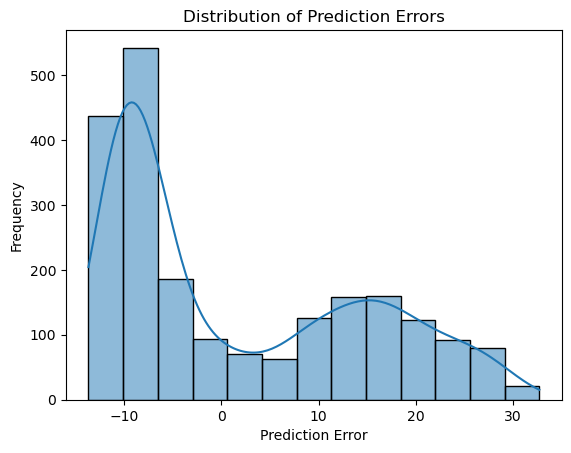

In [105]:
plot_model_results(gru_lasso.history, actual_stock_prices, lasso_gru_predictions_final, stock_data.index)

In [106]:
lasso_mlp = create_mlp_model(look_back, features)
mlp_lasso = lasso_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

lasso_mlp_predictions = lasso_mlp.predict(X_test)

# Reshape predictions for inverse transform
lasso_mlp_predictions_reshaped = lasso_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((lasso_mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = lasso_mlp_predictions_reshaped.ravel()
# Apply inverse transformation
lasso_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
lasso_mlp_predictions_final = lasso_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 0.0328 - val_loss: 0.0219 - 1s/epoch - 5ms/step
Epoch 2/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 803ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0220 - 790ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 770ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 775ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 775ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0221 - 789ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 778ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 797ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 789ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 790ms/epoch - 4ms/step
Epoch 12/20
215/215 - 1s - loss: 0.0299 - val_loss: 0.0219 - 781ms/epoch - 4ms/step
Epoc

In [107]:
mae = mean_absolute_error(actual_stock_prices, lasso_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, lasso_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, lasso_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 14.006367151229421, MSE: 343.4837791107714, RMSE: 18.533315383675188, R2 Score: 0.8881128574571814


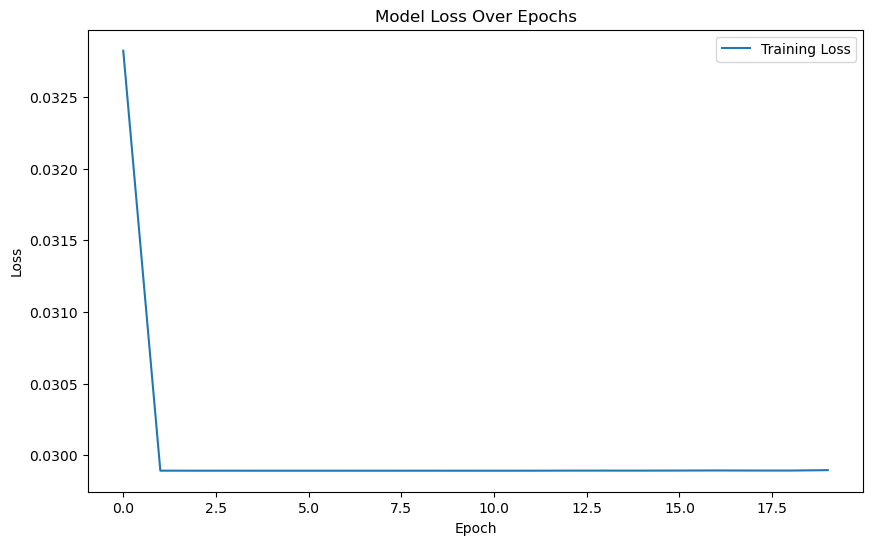

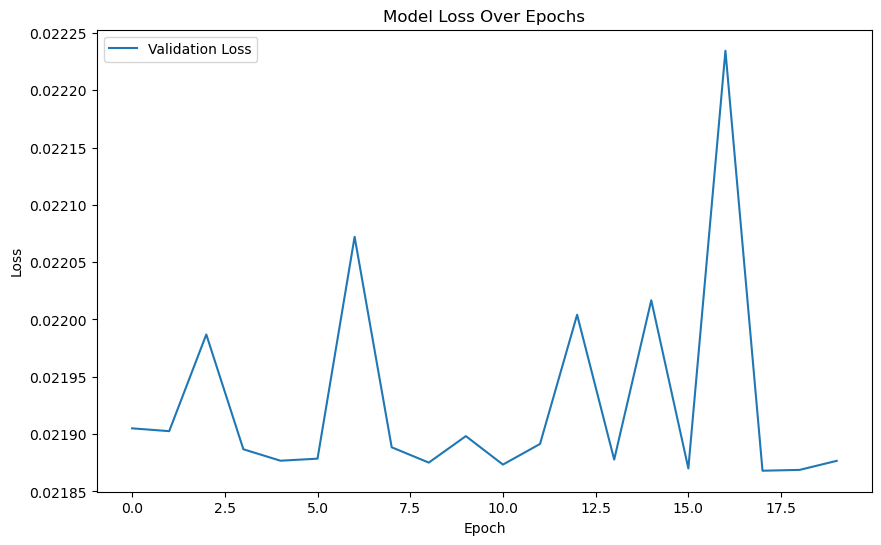

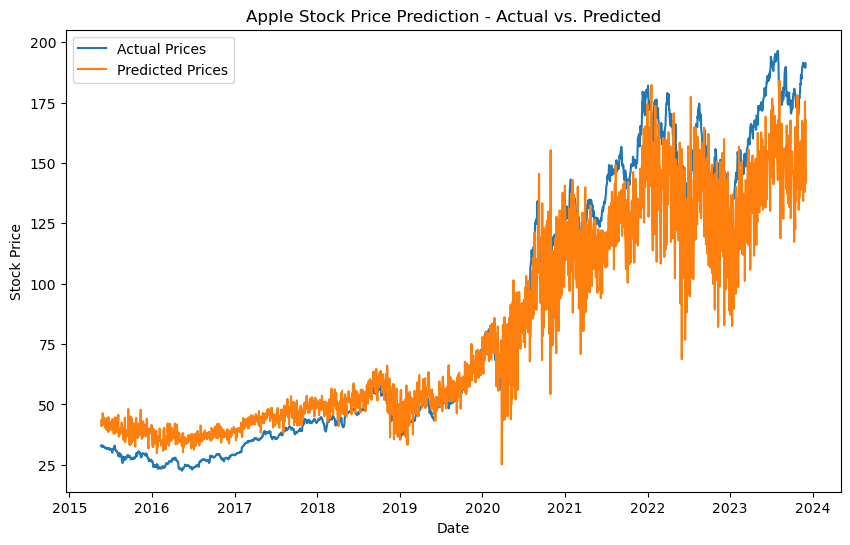

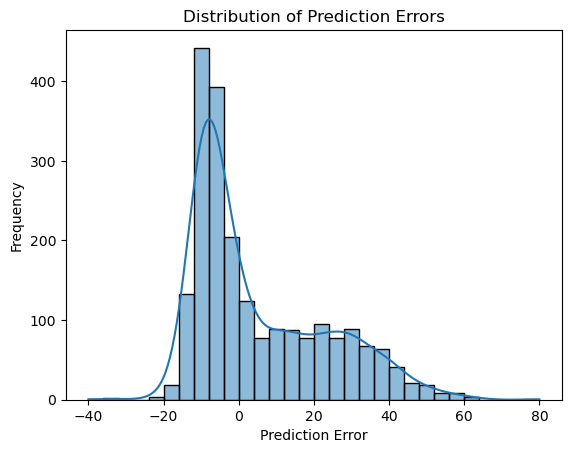

In [108]:
plot_model_results(mlp_lasso.history, actual_stock_prices, lasso_mlp_predictions_final, stock_data.index)

In [109]:
lasso_cnn = create_cnn_model(look_back, features)
cnn_lasso = lasso_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

lasso_cnn_predictions = lasso_cnn.predict(X_test)

# Reshape predictions for inverse transform
lasso_cnn_predictions_reshaped = lasso_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((lasso_cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = lasso_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
lasso_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
lasso_cnn_predictions_final = lasso_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0313 - val_loss: 0.0221 - 4s/epoch - 17ms/step
Epoch 2/20
215/215 - 2s - loss: 0.0302 - val_loss: 0.0219 - 2s/epoch - 11ms/step
Epoch 3/20
215/215 - 2s - loss: 0.0301 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 4/20
215/215 - 2s - loss: 0.0300 - val_loss: 0.0219 - 2s/epoch - 10ms/step
Epoch 5/20
215/215 - 2s - loss: 0.0300 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0221 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0219 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0219 - 2s/epoch - 10ms/step
Epoch 12/20
215/215 - 2s - loss: 0.0299 - val_loss: 0.0220 - 2s/epoch - 10ms/step
Epoch 13/20
215/215 - 2s 

In [110]:
mae = mean_absolute_error(actual_stock_prices, lasso_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, lasso_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, lasso_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 28.812252045227964, MSE: 1702.0862782848951, RMSE: 41.25634833919375, R2 Score: 0.4455587669040364


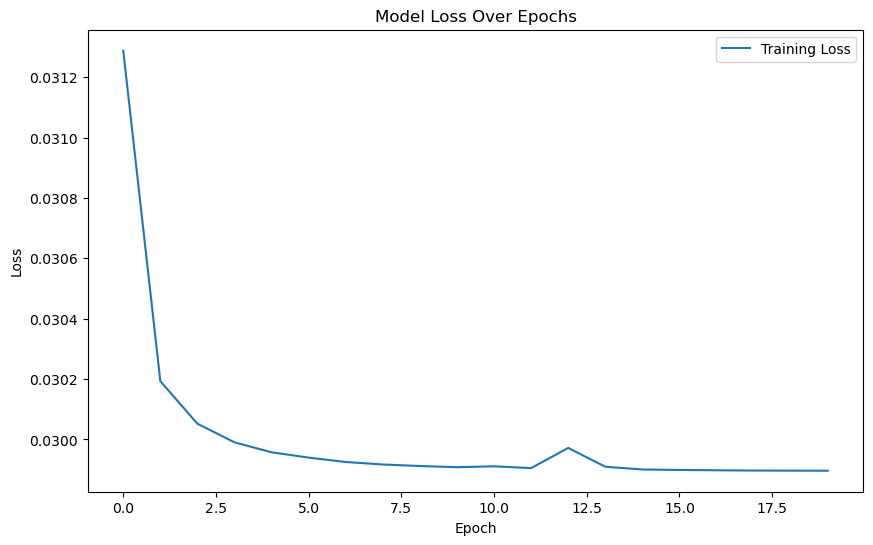

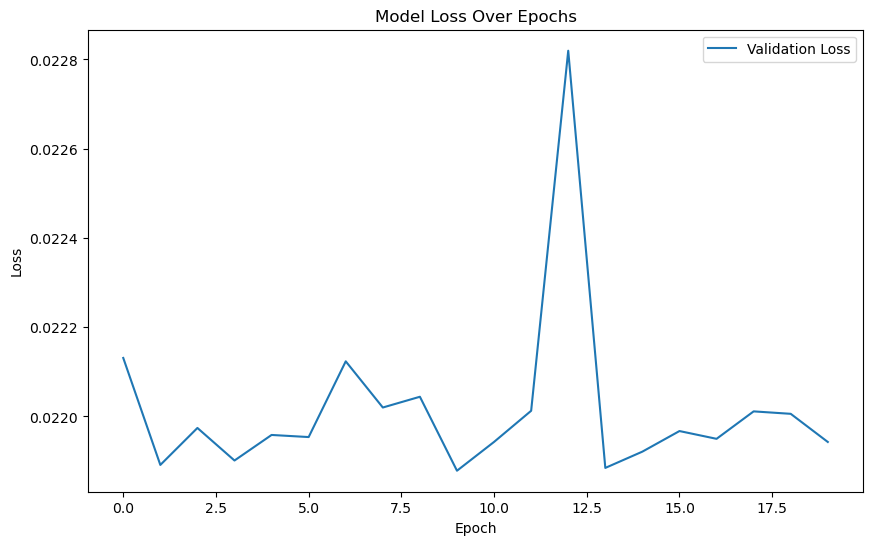

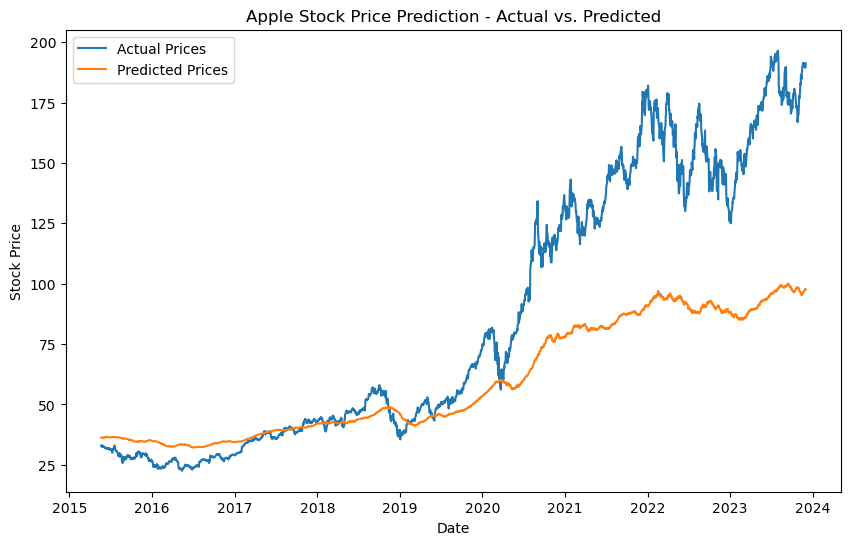

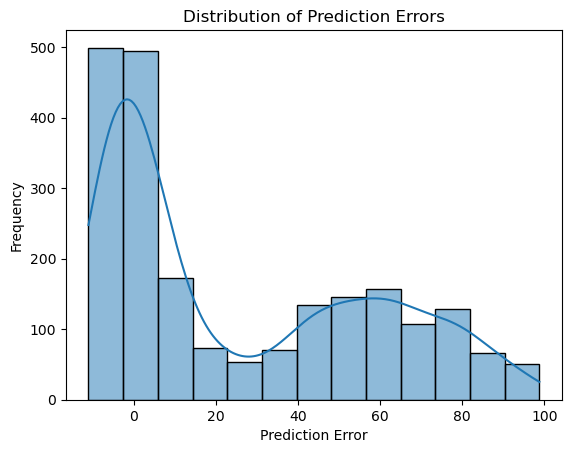

In [111]:
plot_model_results(cnn_lasso.history, actual_stock_prices, lasso_cnn_predictions_final, stock_data.index)

## Recursive Feature Elimination

Recursive Feature Elimination (RFE) is a feature selection method used to identify and remove the least important features from a dataset. This is achieved by repeatedly constructing a model (like a regression or decision tree) and removing the least significant features at each iteration. The process continues until the specified number of features is reached. RFE helps in enhancing the performance of the model by eliminating redundant or less important features, leading to a more efficient and potentially more accurate model.

In [112]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression  # Use a regression model
import numpy as np

# Assuming y is a continuous target variable
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
fit = rfe.fit(X, y)  # X is your feature matrix, and y is your continuous target variable

selected_feature_names = np.array(X.columns)[fit.support_]

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
print(selected_feature_names)

Num Features: 5
Selected Features: [ True  True  True  True False  True]
Feature Ranking: [1 1 1 1 2 1]
['Open' 'High' 'Low' 'Adj Close' 'Price_Change']


In [113]:
features = ["High", "Low", "Log_Returns","Weighted_Close","Typical_Price"]
X = df[features]
y = df['Close']

In [114]:
X_scaled = scaler.fit_transform(X)
X_scaled

array([[4.75869589e-04, 4.80200644e-04, 7.10576428e-01, 4.78751421e-04,
        4.79222817e-04],
       [4.50529086e-04, 4.57335408e-04, 6.87038340e-01, 4.55277752e-04,
        4.55500447e-04],
       [4.25188507e-04, 4.31611998e-04, 6.81915166e-01, 4.29670078e-04,
        4.29880247e-04],
       ...,
       [9.69018119e-01, 9.67679308e-01, 7.12891688e-01, 9.68321868e-01,
        9.69781583e-01],
       [9.60086915e-01, 9.63684045e-01, 7.21223017e-01, 9.66549953e-01,
        9.66431563e-01],
       [9.66343793e-01, 9.69011036e-01, 7.24867145e-01, 9.72745353e-01,
        9.72502440e-01]])

In [115]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [116]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [118]:
actual_stock_prices = df["Close"][-len(X_test):].values

In [117]:
rfe_lstm = create_lstm_model(look_back, features)
lstm_rfe = rfe_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfe_lstm_predictions = rfe_lstm.predict(X_test)

# Reshape predictions for inverse transform
rfe_lstm_predictions_reshaped = rfe_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfe_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfe_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
rfe_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
rfe_lstm_predictions_final = rfe_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0834 - val_loss: 0.0673 - 4s/epoch - 19ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [119]:
mae = mean_absolute_error(actual_stock_prices, rfe_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfe_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfe_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 15.523543082475094, MSE: 287.52626634741, RMSE: 16.956599492451605, R2 Score: 0.9063405776223211


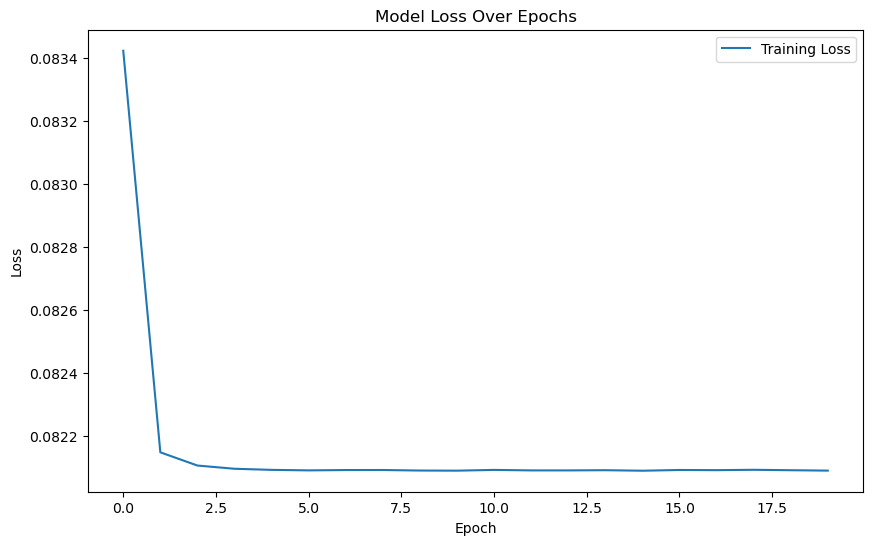

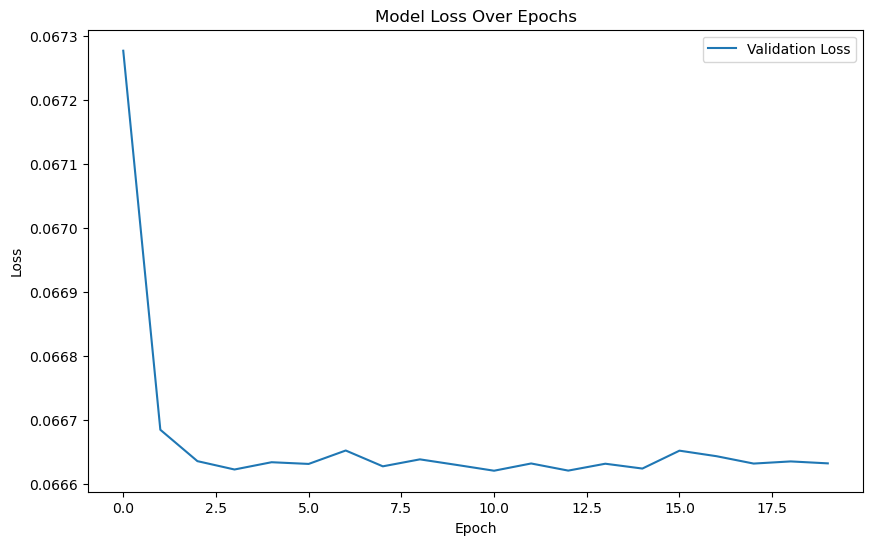

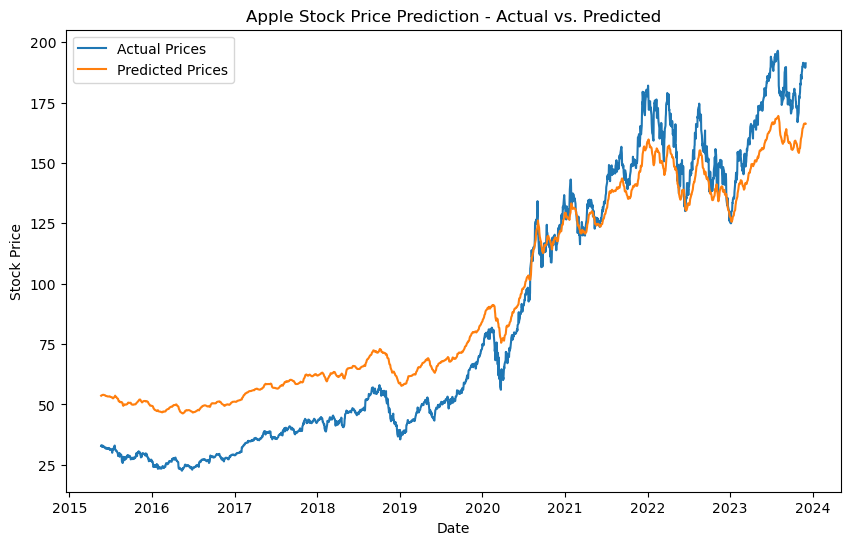

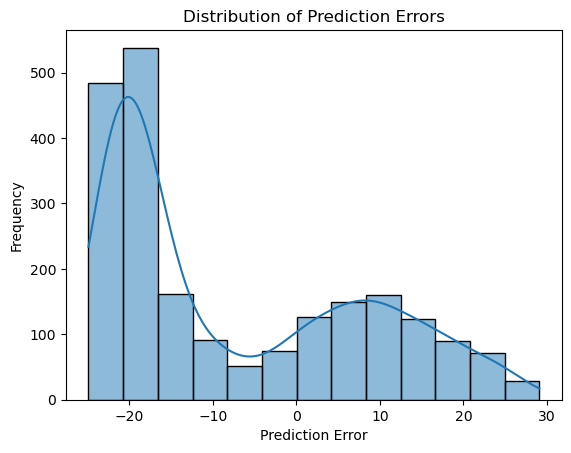

In [120]:
plot_model_results(lstm_rfe.history, actual_stock_prices, rfe_lstm_predictions_final, stock_data.index)

In [121]:
rfe_gru = create_gru_model(look_back, features)
gru_rfe = rfe_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfe_gru_predictions = rfe_gru.predict(X_test)

# Reshape predictions for inverse transform
rfe_gru_predictions_reshaped = rfe_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfe_gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfe_gru_predictions_reshaped.ravel()
# Apply inverse transformation
rfe_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
rfe_gru_predictions_final = rfe_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0824 - val_loss: 0.0666 - 4s/epoch - 19ms/step
Epoch 2/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 12ms/step
Epoch 8/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0666 - 3s/epoch - 12ms/step
Epoch 12/20
215/215 - 3s - loss: 0.0821 - val_loss: 0.0667 - 3s/epoch - 13ms/step
Epoch 13/20
215/215 - 3s 

In [122]:
mae = mean_absolute_error(actual_stock_prices, rfe_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfe_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfe_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 16.326554960691613, MSE: 306.52129631127474, RMSE: 17.507749607281763, R2 Score: 0.900153095841743


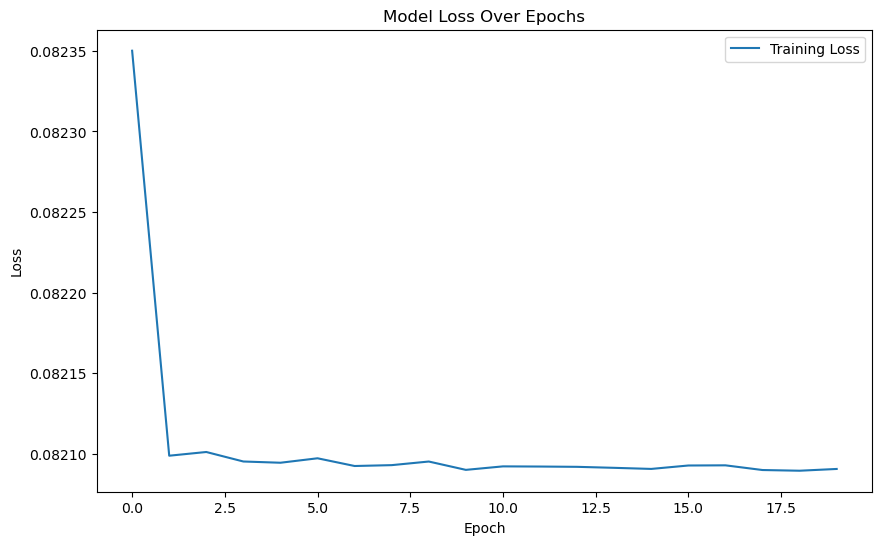

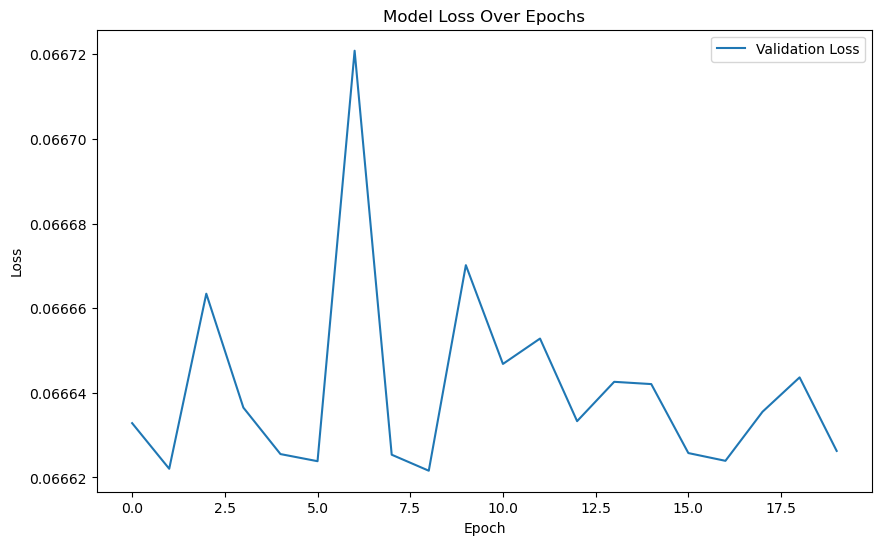

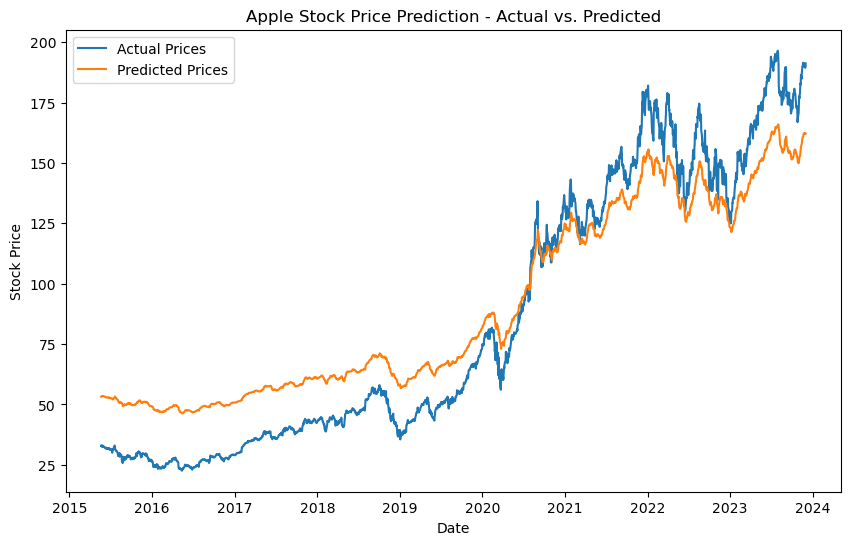

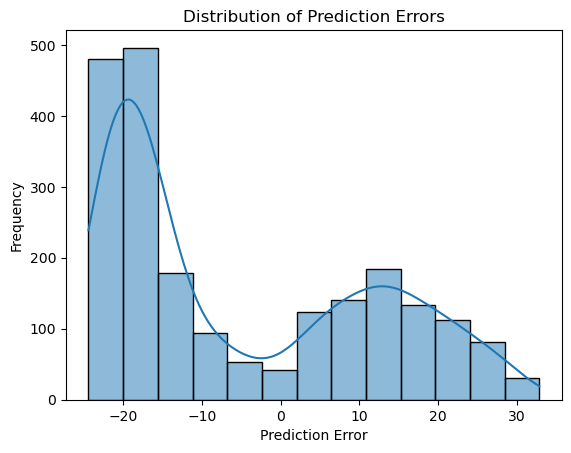

In [123]:
plot_model_results(gru_rfe.history, actual_stock_prices, rfe_gru_predictions_final, stock_data.index)

In [124]:
rfe_mlp = create_mlp_model(look_back, features)
mlp_rfe = rfe_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfe_mlp_predictions = rfe_mlp.predict(X_test)

# Reshape predictions for inverse transform
rfe_mlp_predictions_reshaped = rfe_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfe_mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfe_mlp_predictions_reshaped.ravel()
# Apply inverse transformation
rfe_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
rfe_mlp_predictions_final = rfe_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 0.0834 - val_loss: 0.0674 - 1s/epoch - 6ms/step
Epoch 2/20
215/215 - 1s - loss: 0.0828 - val_loss: 0.0684 - 892ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 0.0827 - val_loss: 0.0671 - 824ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 0.0826 - val_loss: 0.0677 - 828ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 0.0824 - val_loss: 0.0669 - 820ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 0.0824 - val_loss: 0.0674 - 820ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 0.0824 - val_loss: 0.0675 - 817ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 0.0823 - val_loss: 0.0669 - 811ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 0.0822 - val_loss: 0.0668 - 835ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 0.0822 - val_loss: 0.0675 - 800ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 0.0822 - val_loss: 0.0669 - 794ms/epoch - 4ms/step
Epoch 12/20
215/215 - 1s - loss: 0.0822 - val_loss: 0.0672 - 834ms/epoch - 4ms/step
Epoc

In [125]:
mae = mean_absolute_error(actual_stock_prices, rfe_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfe_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfe_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 43.638655880176636, MSE: 2070.57901215055, RMSE: 45.50361537450129, R2 Score: 0.3255251538270031


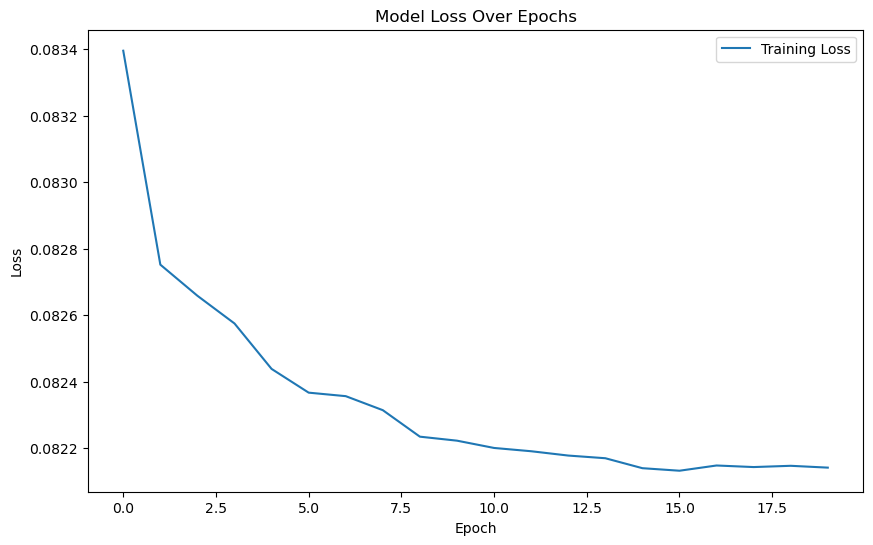

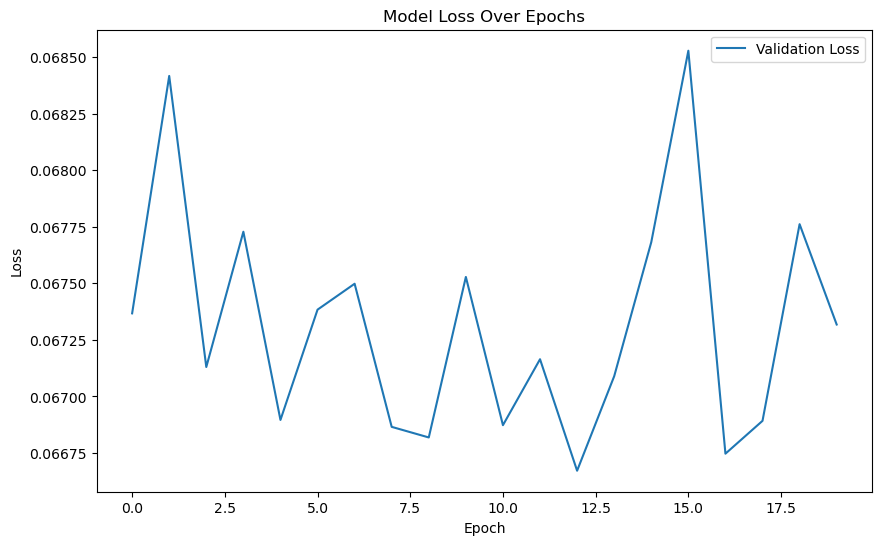

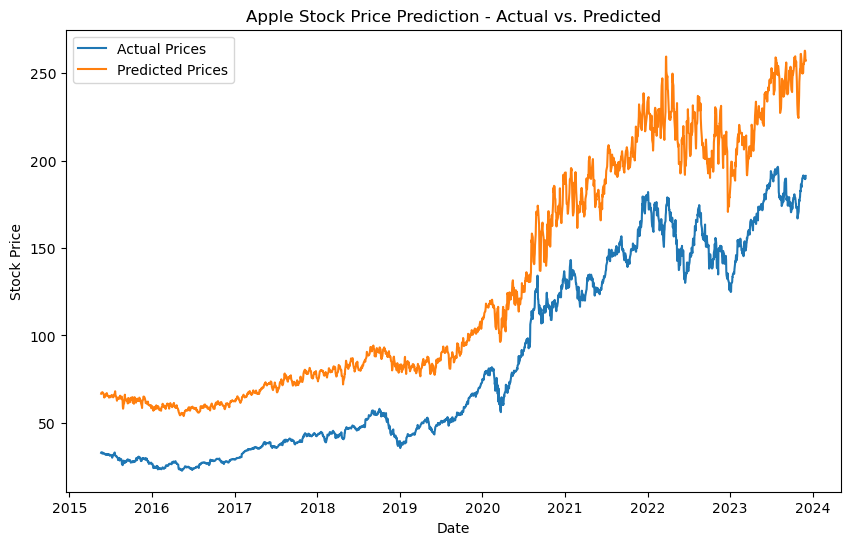

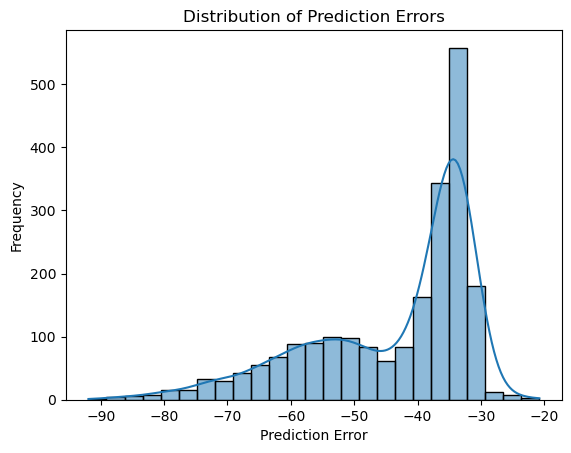

In [126]:
plot_model_results(mlp_rfe.history, actual_stock_prices, rfe_mlp_predictions_final, stock_data.index)

In [127]:
rfe_cnn = create_cnn_model(look_back, features)
cnn_rfe = rfe_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

rfe_cnn_predictions = rfe_cnn.predict(X_test)

# Reshape predictions for inverse transform
rfe_cnn_predictions_reshaped = rfe_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((rfe_cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = rfe_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
rfe_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
rfe_cnn_predictions_final = rfe_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 0.0857 - val_loss: 0.0668 - 4s/epoch - 18ms/step
Epoch 2/20
215/215 - 2s - loss: 0.0829 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 3/20
215/215 - 2s - loss: 0.0823 - val_loss: 0.0667 - 2s/epoch - 11ms/step
Epoch 4/20
215/215 - 2s - loss: 0.0822 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 5/20
215/215 - 2s - loss: 0.0822 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 0.0824 - val_loss: 0.0671 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 0.0822 - val_loss: 0.0668 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 0.0821 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 0.0821 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 0.0821 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 0.0821 - val_loss: 0.0667 - 2s/epoch - 10ms/step
Epoch 12/20
215/215 - 2s - loss: 0.0821 - val_loss: 0.0668 - 2s/epoch - 10ms/step
Epoch 13/20
215/215 - 2s 

In [128]:
mae = mean_absolute_error(actual_stock_prices, rfe_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, rfe_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, rfe_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 24.181509482641196, MSE: 778.5781762157387, RMSE: 27.903013747904343, R2 Score: 0.7463842758208249


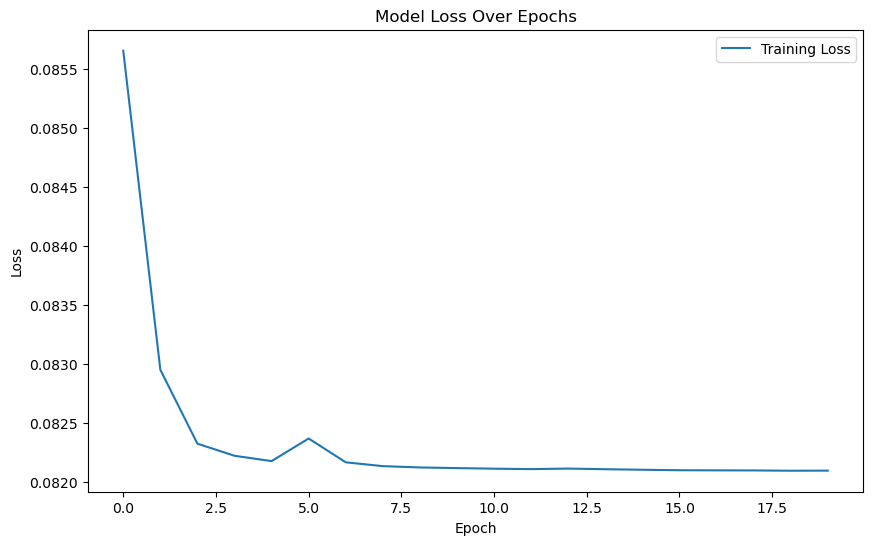

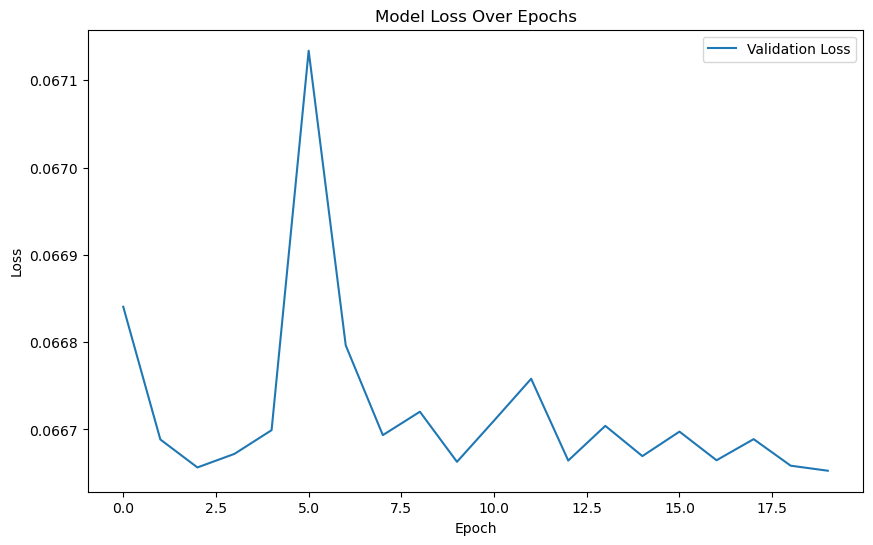

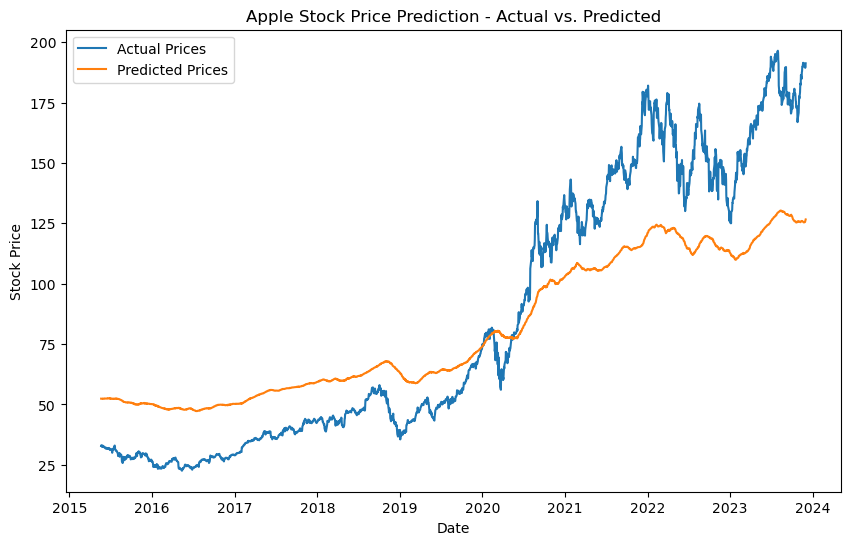

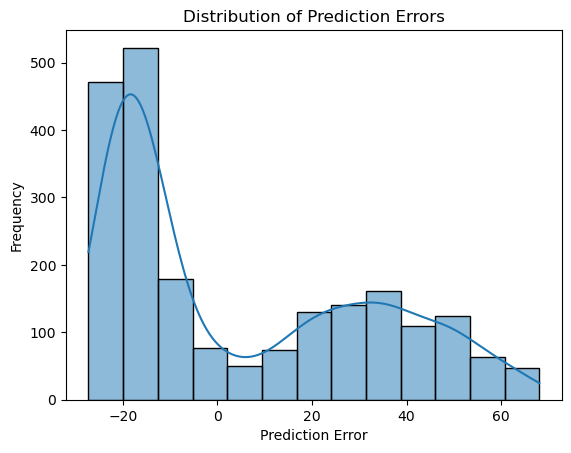

In [129]:
plot_model_results(cnn_rfe.history, actual_stock_prices, rfe_cnn_predictions_final, stock_data.index)

## Mutual Information

Mutual Information (MI) for feature reduction is a statistical technique used in machine learning to select features that are most informative about the outcome. It measures the amount of information one variable (feature) shares with another (target). High MI between a feature and the target indicates a strong relationship, making the feature valuable for prediction. This method helps in reducing the number of features in a dataset by keeping only those with significant MI scores, thereby improving model efficiency and reducing overfitting. It's particularly useful in scenarios with many variables, where identifying the most relevant features is crucial.

In [130]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

df_mutualinfo = df_pca.copy()

X = df_mutualinfo.drop('Close', axis=1)
y = df_mutualinfo['Close']
mi_selector = SelectKBest(mutual_info_regression, k=6)
X_new = mi_selector.fit_transform(X, y)
selected_features_mi = X.columns[mi_selector.get_support()].tolist()
selected_features_mi

['Open', 'High', 'Low', 'Adj Close', 'Typical_Price', 'Weighted_Close']

In [131]:
features = ["Open","High", "Low", "Volume","Weighted_Close","Typical_Price"]
X = df[features]
y = df['Close']

In [133]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [134]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [135]:
mi_lstm = create_lstm_model(look_back, features)
lstm_mi = mi_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

mi_lstm_predictions = mi_lstm.predict(X_test)

# Reshape predictions for inverse transform
mi_lstm_predictions_reshaped = mi_lstm_predictions.reshape(-1, 1)
dummy_array = np.zeros((mi_lstm_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = mi_lstm_predictions_reshaped.ravel()
# Apply inverse transformation
mi_lstm_predictions_inversed = scaler.inverse_transform(dummy_array)
mi_lstm_predictions_final = mi_lstm_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 5.8589e-04 - val_loss: 8.8958e-04 - 4s/epoch - 19ms/step
Epoch 2/20
215/215 - 3s - loss: 5.7054e-04 - val_loss: 8.2511e-04 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 5.7024e-04 - val_loss: 8.1410e-04 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 5.6772e-04 - val_loss: 8.5600e-04 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 5.6840e-04 - val_loss: 0.0010 - 3s/epoch - 13ms/step
Epoch 6/20
215/215 - 3s - loss: 5.6783e-04 - val_loss: 8.2394e-04 - 3s/epoch - 13ms/step
Epoch 7/20
215/215 - 3s - loss: 5.6741e-04 - val_loss: 8.9703e-04 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 5.6781e-04 - val_loss: 8.1149e-04 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 5.6694e-04 - val_loss: 0.0011 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 5.6679e-04 - val_loss: 8.0755e-04 - 3s/epoch - 13ms/step
Epoch 11/20
215/215 - 3s - loss: 5.6651e-04 - val_loss: 0.0010 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss

In [136]:
actual_stock_prices = df["Close"][-len(X_test):].values

In [137]:
mae = mean_absolute_error(actual_stock_prices, mi_lstm_predictions_final)
mse = mean_squared_error(actual_stock_prices, mi_lstm_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, mi_lstm_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 11.069446661249927, MSE: 298.7881788370798, RMSE: 17.285490413554363, R2 Score: 0.902672098105476


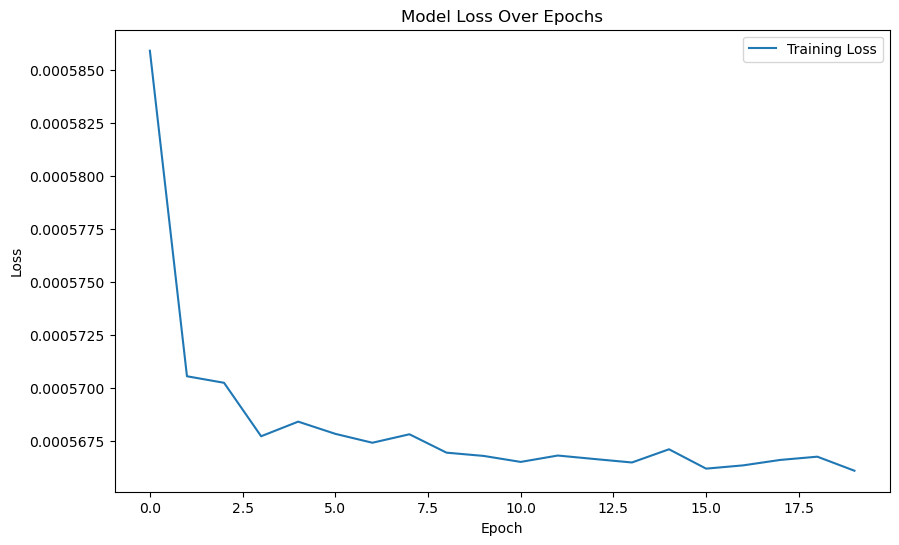

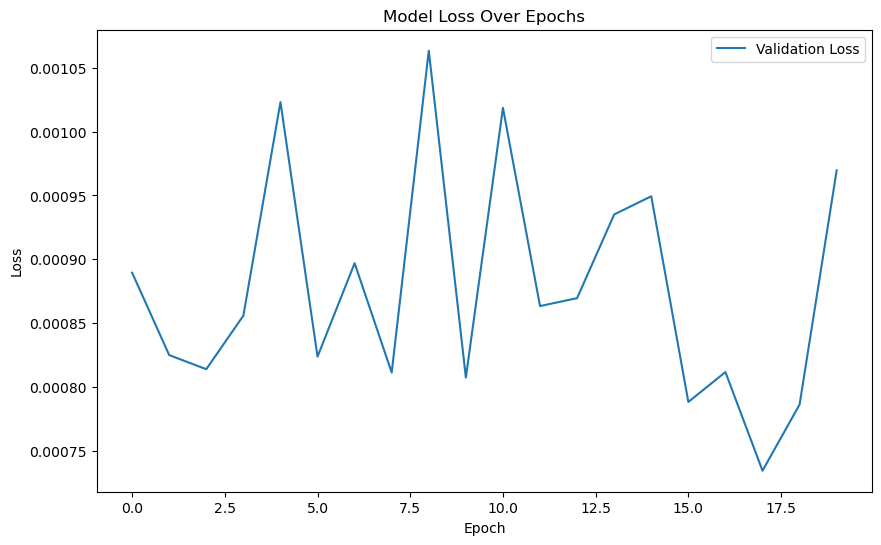

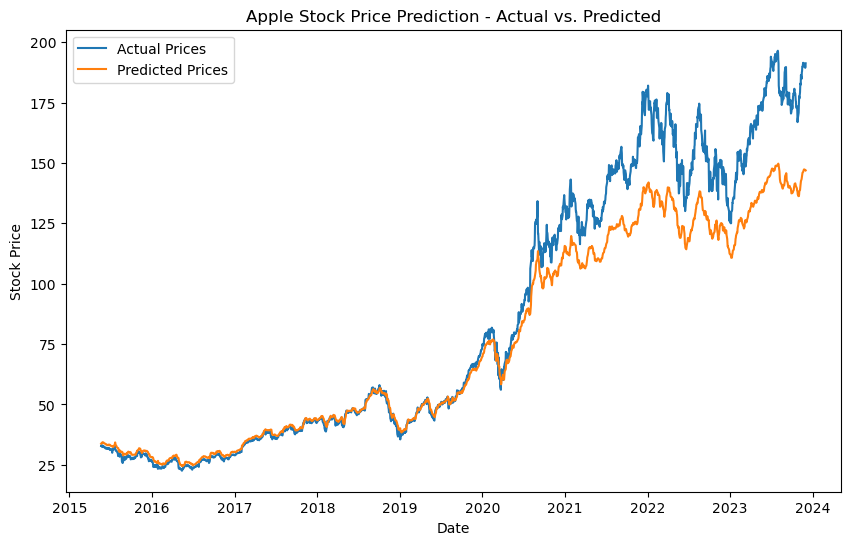

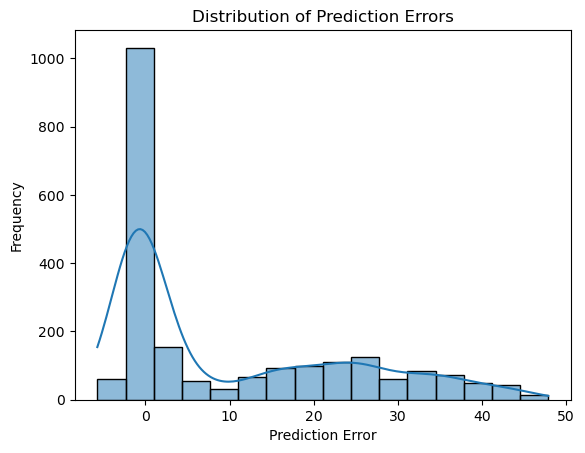

In [138]:
plot_model_results(lstm_mi.history, actual_stock_prices, mi_lstm_predictions_final, stock_data.index)

In [139]:
mi_gru = create_gru_model(look_back, features)
gru_mi = mi_gru.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

mi_gru_predictions = mi_gru.predict(X_test)

# Reshape predictions for inverse transform
mi_gru_predictions_reshaped = mi_gru_predictions.reshape(-1, 1)
dummy_array = np.zeros((mi_gru_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = mi_gru_predictions_reshaped.ravel()
# Apply inverse transformation
mi_gru_predictions_inversed = scaler.inverse_transform(dummy_array)
mi_gru_predictions_final = mi_gru_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 5.7777e-04 - val_loss: 8.5324e-04 - 4s/epoch - 19ms/step
Epoch 2/20
215/215 - 3s - loss: 5.7075e-04 - val_loss: 0.0013 - 3s/epoch - 13ms/step
Epoch 3/20
215/215 - 3s - loss: 5.6918e-04 - val_loss: 0.0010 - 3s/epoch - 13ms/step
Epoch 4/20
215/215 - 3s - loss: 5.6791e-04 - val_loss: 0.0011 - 3s/epoch - 13ms/step
Epoch 5/20
215/215 - 3s - loss: 5.6845e-04 - val_loss: 0.0011 - 3s/epoch - 12ms/step
Epoch 6/20
215/215 - 3s - loss: 5.6789e-04 - val_loss: 0.0012 - 3s/epoch - 12ms/step
Epoch 7/20
215/215 - 3s - loss: 5.6802e-04 - val_loss: 9.6437e-04 - 3s/epoch - 13ms/step
Epoch 8/20
215/215 - 3s - loss: 5.6744e-04 - val_loss: 9.9367e-04 - 3s/epoch - 13ms/step
Epoch 9/20
215/215 - 3s - loss: 5.6709e-04 - val_loss: 0.0011 - 3s/epoch - 13ms/step
Epoch 10/20
215/215 - 3s - loss: 5.6721e-04 - val_loss: 9.2415e-04 - 3s/epoch - 12ms/step
Epoch 11/20
215/215 - 3s - loss: 5.6726e-04 - val_loss: 8.1193e-04 - 3s/epoch - 13ms/step
Epoch 12/20
215/215 - 3s - loss: 5.6663e-04

In [140]:
mae = mean_absolute_error(actual_stock_prices, mi_gru_predictions_final)
mse = mean_squared_error(actual_stock_prices, mi_gru_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, mi_gru_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 2.277539182472284, MSE: 10.852650236501841, RMSE: 3.2943360843274387, R2 Score: 0.9964648344468481


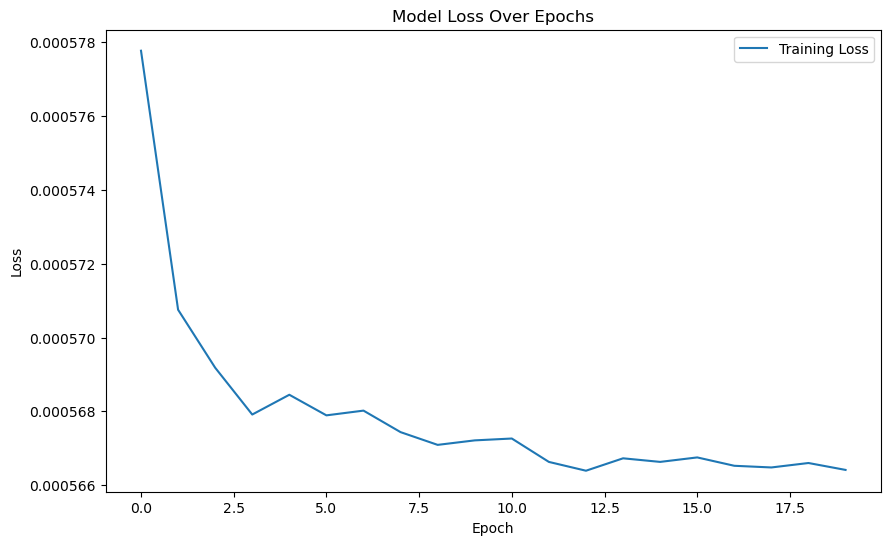

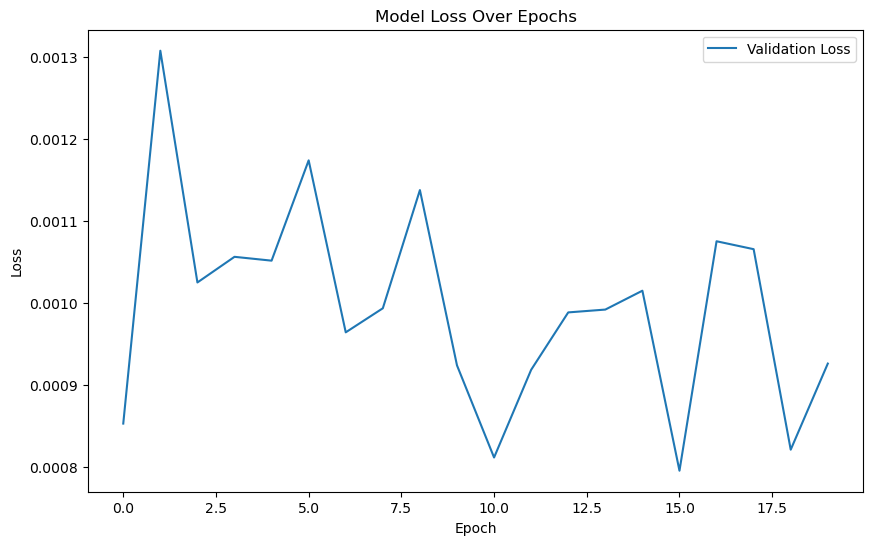

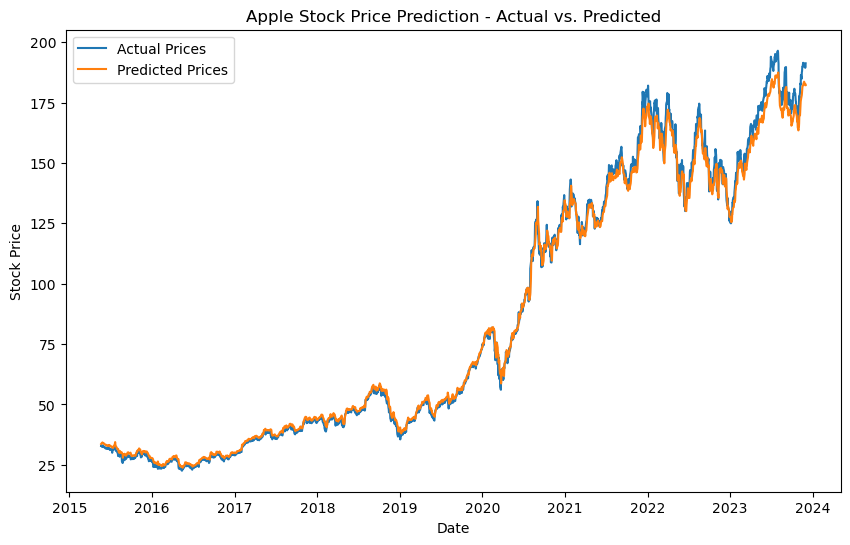

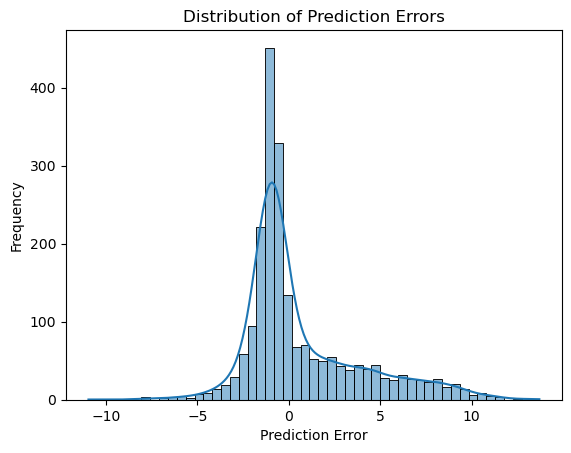

In [141]:
plot_model_results(gru_mi.history, actual_stock_prices, mi_gru_predictions_final, stock_data.index)

In [142]:
mi_mlp = create_mlp_model(look_back, features)
mlp_mi = mi_mlp.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

mi_mlp_predictions = mi_mlp.predict(X_test)

# Reshape predictions for inverse transform
mi_mlp_predictions_reshaped = mi_mlp_predictions.reshape(-1, 1)
dummy_array = np.zeros((mi_mlp_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = mi_mlp_predictions_reshaped.ravel()
# Apply inverse transformation
mi_mlp_predictions_inversed = scaler.inverse_transform(dummy_array)
mi_mlp_predictions_final = mi_mlp_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 1s - loss: 7.5411e-04 - val_loss: 8.1960e-04 - 1s/epoch - 6ms/step
Epoch 2/20
215/215 - 1s - loss: 5.7898e-04 - val_loss: 0.0019 - 885ms/epoch - 4ms/step
Epoch 3/20
215/215 - 1s - loss: 5.7187e-04 - val_loss: 7.4322e-04 - 822ms/epoch - 4ms/step
Epoch 4/20
215/215 - 1s - loss: 5.7283e-04 - val_loss: 7.9646e-04 - 851ms/epoch - 4ms/step
Epoch 5/20
215/215 - 1s - loss: 5.7130e-04 - val_loss: 8.8264e-04 - 863ms/epoch - 4ms/step
Epoch 6/20
215/215 - 1s - loss: 5.7526e-04 - val_loss: 0.0011 - 822ms/epoch - 4ms/step
Epoch 7/20
215/215 - 1s - loss: 5.7418e-04 - val_loss: 7.6232e-04 - 830ms/epoch - 4ms/step
Epoch 8/20
215/215 - 1s - loss: 5.7339e-04 - val_loss: 8.6407e-04 - 834ms/epoch - 4ms/step
Epoch 9/20
215/215 - 1s - loss: 5.7642e-04 - val_loss: 7.3902e-04 - 805ms/epoch - 4ms/step
Epoch 10/20
215/215 - 1s - loss: 5.6977e-04 - val_loss: 0.0010 - 824ms/epoch - 4ms/step
Epoch 11/20
215/215 - 1s - loss: 5.7716e-04 - val_loss: 7.8828e-04 - 811ms/epoch - 4ms/step
Epoch 12/20


In [143]:
mae = mean_absolute_error(actual_stock_prices, mi_mlp_predictions_final)
mse = mean_squared_error(actual_stock_prices, mi_mlp_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, mi_mlp_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 3.549243860219264, MSE: 29.266874590942926, RMSE: 5.409886744742715, R2 Score: 0.9904665455305719


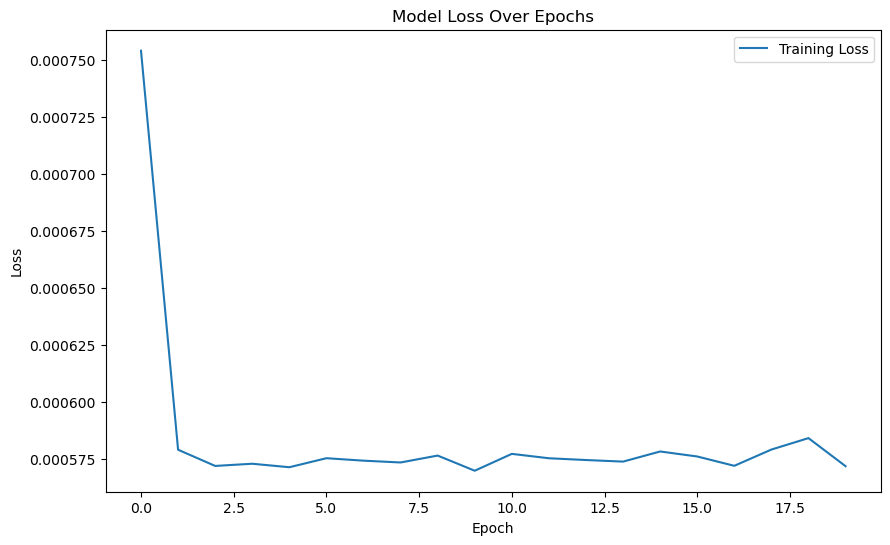

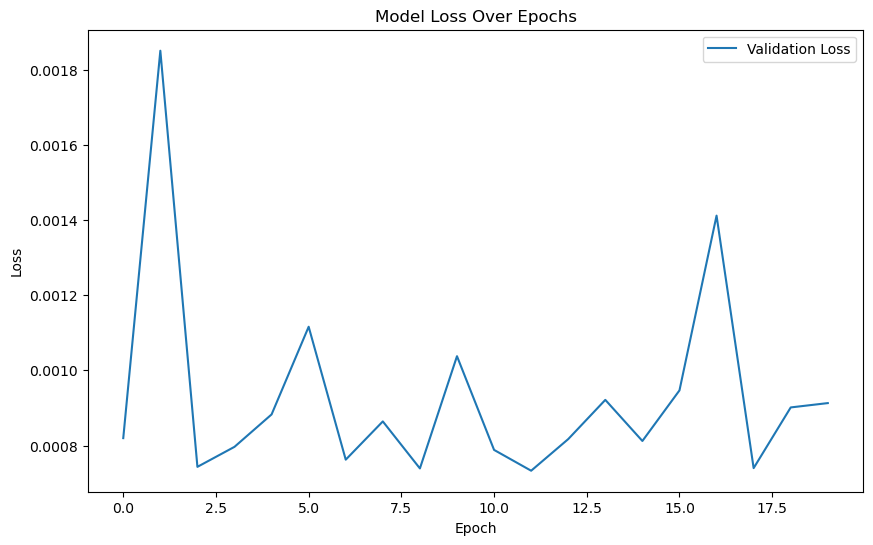

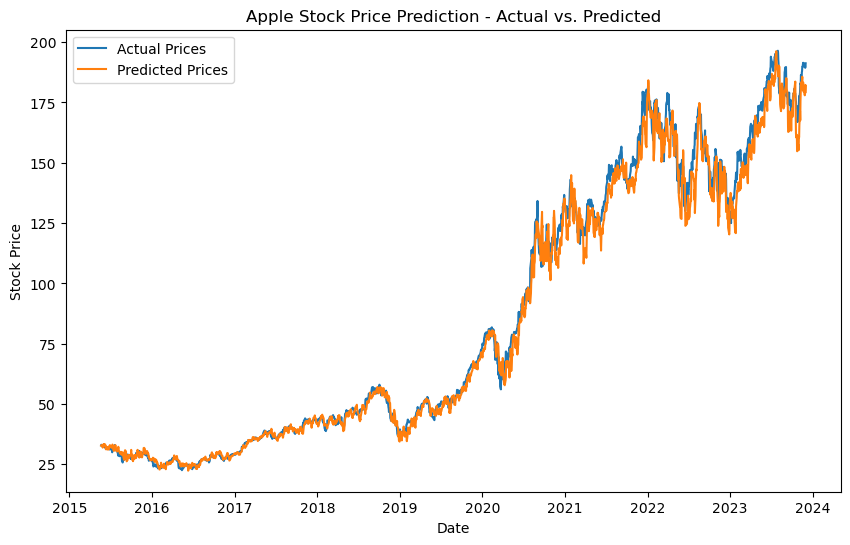

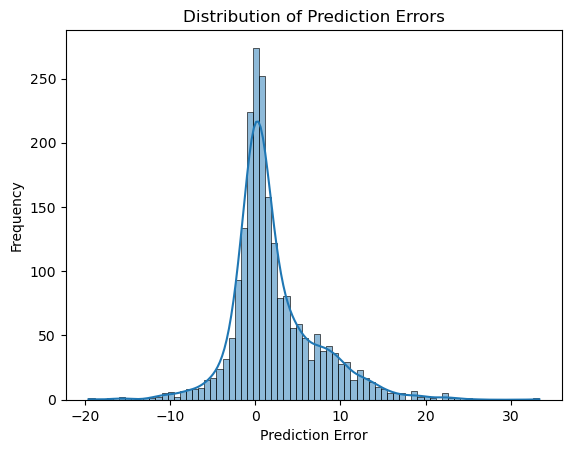

In [144]:
plot_model_results(mlp_mi.history, actual_stock_prices, mi_mlp_predictions_final, stock_data.index)

In [145]:
mi_cnn = create_cnn_model(look_back, features)
cnn_mi = mi_cnn.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

mi_cnn_predictions = mi_cnn.predict(X_test)

# Reshape predictions for inverse transform
mi_cnn_predictions_reshaped = mi_cnn_predictions.reshape(-1, 1)
dummy_array = np.zeros((mi_cnn_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = mi_cnn_predictions_reshaped.ravel()
# Apply inverse transformation
mi_cnn_predictions_inversed = scaler.inverse_transform(dummy_array)
mi_cnn_predictions_final = mi_cnn_predictions_inversed[:, 0]

Epoch 1/20
215/215 - 4s - loss: 6.5752e-04 - val_loss: 7.6586e-04 - 4s/epoch - 18ms/step
Epoch 2/20
215/215 - 2s - loss: 6.0107e-04 - val_loss: 7.5703e-04 - 2s/epoch - 10ms/step
Epoch 3/20
215/215 - 2s - loss: 5.8964e-04 - val_loss: 7.8353e-04 - 2s/epoch - 10ms/step
Epoch 4/20
215/215 - 2s - loss: 5.8361e-04 - val_loss: 8.4516e-04 - 2s/epoch - 10ms/step
Epoch 5/20
215/215 - 2s - loss: 5.8178e-04 - val_loss: 8.5737e-04 - 2s/epoch - 10ms/step
Epoch 6/20
215/215 - 2s - loss: 5.8215e-04 - val_loss: 7.6687e-04 - 2s/epoch - 10ms/step
Epoch 7/20
215/215 - 2s - loss: 5.7929e-04 - val_loss: 7.7741e-04 - 2s/epoch - 10ms/step
Epoch 8/20
215/215 - 2s - loss: 5.9074e-04 - val_loss: 0.0011 - 2s/epoch - 10ms/step
Epoch 9/20
215/215 - 2s - loss: 5.8151e-04 - val_loss: 7.3811e-04 - 2s/epoch - 10ms/step
Epoch 10/20
215/215 - 2s - loss: 5.8161e-04 - val_loss: 7.3846e-04 - 2s/epoch - 10ms/step
Epoch 11/20
215/215 - 2s - loss: 5.8009e-04 - val_loss: 8.0875e-04 - 2s/epoch - 10ms/step
Epoch 12/20
215/215 - 2

In [146]:
mae = mean_absolute_error(actual_stock_prices, mi_cnn_predictions_final)
mse = mean_squared_error(actual_stock_prices, mi_cnn_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, mi_cnn_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 25.589150124634596, MSE: 1044.8969534356268, RMSE: 32.3248658687956, R2 Score: 0.6596330264146012


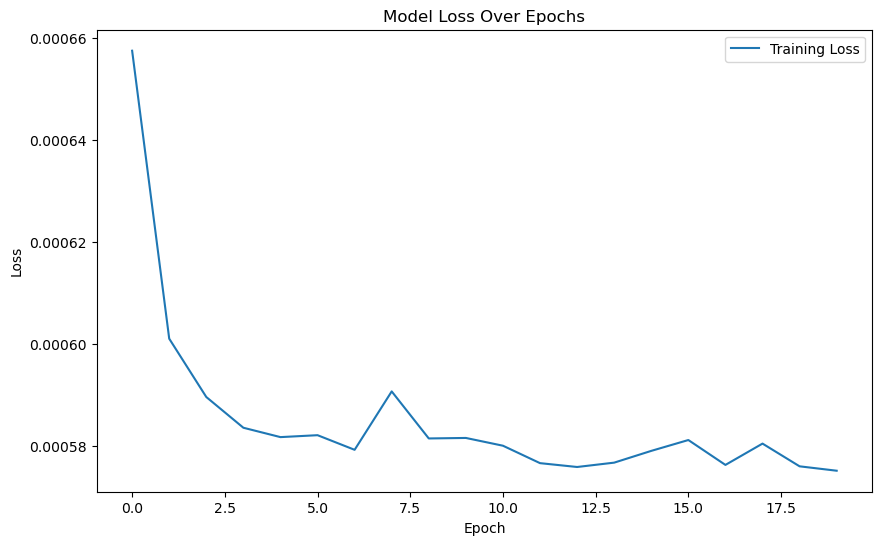

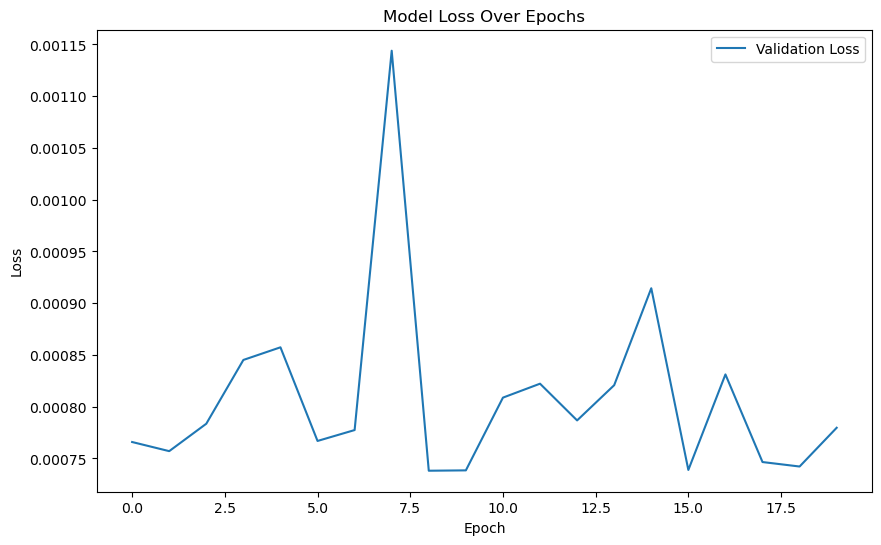

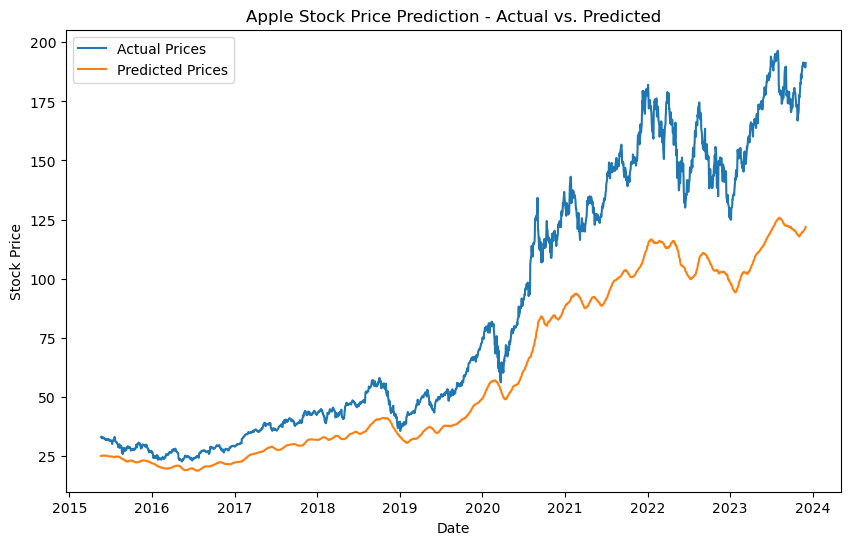

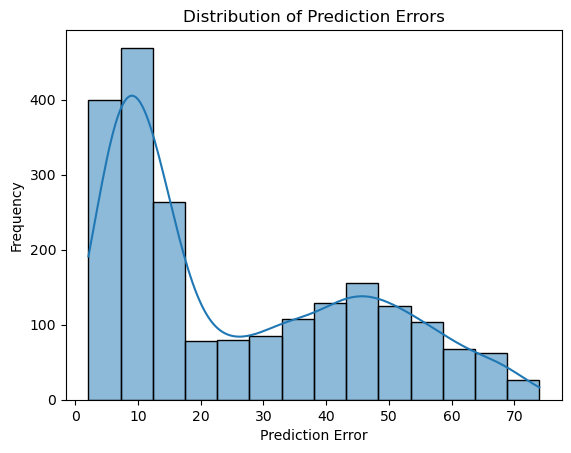

In [147]:
plot_model_results(cnn_mi.history, actual_stock_prices, mi_cnn_predictions_final, stock_data.index)

## DataFrame Showing all the errors for Selecting the Best Models

In [158]:
import pandas as pd

# Define the error metrics for each model and feature reduction method
metrics = {
    'Model': ['LSTM', 'GRU', 'MLP', 'CNN'],
    'No Reduction': [
        {'MAE': 11.1424, 'MSE': 312.4775, 'RMSE': 17.6770, 'R2': 0.8982},
        {'MAE': 2.7908, 'MSE': 10.3701, 'RMSE': 3.2203, 'R2': 0.9966},
        {'MAE': 12.1684, 'MSE': 225.4311, 'RMSE': 15.0144, 'R2': 0.9266},
        {'MAE': 19.6202, 'MSE': 743.4103, 'RMSE': 27.2656, 'R2': 0.7578}
    ],
    'Correlation Analysis': [
        {'MAE': 23.0365, 'MSE': 637.5909, 'RMSE': 25.2506, 'R2': 0.7923},
        {'MAE': 20.6931, 'MSE': 525.0660, 'RMSE': 22.9143, 'R2': 0.8290},
        {'MAE': 17.5204, 'MSE': 381.6012, 'RMSE': 19.5346, 'R2': 0.8757},
        {'MAE': 36.4531, 'MSE': 1911.1882, 'RMSE': 43.7171, 'R2': 0.3774}
    ],
    'PCA': [
        {'MAE': 27.9362, 'MSE': 1093.9039, 'RMSE': 33.0742, 'R2': 0.6437},
        {'MAE': 21.5378, 'MSE': 546.9716, 'RMSE': 23.3874, 'R2': 0.8218},
        {'MAE': 27.9570, 'MSE': 877.9996, 'RMSE': 29.6142, 'R2': 0.7143},
        {'MAE': 65.4617, 'MSE': 8352.6037, 'RMSE': 91.3926, 'R2': -1.7208}
    ],
    'RFR': [
        {'MAE': 2.8343, 'MSE': 20.9543, 'RMSE': 4.5776, 'R2': 0.9932},
        {'MAE': 3.9916, 'MSE': 24.9536, 'RMSE': 4.9954, 'R2': 0.9919},
        {'MAE': 9.4374, 'MSE': 152.3275, 'RMSE': 12.3421, 'R2': 0.9504},
        {'MAE': 38.9906, 'MSE': 2283.2444, 'RMSE': 47.7833, 'R2': 0.2563}
    ],
    'LASSO CV': [
        {'MAE': 13.2105, 'MSE': 245.7742, 'RMSE': 15.6772, 'R2': 0.9199},
        {'MAE': 11.3978, 'MSE': 170.3989, 'RMSE': 13.0537, 'R2': 0.9445},
        {'MAE': 14.0064, 'MSE': 343.4838, 'RMSE': 18.5333, 'R2': 0.8881},
        {'MAE': 28.8123, 'MSE': 1702.0863, 'RMSE': 41.2563, 'R2': 0.4456}
    ],
    'Recursive Feature Elimination': [
        {'MAE': 15.5235, 'MSE': 287.5263, 'RMSE': 16.9566, 'R2': 0.9063},
        {'MAE': 16.3266, 'MSE': 306.5213, 'RMSE': 17.5077, 'R2': 0.9002},
        {'MAE': 43.6387, 'MSE': 2070.5790, 'RMSE': 45.5036, 'R2': 0.3255},
        {'MAE': 24.1815, 'MSE': 778.5782, 'RMSE': 27.9030, 'R2': 0.7464}
    ],
    'Mutual Information': [
        {'MAE': 11.0694, 'MSE': 298.7882, 'RMSE': 17.2855, 'R2': 0.9027},
        {'MAE': 2.2775, 'MSE': 10.8527, 'RMSE': 3.2943, 'R2': 0.9965},
        {'MAE': 3.5492, 'MSE': 29.2669, 'RMSE': 5.4099, 'R2': 0.9905},
        {'MAE': 25.5892, 'MSE': 1044.8970, 'RMSE': 32.3249, 'R2': 0.6596}
    ]
}

# Convert the dictionaries into a DataFrame
df_list = []
for reduction_method, values in metrics.items():
    if reduction_method != 'Model':
        for i, model_metrics in enumerate(values):
            row = {'Feature Reduction': reduction_method, 'Model': metrics['Model'][i]}
            row.update(model_metrics)
            df_list.append(row)

comparison_df = pd.DataFrame(df_list)

comparison_df

Feature Reduction Model      MAE        MSE     RMSE      R2
0                    No Reduction  LSTM  11.1424   312.4775  17.6770  0.8982
1                    No Reduction   GRU   2.7908    10.3701   3.2203  0.9966
2                    No Reduction   MLP  12.1684   225.4311  15.0144  0.9266
3                    No Reduction   CNN  19.6202   743.4103  27.2656  0.7578
4            Correlation Analysis  LSTM  23.0365   637.5909  25.2506  0.7923
5            Correlation Analysis   GRU  20.6931   525.0660  22.9143  0.8290
6            Correlation Analysis   MLP  17.5204   381.6012  19.5346  0.8757
7            Correlation Analysis   CNN  36.4531  1911.1882  43.7171  0.3774
8                             PCA  LSTM  27.9362  1093.9039  33.0742  0.6437
9                             PCA   GRU  21.5378   546.9716  23.3874  0.8218
10                            PCA   MLP  27.9570   877.9996  29.6142  0.7143
11                            PCA   CNN  65.4617  8352.6037  91.3926 -1.7208
12                            RFR  LSTM   2.8343    20.9543   4.5776  0.9932
13                            RFR   GRU   3.9916    24.9536   4.9954  0.9919
14                            RFR   MLP   9.4374   152.3275  12.3421  0.9504
15                            RFR   CNN  38.9906  2283.2444  47.7833  0.2563
16                       LASSO CV  LSTM  13.2105   245.7742  15.6772  0.9199
17                       LASSO CV   GRU  11.3978   170.3989  13.0537  0.9445
18                       LASSO CV   MLP  14.0064   343.4838  18.5333  0.8881
19                       LASSO CV   CNN  28.8123  1702.0863  41.2563  0.4456
20  Recursive Feature Elimination  LSTM  15.5235   287.5263  16.9566  0.9063
21  Recursive Feature Elimination   GRU  16.3266   306.5213  17.5077  0.9002
22  Recursive Feature Elimination   MLP  43.6387  2070.5790  45.5036  0.3255
23  Recursive Feature Elimination   CNN  24.1815   778.5782  27.9030  0.7464
24             Mutual Information  LSTM  11.0694   298.7882  17.2855  0.9027
25             Mutual Information   GRU   2.2775    10.8527   3.2943  0.9965
26             Mutual Information   MLP   3.5492    29.2669   5.4099  0.9905
27             Mutual Information   CNN  25.5892  1044.8970  32.3249  0.6596

In [159]:
filtered_df = comparison_df[comparison_df['MAE'] < 5]
filtered_df

Feature Reduction Model     MAE      MSE    RMSE      R2
1         No Reduction   GRU  2.7908  10.3701  3.2203  0.9966
12                 RFR  LSTM  2.8343  20.9543  4.5776  0.9932
13                 RFR   GRU  3.9916  24.9536  4.9954  0.9919
25  Mutual Information   GRU  2.2775  10.8527  3.2943  0.9965
26  Mutual Information   MLP  3.5492  29.2669  5.4099  0.9905

In [162]:
filtered_df1 = comparison_df[(comparison_df['R2'] < 1) & (comparison_df['R2'] > 0.95)]
filtered_df1

Feature Reduction Model     MAE       MSE     RMSE      R2
1         No Reduction   GRU  2.7908   10.3701   3.2203  0.9966
12                 RFR  LSTM  2.8343   20.9543   4.5776  0.9932
13                 RFR   GRU  3.9916   24.9536   4.9954  0.9919
14                 RFR   MLP  9.4374  152.3275  12.3421  0.9504
25  Mutual Information   GRU  2.2775   10.8527   3.2943  0.9965
26  Mutual Information   MLP  3.5492   29.2669   5.4099  0.9905

## Using the Best Model for Future Prediction

In [183]:
mi_gru_df = stock_data.copy()
mi_gru_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099319   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094137   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087228   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089387   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091978   
...                ...         ...         ...         ...         ...   
2023-11-27  189.919998  190.669998  188.899994  189.789993  189.789993   
2023-11-28  189.779999  191.080002  189.399994  190.399994  190.399994   
2023-11-29  190.899994  192.089996  188.970001  189.369995  189.369995   
2023-11-30  189.839996  190.320007  188.190002  189.949997  189.949997   
2023-12-01  190.330002  191.559998  189.229996  191.240005  191.240005   

               Volume  
Date                   
1980-12-12  469033600  
1980-12-15  175884800  
1980-12-16  105728000  
1980-12-17   86441600  
1980-12-18   73449600  
...               ...  
2023-11-27   40552600  
2023-11-28   38415400  
2023-11-29   43014200  
2023-11-30   48794400  
2023-12-01   45679300  

[10834 rows x 6 columns]

In [184]:
# Typical Price
mi_gru_df['Typical_Price'] = (mi_gru_df['High'] + mi_gru_df['Low'] + mi_gru_df['Close']) / 3

# Weighted Close
mi_gru_df['Weighted_Close'] = (mi_gru_df['High'] + mi_gru_df['Low'] + mi_gru_df['Close'] * 2) / 4


In [185]:
mi_gru_df

Open        High         Low       Close   Adj Close  \
Date                                                                     
1980-12-12    0.128348    0.128906    0.128348    0.128348    0.099319   
1980-12-15    0.122210    0.122210    0.121652    0.121652    0.094137   
1980-12-16    0.113281    0.113281    0.112723    0.112723    0.087228   
1980-12-17    0.115513    0.116071    0.115513    0.115513    0.089387   
1980-12-18    0.118862    0.119420    0.118862    0.118862    0.091978   
...                ...         ...         ...         ...         ...   
2023-11-27  189.919998  190.669998  188.899994  189.789993  189.789993   
2023-11-28  189.779999  191.080002  189.399994  190.399994  190.399994   
2023-11-29  190.899994  192.089996  188.970001  189.369995  189.369995   
2023-11-30  189.839996  190.320007  188.190002  189.949997  189.949997   
2023-12-01  190.330002  191.559998  189.229996  191.240005  191.240005   

               Volume  Typical_Price  Weighted_Close  
Date                                                  
1980-12-12  469033600       0.128534        0.128487  
1980-12-15  175884800       0.121838        0.121792  
1980-12-16  105728000       0.112909        0.112862  
1980-12-17   86441600       0.115699        0.115652  
1980-12-18   73449600       0.119048        0.119002  
...               ...            ...             ...  
2023-11-27   40552600     189.786662      189.787495  
2023-11-28   38415400     190.293330      190.319996  
2023-11-29   43014200     190.143331      189.949997  
2023-11-30   48794400     189.486669      189.602501  
2023-12-01   45679300     190.676666      190.817501  

[10834 rows x 8 columns]

In [195]:
data=mi_gru_df[["Open","High", "Low","Close", "Volume","Weighted_Close","Typical_Price"]]
data

Open        High         Low       Close     Volume  \
Date                                                                    
1980-12-12    0.128348    0.128906    0.128348    0.128348  469033600   
1980-12-15    0.122210    0.122210    0.121652    0.121652  175884800   
1980-12-16    0.113281    0.113281    0.112723    0.112723  105728000   
1980-12-17    0.115513    0.116071    0.115513    0.115513   86441600   
1980-12-18    0.118862    0.119420    0.118862    0.118862   73449600   
...                ...         ...         ...         ...        ...   
2023-11-27  189.919998  190.669998  188.899994  189.789993   40552600   
2023-11-28  189.779999  191.080002  189.399994  190.399994   38415400   
2023-11-29  190.899994  192.089996  188.970001  189.369995   43014200   
2023-11-30  189.839996  190.320007  188.190002  189.949997   48794400   
2023-12-01  190.330002  191.559998  189.229996  191.240005   45679300   

            Weighted_Close  Typical_Price  
Date                                       
1980-12-12        0.128487       0.128534  
1980-12-15        0.121792       0.121838  
1980-12-16        0.112862       0.112909  
1980-12-17        0.115652       0.115699  
1980-12-18        0.119002       0.119048  
...                    ...            ...  
2023-11-27      189.787495     189.786662  
2023-11-28      190.319996     190.293330  
2023-11-29      189.949997     190.143331  
2023-11-30      189.602501     189.486669  
2023-12-01      190.817501     190.676666  

[10834 rows x 7 columns]

In [196]:
features = ["Open","High", "Low", "Volume","Weighted_Close","Typical_Price"]
X = data[features]
y = data['Close']

In [197]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_seq, y_seq = create_sequences(X_scaled, look_back)

In [198]:
X_train1, X_test, y_train1, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.2, shuffle=False)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features)))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(features)))

In [199]:
Final_Model = create_gru_model(look_back, features)
gru_mi = Final_Model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_data=(X_val, y_val))

Final_Model_predictions = Final_Model.predict(X_test)

# Reshape predictions for inverse transform
Final_Model_predictions_reshaped = Final_Model_predictions.reshape(-1, 1)
dummy_array = np.zeros((Final_Model_predictions_reshaped.shape[0], len(features)))
dummy_array[:, 0] = Final_Model_predictions_reshaped.ravel()
# Apply inverse transformation
Final_Model_predictions_inversed = scaler.inverse_transform(dummy_array)
Final_Model_predictions_final = Final_Model_predictions_inversed[:, 0]

Epoch 1/20
216/216 - 4s - loss: 5.7144e-04 - val_loss: 0.0011 - 4s/epoch - 20ms/step
Epoch 2/20
216/216 - 3s - loss: 5.6522e-04 - val_loss: 7.7579e-04 - 3s/epoch - 13ms/step
Epoch 3/20
216/216 - 3s - loss: 5.6431e-04 - val_loss: 9.1425e-04 - 3s/epoch - 13ms/step
Epoch 4/20
216/216 - 3s - loss: 5.6337e-04 - val_loss: 7.6782e-04 - 3s/epoch - 12ms/step
Epoch 5/20
216/216 - 3s - loss: 5.6330e-04 - val_loss: 8.4743e-04 - 3s/epoch - 12ms/step
Epoch 6/20
216/216 - 3s - loss: 5.6221e-04 - val_loss: 7.7451e-04 - 3s/epoch - 13ms/step
Epoch 7/20
216/216 - 3s - loss: 5.6371e-04 - val_loss: 9.8099e-04 - 3s/epoch - 13ms/step
Epoch 8/20
216/216 - 3s - loss: 5.6315e-04 - val_loss: 7.5403e-04 - 3s/epoch - 13ms/step
Epoch 9/20
216/216 - 3s - loss: 5.6174e-04 - val_loss: 8.5466e-04 - 3s/epoch - 12ms/step
Epoch 10/20
216/216 - 3s - loss: 5.6254e-04 - val_loss: 7.6102e-04 - 3s/epoch - 13ms/step
Epoch 11/20
216/216 - 3s - loss: 5.6248e-04 - val_loss: 9.6135e-04 - 3s/epoch - 12ms/step
Epoch 12/20
216/216 - 3

In [205]:
actual_stock_prices= data["Close"][-len(X_test):].values

In [206]:
mae = mean_absolute_error(actual_stock_prices, Final_Model_predictions_final)
mse = mean_squared_error(actual_stock_prices, Final_Model_predictions_final)
rmse = np.sqrt(mse)
r2 = r2_score(actual_stock_prices, Final_Model_predictions_final)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2 Score: {r2}")

MAE: 4.580331852154766, MSE: 51.026027926603575, RMSE: 7.143250515458881, R2 Score: 0.9833749025139149


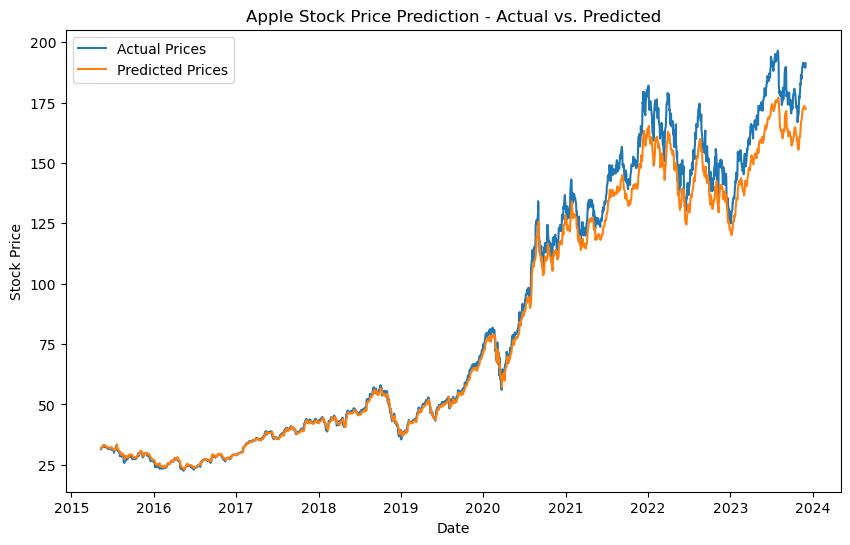

In [220]:
plt.figure(figsize=(10,6))
plt.plot(data[-len(X_test):].index, actual_stock_prices, label='Actual Prices')
plt.plot(data[-len(X_test):].index, Final_Model_predictions_final, label='Predicted Prices')
plt.title('Apple Stock Price Prediction - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [214]:
n_timesteps = 60 
n_features = 6   

current_data = np.zeros((1, n_timesteps, n_features))

# Fill the current_data with the most recent data points
current_data[0, -1, :] = scaled_data

predictions = []

for i in range(60):
    predicted_stock_price = Final_Model.predict(current_data)
    predictions.append(predicted_stock_price[0, 0])
    current_data[0, :-1, :] = current_data[0, 1:, :]
    current_data[0, -1, -1] = predicted_stock_price

    
dummy_array = np.zeros((len(predictions), n_features))

dummy_array[:, -1] = predictions

inverse_transformed_array = scaler.inverse_transform(dummy_array)
realistic_predictions = inverse_transformed_array[:, -1]

print(realistic_predictions)

1/1 [==============================] - 0s 10ms/step
[112.01758508 142.63929421 158.24068351 165.2920189  168.24255821
 169.37770816 169.75014455 169.81846992 169.7760236  169.70193824
 169.62724533 169.56274047 169.51094731 169.47105969 169.44123159
 169.41936    169.40363394 169.39246447 169.38462481 169.37921533
 169.37548828 169.37297632 169.37129389 169.37017227 169.36942452
 169.36892213 169.36860667 169.368373   169.36825617 169.36818607
 169.36812765 169.36810428 169.36808091 169.36806923 169.3680926
 169.36806923 169.36806923 169.36804586 169.36804586 169.36804586
 169.36805755 169.36805755 169.36805755 169.36805755 169.36804586
 169.36804586 169.36804586 169.36804586 169.36804586 169.36804586
 169.36804586 169.36804586 169.36804586 169.36804586 169.36804586
 169.36804586 169.36804586 169.36804586 169.36804586 169.36804586]


## Future Work 

#### Since the prediction is stagnant after a few days, this is due to the fact that we are not considering that the other feature we are just repeating, as i was using the last date data points of the features for the Prediction. To Ensure a better Prediction and Accuracy, ARIMA (Autoregressive integrated moving average) Model needs to be integrated to the features so as the data ponts also keep updating with the moving average.